In this nootebook covid data from our world in data is used. Currently, data downloaded on 6th September 2022 is used. The data is loaded and then inspected with visually and by statistical tests for the time series which are not too much affected by problems like gaps.

In [3]:
#basic libraries
import pickle

import numpy as np

import pandas as pd
#for categorial ordering 
from pandas.api.types import CategoricalDtype

import scipy as sp
from scipy.fft import fft, fftfreq

from datetime import date, time, datetime
from dateutil.parser import parse

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as smtime
#We mainly use xgboost
from xgboost import XGBClassifier
import xgboost as xgb

#some skitlearn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

#trials
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import sklearn.metrics as met
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

Below the data is loaded. 

In [4]:
#Symbolic in numeric columns
#-           0, can be caused by secrecy 
#/           not given, too uncertain
#0           less than 0.5 but more than 0.0
#( )         strongly changed because of secrecy
#NaN          not given, likely caused by secrecy

#Abweichungen in den Summen durch Runden der Zahlen

#census data frame
path='/home/tobias/ml-testing/Deutschland/'
cdf=pd.read_csv(path+"Zensus11_Datensatz_Bevoelkerung.csv",sep=';',encoding= 'unicode_escape',low_memory=False)
#changing columns to engligh and without tabs
#all property columns done, not yet the keys 
cdf.rename(columns={'RS_Gem':'RS_Gemeinde', 'AEWZ':'population','DEM_1.1':'gender_total','DEM_1.2':'male','DEM_1.3':'female','DEM_2.1':'marital_status_total','DEM_2.2':'marital_status_male','DEM_2.3':'marital_status_female','DEM_2.4':'single_total','DEM_2.5':'single_male','DEM_2.6':'single_female','DEM_2.7':'married_total','DEM_2.8':'married_male','DEM_2.9':'married_female','DEM_2.10':'widowed_total','DEM_2.11':'widowed_male','DEM_2.12':'widowed_female','DEM_2.13':'divorced_total','DEM_2.14':'divorced_male','DEM_2.15':'divorced_female','DEM_2.16':'civil_union_total','DEM_2.17':'civil_union_male','DEM_2.18':'civil_union_female','DEM_2.19':'civil_union_widowed_total','DEM_2.20':'civil_union_widowed_male','DEM_2.21':'civil_union_widowed_female','DEM_2.22':'civil_union_divorced_total','DEM_2.23':'civil_union_divorced_male','DEM_2.24':'civil_union_divorved_female','DEM_2.25':'not_specified_total','DEM_2.26':'not_specified_male','DEM_2.27':'not_specified_female','DEM_3.1':'age_groups1_total','DEM_3.2':'age_groups1_male','DEM_3.3':'age_groups1_female','DEM_3.4':'0_9_total','DEM_3.5':'0_9_male','DEM_3.6':'0_9_female','DEM_3.7':'10_19_total','DEM_3.8':'10_19_male','DEM_3.9':'10_19_female','DEM_3.10':'20_29_total','DEM_3.11':'20_29_male','DEM_3.12':'20_29_female','DEM_3.13':'30_39_total','DEM_3.14':'30_39_male','DEM_3.15':'30_39_female','DEM_3.16':'40_49_total','DEM_3.17':'40_49_male','DEM_3.18':'40_49_female','DEM_3.19':'50_59_total','DEM_3.20':'50_59_male','DEM_3.21':'50_59_female','DEM_3.22':'60_69_total','DEM_3.23':'60_69_male','DEM_3.24':'60_69_female','DEM_3.25':'70_79_total','DEM_3.26':'70_79_male','DEM_3.27':'70_79_female','DEM_3.28':'over_80_total','DEM_3.29':'over_80_male','DEM_3.30':'over_80_female','DEM_4.1':'age_groups2_total','DEM_4.2':'age_groups2_male','DEM_4.3':'age_groups2_female','DEM_4.4':'total_0_2','DEM_4.5':'male_0_2','DEM_4.6':'female_0_2','DEM_4.7':'total_3_5','DEM_4.8':'male_3_5','DEM_4.9':'female_3_5','DEM_4.10':'total_6_14','DEM_4.11':'male_6_14','DEM_4.12':'female_6_14','DEM_4.13':'total_15_17','DEM_4.14':'male_15_17','DEM_4.15':'female_15_17','DEM_4.16':'total_18_24','DEM_4.17':'male_18_24','DEM_4.18':'female_18_24','DEM_4.19':'total_25_29','DEM_4.20':'male_25_29','DEM_4.21':'female_25_29','DEM_4.22':'total_30_39','DEM_4.23':'male_30_39','DEM_4.24':'female_30_39','DEM_4.25':'total_40_49','DEM_4.26':'male_40_49','DEM_4.27':'female_40_49','DEM_4.28':'total_50_64','DEM_4.29':'male_50_64','DEM_4.30':'female_50_64','DEM_4.31':'total_65_74','DEM_4.32':'male_65_74','DEM_4.33':'female_65_74','DEM_4.34':'total_75_and_older','DEM_4.35':'male_75_and_older','DEM_4.36':'female_75_and_older','DEM_5.1':'citizen_total','DEM_5.2':'citizen_german','DEM_5.3':'citizen_foreign','DEM_5.4':'citizen_eu27','DEM_5.5':'citizen_other_europe','DEM_5.6':'citizen_other_continents','DEM_5.7':'citizen_other','DEM_6.1':'birth_country_total','DEM_6.2':'birth_country_germany','DEM_6.3':'birth_country_foreign','DEM_6.4':'birth_country_eu27','DEM_6.5':'birth_country_other_europe','DEM_6.6':'birth_country_other_continents','DEM_6.7':'birth_country_other','REL_1.1':'religion_total','REL_1.2':'religion_catholic','REL_1.3':'religion_protestant','REL_1.4':'religion_other','MIG_1.1':'migration_background_all','MIG_1.2':'migration_background_no','MIG_1.3':'migration_background_yes','MIG_1.4':'migration_background_foreign_all','MIG_1.5':'migration_background_foreign_foreign_born','MIG_1.6':'migration_background_foreign_german_born','MIG_1.7':'migration_background_german_all','MIG_1.8':'migration_background_german_foreign_born','MIG_1.9':'migration_background_german_german_born','MIG_1.10':'migration_background_german_german_born_mig_2parents','MIG_1.11':'migration_background_german_german_born_mig_1parents','MIG_2.1':'migration_all_years','MIG_2.2':'migration_56-59','MIG_2.3':'migration_60-69','MIG_2.4':'migration_70-79','MIG_2.5':'migration_80-89','MIG_2.6':'migration_90-99','MIG_2.7':'migration_00-11','MIG_2.8':'migration_year_nan','MIG_3.1':'migration_all_regions','MIG_3.2':'migration_eu27','MIG_3.3':'migration_rest_europes','MIG_3.4':'migration_other_continents','MIG_3.5':'migration_regions_nan','ERW_1.1':'employment_status_all','ERW_1.2':'employment_status_male','ERW_1.3':'employment_status_female','ERW_1.4':'employment_prefering_all','ERW_1.5':'employment_prefered_male','ERW_1.6':'employment_preferred_female','ERW_1.7':'employed_all','ERW_1.8':'employed_male','ERW_1.9':'employed_female','ERW_1.10':'unemployed_all','ERW_1.11':'unemployed_male','ERW_1.12':'unemployed_female','ERW_1.13':'not_employable_all','ERW_1.14':'not_employable_male','ERW_1.15':'not_employable_female','ERW_2.1':'profession_status_all','ERW_2.2':'worker_employee','ERW_2.3':'officier','ERW_2.4':'self-employed_single','ERW_2.5':'self_employed_company','ERW_2.6':'helpers_family','ERW_3.1':'profession_all','ERW_3.2':'manager','ERW_3.3':'academic','ERW_3.4':'technical_trained','ERW_3.5':'office','ERW_3.6':'sale','ERW_3.7':'agriculture_trained','ERW_3.8':'tradesman','ERW_3.9':'workers','ERW_3.10':'unskilled_laborers','ERW_3.11':'soldier','ERW_4.1':'branches','ERW_4.2':'agriculture','ERW_4.3':'production','ERW_4.4':'mining_and_industry','ERW_4.5':'distribution','ERW_4.6':'building','ERW_4.7':'sale_car_repaing_dining_traffic_communication','ERW_4.8':'sale_car_repair_dining','ERW_4.9':'traffic_communication','ERW_4.10':'other_services','ERW_4.11':'finance_insurance','ERW_4.12':'real_estate_science','ERW_4.13':'public_administration','ERW_4.14':'public_private_services','ERW_4.15':'branch_nan','BIL_2.1':'in_education_level_total','BIL_2.2':'in_education_primary','BIL_2.3':'in_education_secondary1','BIL_2.4':'in_education_secondary2','BIL_3.1':'in_education_school_form_total','BIL_3.2':'in_education_elementary','BIL_3.3':'in_education_secondary_basic','BIL_3.4':'in_education_secondary_middle','BIL_3.5':'in_education_grammar','BIL_3.6':'in_education_secondary_general','BIL_3.7':'in_education_school_other','BIL_4.1':'educated_school_15_and_older','BIL_4.2':'not_and_not_yet_educated','BIL_4.3':'no_school_certificate','BIL_4.4':'school_time_not_finished','BIL_4.5':'basic_secondary','BIL_4.6':'middle_secondary','BIL_4.7':'middle_secondary_finished','BIL_4.8':'in_grammar_school','BIL_4.9':'qualified_for_community_college','BIL_4.10':'qualified_for_university','BIL_5.1':'profession_education_total','BIL_5.2':'no_profession_education','BIL_5.3':'apprenticeship','BIL_5.4':'professional_school','BIL_5.5':'professional_academy','BIL_5.6':'community_college','BIL_5.7':'university','BIL_5.8':'PhD_and_MD'}, inplace=True)
column_names=list(cdf.columns)
print(f"columns are {column_names}")
print(f"the transition from key to integer columns {column_names[7:9]} from 7 to 8")

print(f"number of colums is {len(column_names)}")

columns are ['AGS_12', 'RS_Land', 'RS_RB_NUTS2', 'RS_Kreis', 'RS_VB', 'RS_Gemeinde', 'Name', 'Reg_Hier', 'population', 'gender_total', 'male', 'female', 'marital_status_total', 'marital_status_male', 'marital_status_female', 'single_total', 'single_male', 'single_female', 'married_total', 'married_male', 'married_female', 'widowed_total', 'widowed_male', 'widowed_female', 'divorced_total', 'divorced_male', 'divorced_female', 'civil_union_total', 'civil_union_male', 'civil_union_female', 'civil_union_widowed_total', 'civil_union_widowed_male', 'civil_union_widowed_female', 'civil_union_divorced_total', 'civil_union_divorced_male', 'civil_union_divorved_female', 'not_specified_total', 'not_specified_male', 'not_specified_female', 'age_groups1_total', 'age_groups1_male', 'age_groups1_female', '0_9_total', '0_9_male', '0_9_female', '10_19_total', '10_19_male', '10_19_female', '20_29_total', '20_29_male', '20_29_female', '30_39_total', '30_39_male', '30_39_female', '40_49_total', '40_49_mal

We are now checking the types of some columns. 

In [5]:
for i in range(12):
    print(f"type of column {column_names[i]} is {cdf[column_names[i]].dtypes}")

type of column AGS_12 is int64
type of column RS_Land is int64
type of column RS_RB_NUTS2 is float64
type of column RS_Kreis is float64
type of column RS_VB is float64
type of column RS_Gemeinde is float64
type of column Name is object
type of column Reg_Hier is object
type of column population is int64
type of column gender_total is int64
type of column male is object
type of column female is object


The key columns are mostly integers and partly objects. We will whether they can be stored better as categories. In the property columns many are objects. That is not good for using them, thus we change them to numbers. That requires the addition of quality indicators to not loose the not numeric information.

In [6]:
print(f"number of rows in data frame is {len(cdf)}")
print(f"number of unique 'Name' is {cdf.Name.nunique()}")
print(f"number of unique 'Reg_Hier' is {cdf.Reg_Hier.nunique()}")
print(f"unique values of is {cdf.Reg_Hier.unique()}")


number of rows in data frame is 12544
number of unique 'Name' is 11735
number of unique 'Reg_Hier' is 6
unique values of is ['Bund' 'Land' 'Gemeinde' 'Stadtkreis/kreisfreie Stadt/Landkreis'
 'Gemeindeverband' 'Regierungsbezirk/NUTS2']


While name has nearly the same number of values  as there are rows, there are much less in Reg_Hier. Reg_Hier is the level in 
administration hierarchie, thus we also set the order. 

In [7]:
cdf['Reg_hier'] = CategoricalDtype(categories=['Gemeinde', 'Gemeindeverband', 'Stadtkreis/kreisfreie Stadt/Landkreis','Regierungsbezirk/NUTS2','Land','Bund'], ordered=True)


We are now checking the states (Land) with the fewest rows. That should be the city states (Bremen, Hamburg, Berlin), where it varies whether they are subdivided or not.

In [8]:
print(cdf.AGS_12.groupby(cdf['RS_Land']).count())
print(cdf.iloc[:,0:8].loc[cdf['RS_Land']==0])
print(cdf.iloc[:,0:8].loc[cdf['RS_Land']==2])
print(cdf.iloc[:,0:8].loc[cdf['RS_Land']==4])
print(cdf.iloc[:,0:8].loc[cdf['RS_Land']==11])

RS_Land
0        1
1     1219
2        3
3     1209
4        5
5      455
6      456
7     2506
8     1150
9     2160
10      59
11       3
12     491
13     905
14     583
15     252
16    1087
Name: AGS_12, dtype: int64
   AGS_12  RS_Land  RS_RB_NUTS2  RS_Kreis  RS_VB  RS_Gemeinde         Name  \
0       0        0          NaN       NaN    NaN          NaN  Deutschland   

  Reg_Hier  
0     Bund  
           AGS_12  RS_Land  RS_RB_NUTS2  RS_Kreis  RS_VB  RS_Gemeinde  \
1220            2        2          NaN       NaN    NaN          NaN   
1221         2000        2          0.0       0.0    NaN          NaN   
1222  20000000000        2          0.0       0.0    0.0          0.0   

                               Name                               Reg_Hier  
1220                        Hamburg                                   Land  
1221  Hamburg, Freie und Hansestadt  Stadtkreis/kreisfreie Stadt/Landkreis  
1222  Hamburg, Freie und Hansestadt                               Gemei

For Berlin and Hamburg, there are no subdivision, just different entries on the different hiearchical levels. For Bremen there are two city subdivision. The basic key is Gemeinde. There are partly several of it, but they are just duplicated and duplicated can be avoided by setting Reg_Hier to Gemeinde.

For now we just work on the city level, later we might do more research to add census or other information on subdivision of city levels for big cities. 


The low quality data is indicated in different ways, all non numeric. To convert to numeric values in these cases and not use the quality information we add quality information columns to the data frame. 

In [9]:
#r () indicates low quality data because of ensuring data security - of all numeric columns
#() and  missing can be maybe replaced by higher level information 

for i in range(8, 223):
    print(f"feature {i}")
    #name of quality column
    new="qual_"+column_names[i]
    #check all object columns
    if cdf[column_names[i]].dtypes==object:
        print(new)
        #low quality marher for () and \, the later is bad for some other reason not low numbers
        cdf[new] =cdf[column_names[i]].str.contains('\(')
        print(cdf[new])
    else:  #create dummy for not object columns for simplicity
        cdf[new] = 0 
    #remove low quality indicators in columns, replace -(true zero) with 0, set low quality 0 to -1, and nan to -2
    cdf[column_names[i]]=cdf[column_names[i]].replace('\(','',regex=True).replace('\)','',regex=True).replace('-','0').replace('/','-2').fillna(-1).astype(int)

feature 8
feature 9
feature 10
qual_male
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_male, Length: 12544, dtype: bool
feature 11
qual_female
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_female, Length: 12544, dtype: bool
feature 12
feature 13
qual_marital_status_male
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_marital_status_male, Length: 12544, dtype: bool
feature 14
qual_marital_status_female
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_marital_status_female, Length: 

feature 47
qual_10_19_female
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543     True
Name: qual_10_19_female, Length: 12544, dtype: bool
feature 48
qual_20_29_total
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542     True
12543    False
Name: qual_20_29_total, Length: 12544, dtype: bool
feature 49
qual_20_29_male
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_20_29_male, Length: 12544, dtype: bool
feature 50
qual_20_29_female
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543     True
Name: qual_20_29_female, Length: 12544, dtype: bool
feature 51
qual_30_39_

/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a

feature 60
qual_60_69_total
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_60_69_total, Length: 12544, dtype: bool
feature 61
qual_60_69_male
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_60_69_male, Length: 12544, dtype: bool
feature 62
qual_60_69_female
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_60_69_female, Length: 12544, dtype: bool
feature 63
qual_70_79_total
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_70_79_total, Length: 12544, dtype: bool
feature 64
qual_70_79_ma

/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a

feature 66
qual_over_80_total
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_over_80_total, Length: 12544, dtype: bool
feature 67
qual_over_80_male
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_over_80_male, Length: 12544, dtype: bool
feature 68
qual_over_80_female
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_over_80_female, Length: 12544, dtype: bool
feature 69
feature 70
qual_age_groups2_male
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_age_groups2_male, Length: 12544, dty

/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] = 0
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

feature 71
qual_age_groups2_female
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_age_groups2_female, Length: 12544, dtype: bool
feature 72
qual_total_0_2
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_total_0_2, Length: 12544, dtype: bool
feature 73
qual_male_0_2
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_male_0_2, Length: 12544, dtype: bool
feature 74
qual_female_0_2
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_female_0_2, Length: 12544, dtype: bool
feature 75
qual_total_

/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a

feature 77
qual_female_3_5
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_female_3_5, Length: 12544, dtype: bool
feature 78
qual_total_6_14
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543     True
Name: qual_total_6_14, Length: 12544, dtype: bool
feature 79
qual_male_6_14
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_male_6_14, Length: 12544, dtype: bool
feature 80
qual_female_6_14
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_female_6_14, Length: 12544, dtype: bool
feature 81
qual_total_15_17
0   

/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a

feature 82
qual_male_15_17
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_male_15_17, Length: 12544, dtype: bool
feature 83
qual_female_15_17
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_female_15_17, Length: 12544, dtype: bool
feature 84
qual_total_18_24
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543     True
Name: qual_total_18_24, Length: 12544, dtype: bool
feature 85
qual_male_18_24
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541     True
12542    False
12543    False
Name: qual_male_18_24, Length: 12544, dtype: bool


/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a

feature 86
qual_female_18_24
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_female_18_24, Length: 12544, dtype: bool
feature 87
qual_total_25_29
0        False
1        False
2        False
3        False
4        False
         ...  
12539     True
12540    False
12541    False
12542    False
12543    False
Name: qual_total_25_29, Length: 12544, dtype: bool
feature 88
qual_male_25_29
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_male_25_29, Length: 12544, dtype: bool
feature 89
qual_female_25_29
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_female_25_29, Length: 12544, dtype: bool
feature 90
qual_total_

/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a

feature 92
qual_female_30_39
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_female_30_39, Length: 12544, dtype: bool
feature 93
qual_total_40_49
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_total_40_49, Length: 12544, dtype: bool
feature 94
qual_male_40_49
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543     True
Name: qual_male_40_49, Length: 12544, dtype: bool
feature 95
qual_female_40_49
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_female_40_49, Length: 12544, dtype: bool
feature 96
qual_total_

/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a

0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_female_50_64, Length: 12544, dtype: bool
feature 99
qual_total_65_74
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_total_65_74, Length: 12544, dtype: bool
feature 100
qual_male_65_74
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_male_65_74, Length: 12544, dtype: bool
feature 101
qual_female_65_74
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_female_65_74, Length: 12544, dtype: bool
feature 102
qual_total_75_and_older
0        Fals

/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a

feature 105
feature 106
qual_citizen_german
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_citizen_german, Length: 12544, dtype: bool
feature 107
qual_citizen_foreign
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_citizen_foreign, Length: 12544, dtype: bool
feature 108
qual_citizen_eu27
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_citizen_eu27, Length: 12544, dtype: bool
feature 109
qual_citizen_other_europe
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_citizen_other_europe, L

/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a

feature 112
feature 113
qual_birth_country_germany
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_birth_country_germany, Length: 12544, dtype: bool
feature 114
qual_birth_country_foreign
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_birth_country_foreign, Length: 12544, dtype: bool
feature 115
qual_birth_country_eu27
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_birth_country_eu27, Length: 12544, dtype: bool
feature 116
qual_birth_country_other_europe
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543

/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a

feature 118
qual_birth_country_other
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_birth_country_other, Length: 12544, dtype: bool
feature 119
feature 120
qual_religion_catholic
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_religion_catholic, Length: 12544, dtype: bool
feature 121
qual_religion_protestant
0        False
1        False
2        False
3        False
4        False
         ...  
12539     True
12540    False
12541    False
12542    False
12543    False
Name: qual_religion_protestant, Length: 12544, dtype: bool
feature 122
qual_religion_other
0        False
1        False
2        False
3        False
4        False
         ...  
12539    False
12540    False
12541    False
12542    False
12543    False
Name: qual_r

/tmp/ipykernel_10467/3617180230.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] = 0
/tmp/ipykernel_10467/3617180230.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] = 0
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column

0        False
1        False
2        False
3        False
4        False
         ...  
12539      NaN
12540      NaN
12541      NaN
12542      NaN
12543      NaN
Name: qual_migration_background_foreign_foreign_born, Length: 12544, dtype: object
feature 128
qual_migration_background_foreign_german_born
0        False
1        False
2        False
3        False
4        False
         ...  
12539      NaN
12540      NaN
12541      NaN
12542      NaN
12543      NaN
Name: qual_migration_background_foreign_german_born, Length: 12544, dtype: object
feature 129
qual_migration_background_german_all
0        False
1        False
2        False
3        False
4        False
         ...  
12539      NaN
12540      NaN
12541      NaN
12542      NaN
12543      NaN
Name: qual_migration_background_german_all, Length: 12544, dtype: object
feature 130
qual_migration_background_german_foreign_born
0        False
1        False
2        False
3        False
4        False
         ...  
12539      N

/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a

feature 135
qual_migration_56-59
0        False
1        False
2        False
3        False
4        False
         ...  
12539      NaN
12540      NaN
12541      NaN
12542      NaN
12543      NaN
Name: qual_migration_56-59, Length: 12544, dtype: object
feature 136
qual_migration_60-69
0        False
1        False
2        False
3        False
4        False
         ...  
12539      NaN
12540      NaN
12541      NaN
12542      NaN
12543      NaN
Name: qual_migration_60-69, Length: 12544, dtype: object
feature 137
qual_migration_70-79
0        False
1        False
2        False
3        False
4        False
         ...  
12539      NaN
12540      NaN
12541      NaN
12542      NaN
12543      NaN
Name: qual_migration_70-79, Length: 12544, dtype: object
feature 138
qual_migration_80-89
0        False
1        False
2        False
3        False
4        False
         ...  
12539      NaN
12540      NaN
12541      NaN
12542      NaN
12543      NaN
Name: qual_migration_80-89, Length: 1

/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a

0        False
1        False
2        False
3        False
4        False
         ...  
12539      NaN
12540      NaN
12541      NaN
12542      NaN
12543      NaN
Name: qual_migration_rest_europes, Length: 12544, dtype: object
feature 145
qual_migration_other_continents
0        False
1        False
2        False
3        False
4        False
         ...  
12539      NaN
12540      NaN
12541      NaN
12542      NaN
12543      NaN
Name: qual_migration_other_continents, Length: 12544, dtype: object
feature 146
qual_migration_regions_nan
0        False
1        False
2        False
3        False
4        False
         ...  
12539      NaN
12540      NaN
12541      NaN
12542      NaN
12543      NaN
Name: qual_migration_regions_nan, Length: 12544, dtype: object
feature 147
feature 148
feature 149
feature 150
feature 151
feature 152
feature 153
feature 154
feature 155
feature 156
qual_unemployed_all
0        False
1        False
2        False
3        False
4        False
         ...

/tmp/ipykernel_10467/3617180230.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] = 0
/tmp/ipykernel_10467/3617180230.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] = 0
/tmp/ipykernel_10467/3617180230.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] = 0
/tmp/ip

feature 167
qual_helpers_family
0        False
1        False
2        False
3        False
4        False
         ...  
12539      NaN
12540      NaN
12541      NaN
12542      NaN
12543      NaN
Name: qual_helpers_family, Length: 12544, dtype: object
feature 168
feature 169
qual_manager
0        False
1        False
2        False
3        False
4        False
         ...  
12539      NaN
12540      NaN
12541      NaN
12542      NaN
12543      NaN
Name: qual_manager, Length: 12544, dtype: object
feature 170
feature 171
feature 172
feature 173
feature 174
qual_agriculture_trained
0        False
1        False
2        False
3        False
4        False
         ...  
12539      NaN
12540      NaN
12541      NaN
12542      NaN
12543      NaN
Name: qual_agriculture_trained, Length: 12544, dtype: object
feature 175
feature 176
qual_workers
0        False
1        False
2        False
3        False
4        False
         ...  
12539      NaN
12540      NaN
12541      NaN
12542      Na

/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] = 0
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

feature 183
qual_distribution
0        False
1        False
2         True
3         True
4        False
         ...  
12539      NaN
12540      NaN
12541      NaN
12542      NaN
12543      NaN
Name: qual_distribution, Length: 12544, dtype: object
feature 184
qual_building
0        False
1        False
2        False
3        False
4        False
         ...  
12539      NaN
12540      NaN
12541      NaN
12542      NaN
12543      NaN
Name: qual_building, Length: 12544, dtype: object
feature 185
qual_sale_car_repaing_dining_traffic_communication
0        False
1        False
2        False
3        False
4        False
         ...  
12539      NaN
12540      NaN
12541      NaN
12542      NaN
12543      NaN
Name: qual_sale_car_repaing_dining_traffic_communication, Length: 12544, dtype: object
feature 186
qual_sale_car_repair_dining
0        False
1        False
2        False
3        False
4        False
         ...  
12539      NaN
12540      NaN
12541      NaN
12542      NaN
12543

/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a

feature 194
feature 195
feature 196
feature 197
qual_in_education_secondary2
0        False
1        False
2        False
3        False
4        False
         ...  
12539      NaN
12540      NaN
12541      NaN
12542      NaN
12543      NaN
Name: qual_in_education_secondary2, Length: 12544, dtype: object
feature 198
feature 199
feature 200
qual_in_education_secondary_basic
0        False
1        False
2        False
3        False
4        False
         ...  
12539      NaN
12540      NaN
12541      NaN
12542      NaN
12543      NaN
Name: qual_in_education_secondary_basic, Length: 12544, dtype: object
feature 201
qual_in_education_secondary_middle
0        False
1        False
2        False
3        False
4        False
         ...  
12539      NaN
12540      NaN
12541      NaN
12542      NaN
12543      NaN
Name: qual_in_education_secondary_middle, Length: 12544, dtype: object
feature 202
qual_in_education_grammar
0        False
1        False
2        False
3        False
4      

/tmp/ipykernel_10467/3617180230.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] =cdf[column_names[i]].str.contains('\(')
/tmp/ipykernel_10467/3617180230.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf[new] = 0
/tmp/ipykernel_10467/3617180230.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

We are now checking whether the changes wroked.  

In [10]:
print("a not changed column")
print(cdf.married_total.describe())
print("a sometimes changed column")
print(cdf.citizen_german.describe())
print("a often changed column")
print(cdf.PhD_and_MD.describe())
print("quality of a often changed column")
print(cdf.qual_divorced_total.describe())


a not changed column
count    1.254400e+04
mean     1.415994e+04
std      3.510529e+05
min      0.000000e+00
25%      3.480000e+02
50%      1.037000e+03
75%      3.483750e+03
max      3.666987e+07
Name: married_total, dtype: float64
a sometimes changed column
count    1.254400e+04
mean     2.848208e+04
std      7.072410e+05
min      9.000000e+00
25%      6.860000e+02
50%      2.022500e+03
75%      6.824000e+03
max      7.403968e+07
Name: citizen_german, dtype: float64
a often changed column
count     12544.000000
mean        314.833307
std        8794.264507
min          -2.000000
25%          -1.000000
50%          -1.000000
75%          -1.000000
max      908970.000000
Name: PhD_and_MD, dtype: float64
quality of a often changed column
count     12544
unique        2
top       False
freq      11270
Name: qual_divorced_total, dtype: object


We are plotting some properties. 

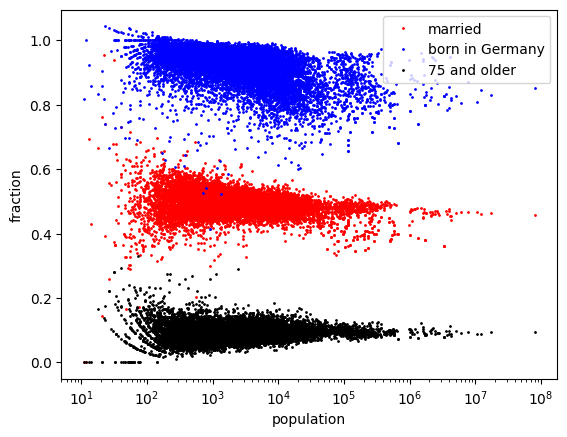

In [11]:

plt.plot(cdf['population'],cdf['married_total']/cdf['population'],'o',ms=1,color='red',label='married') 
plt.plot(cdf['population'],cdf['birth_country_germany']/cdf['population'],'o',ms=1,color='blue',label='born in Germany')
plt.plot(cdf['population'],cdf['total_75_and_older']/cdf['population'],'o',ms=1,color='black',label='75 and older')
plt.legend(loc="best")
plt.xlabel("population")
plt.ylabel("fraction")
#plt.yscale("log")
plt.xscale("log")

Some of them are available for nearly all units. Not all of them realiable at low numbers, see there some fraction which larger 100%. 

There wer likely changed for conserving privacy. The biggets problems are indicated in the quality columns. Below those are displayed. The problems is larger for units with small population and for properties which are rare as fraction of population. 

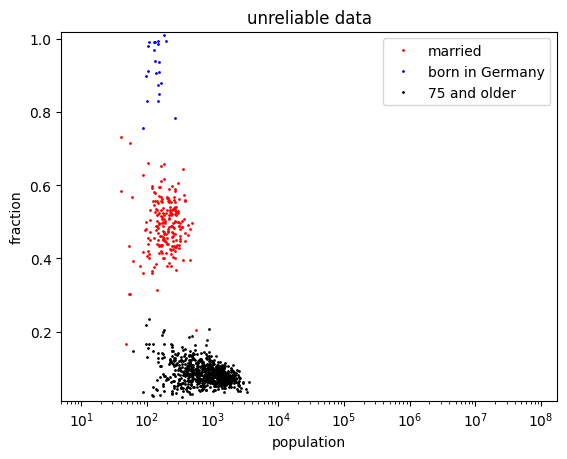

In [12]:

plt.plot(cdf['population'],(cdf['married_total']*cdf['qual_married_total'])/cdf['population'],'o',ms=1,color='red',label='married') 
plt.plot(cdf['population'],(cdf['birth_country_germany']*cdf['qual_birth_country_germany'])/cdf['population'],'o',ms=1,color='blue',label='born in Germany')
plt.plot(cdf['population'],(cdf['total_75_and_older']*cdf['qual_total_75_and_older'])/cdf['population'],'o',ms=1,color='black',label='75 and older')
plt.legend(loc="best")
plt.xlabel("population")
plt.ylabel("fraction")
#plt.yscale("log")
plt.title("unreliable data")
plt.ylim(0.01,1.02)
plt.xscale("log")

Some properties are only available for large units, usually when population is above 10000, see below. 

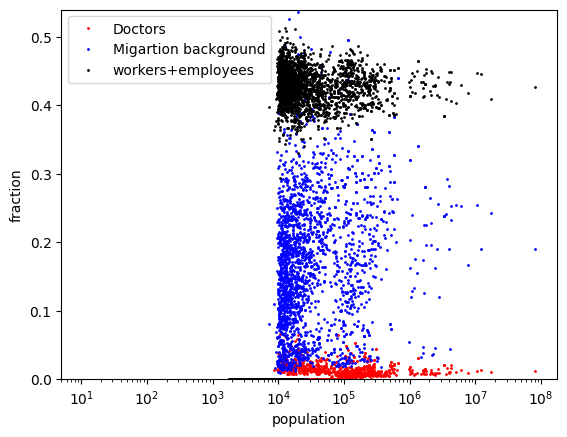

In [13]:
#first plotting takes time 
plt.plot(cdf['population'],cdf['PhD_and_MD']/cdf['population'],'o',ms=1,color='red',label='Doctors') 
plt.plot(cdf['population'],cdf['migration_background_yes']/cdf['population'],'o',ms=1,color='blue',label='Migartion background')
plt.plot(cdf['population'],cdf['worker_employee']/cdf['population'],'o',ms=1,color='black',label='workers+employees')
plt.legend(loc="best")
plt.xlabel("population")
plt.ylabel("fraction")
plt.ylim(0,0.54)
#plt.yscale("log")
plt.xscale("log")

Now we load the federal election data of 2021.

In [14]:
wdf=pd.read_csv(path+"btw21_wbz_ergebnisse.csv",sep=';',low_memory=False,skiprows=[1,1]) #row 1 is kind an additional header row
#it is not read well when included and we anyway need to translate the column names, thus we ignore it. 
print(wdf.iloc[0:5,0:20].T)
print(wdf.Kreis.unique())
print(wdf.Land.unique())
print(wdf.Regierungsbezirk.unique())
wdf['e_kreis_id']=wdf.Land*1000+wdf.Regierungsbezirk*100+wdf.Kreis

                                                          0                 1  \
Wahlkreis                                                 1                 1   
Land                                                      1                 1   
Regierungsbezirk                                          0                 0   
Kreis                                                     1                 1   
Verbandsgemeinde                                          0                 0   
Gemeinde                                                  0                 0   
Kennziffer Urnenwahlbezirke nach § 68 BWO              0000              0000   
Kennziffer Briefwahlzugehörigkeit                        00                00   
Gemeinde Name                              Flensburg, Stadt  Flensburg, Stadt   
Wahlbezirk                                               01                02   
Bezirksart                                                0                 0   
Wahlberechtigte (A)         

We arenow  looking on the column names and translate the election system ones and the  names of the parties which made it into parliament.

In [15]:

#done ar main parties, voters, not yet level and minore parties
print(wdf.columns[11:30])
wdf.rename(columns={'Wahlberechtigte (A)':'eligible_voters','Wahlberechtigte mit Sperrvermerk (A2)':'eligible_voters_not_locally' ,'Wahlberechtigte ohne Sperrvermerk (A1)':'eligible_voters_locally','Wahlberechtigte nach § 25 Abs. 2 BWO (A3)':'eligile_voters_added','CDU.1':'christian_democrats_party_votes','CDU':'christian_democrats_person_votes','Wählende (B)':'voters' ,'Wählende mit Wahlschein (B1)':'voters_not_local','Ungültige':'not_valid_person_votes','Gültige':'valid_person_votes','Ungültige.1':'not_valid_party_votes','Gültige.1':'valid_party_votes','SPD.1':'social_democrats_party_votes','SPD':'social_democrats_person_votes','CSU.1':'christian_socials_party_votes','CSU':'christian_socials_person_votes','FDP.1':'libertarians_party_votes','FDP':'libertarians_person_votes','DIE LINKE.1':'lefts_party_votes','DIE LINKE':'lefts_person_votes','AfD.1':'alternative_for_germany_party_votes','AfD':'alternative_for_germany_person_votes','GRÜNE.1':'greens_party_votes','GRÜNE':'greens_person_votes',},inplace=True)
print(wdf.columns[11:30])
print(wdf.columns[51:70])

Index(['Wahlberechtigte (A)', 'Wahlberechtigte ohne Sperrvermerk (A1)',
       'Wahlberechtigte mit Sperrvermerk (A2)',
       'Wahlberechtigte nach § 25 Abs. 2 BWO (A3)', 'Wählende (B)',
       'Wählende mit Wahlschein (B1)', 'Ungültige', 'Gültige', 'CDU', 'SPD',
       'AfD', 'FDP', 'DIE LINKE', 'GRÜNE', 'CSU', 'FREIE WÄHLER', 'Die PARTEI',
       'Tierschutzpartei', 'NPD'],
      dtype='object')
Index(['eligible_voters', 'eligible_voters_locally',
       'eligible_voters_not_locally', 'eligile_voters_added', 'voters',
       'voters_not_local', 'not_valid_person_votes', 'valid_person_votes',
       'christian_democrats_person_votes', 'social_democrats_person_votes',
       'alternative_for_germany_person_votes', 'libertarians_person_votes',
       'lefts_person_votes', 'greens_person_votes',
       'christian_socials_person_votes', 'FREIE WÄHLER', 'Die PARTEI',
       'Tierschutzpartei', 'NPD'],
      dtype='object')
Index(['LKR', 'SSW', 'Team Todenhöfer', 'UNABHÄNGIGE', 'Volt',
   

We now look on the elegible voters and the fraction of the largest party. 

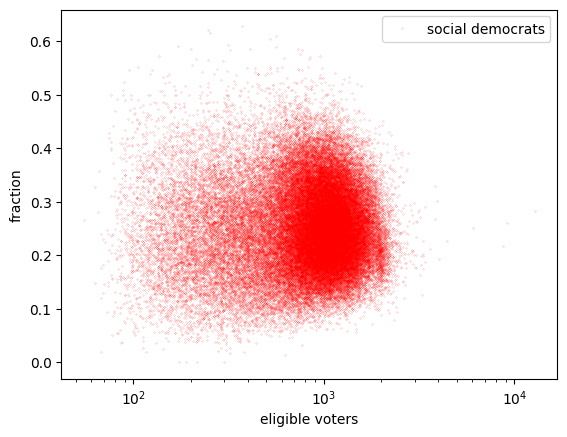

In [16]:
plt.plot(wdf['eligible_voters'],wdf['social_democrats_party_votes']/wdf['valid_party_votes'],'o',ms=0.1,color='red',label='social democrats') 
plt.legend(loc="best")
plt.xlabel("eligible voters")
plt.ylabel("fraction")
#plt.yscale("log")
plt.xscale("log")

The data is per election district. We now group by Gemeinde to get the smallest level possible in the census data. 

In [17]:
print(wdf.columns[0:10])
print(wdf.shape)
#group by Gemeinde is either (village,city)  in voter file
wdf2=wdf.groupby(wdf['Gemeinde Name']).sum(numeric_only=True)
#mean is used for numbers which are keys common to Gemeinde
wdf3=wdf.groupby(wdf['Gemeinde Name']).mean(numeric_only=True)#.astype(int)
# use mean for commun columns
wdf2['Wahlkreis']=wdf3['Wahlkreis']
wdf2['Land']=wdf3['Land']
wdf2['Regierungsbezirk']=wdf3['Regierungsbezirk']
wdf2['Kreis']=wdf3['Kreis']
wdf2['Verbandsgemeinde']=wdf3['Verbandsgemeinde']
wdf2['Gemeinde']=wdf3['Gemeinde']

print(wdf2.shape)

Index(['Wahlkreis', 'Land', 'Regierungsbezirk', 'Kreis', 'Verbandsgemeinde',
       'Gemeinde', 'Kennziffer Urnenwahlbezirke nach § 68 BWO',
       'Kennziffer Briefwahlzugehörigkeit', 'Gemeinde Name', 'Wahlbezirk'],
      dtype='object')
(94668, 108)
(10955, 103)


We plot again social democrats now on community level. 

In [18]:
plt.plot(wdf2['eligible_voters'],100*wdf2['social_democrats_party_votes']/wdf2['valid_party_votes'],'o',ms=0.5,color='red',label='social democrats') 
plt.legend(loc="best")
plt.xlabel("eligible voters")
plt.ylabel("% voter share")
#plt.yscale("log")
plt.xscale("log")

The units are clearly bigger. Howver, since there is unit larger than a million, Berlin und Hamburg are not properly included. 

FRom the census data we also select the different level data. First community and states which are passed for easier human understanding. We also mark in fromer East and West Germany, since that matters still. 

In [19]:
# communities which will be matched with election data
cdf2=cdf.loc[cdf['Reg_Hier']=='Gemeinde'].copy()
#we are also selecting Land and Kreis to make it easier to check name of this ids (this ids are the most important ones
#because they exist for nearly all Gemeinde)
#should be past as additional column for cdf2 also 
print(f" number of communities {len(cdf2)}")
#now Land is state 
cdf4=cdf.loc[cdf['Reg_Hier']=='Land'].copy()
cdf4.loc[:,'land_name']=cdf4.loc[:,'Name'].copy() #warning but works
cdf4s=cdf4[['RS_Land','land_name']].copy()
cdf4s['unification']='West' 
#classify states as existing before and after german unification as east (berlin east here) and west 
cdf4s.unification[cdf4s.RS_Land>10]='East'
print(cdf4s)
#create dictionary of Name and RS_Land to have names of Land in cdf2 
#print(cdf2['Land'])
cdf2=cdf2.merge(cdf4s,left_on='RS_Land',right_on='RS_Land')  

 number of communities 11339
       RS_Land               land_name unification
1            1      Schleswig-Holstein        West
1220         2                 Hamburg        West
1223         3           Niedersachsen        West
2432         4                  Bremen        West
2437         5     Nordrhein-Westfalen        West
2892         6                  Hessen        West
3348         7         Rheinland-Pfalz        West
5854         8       Baden-Württemberg        West
7004         9                  Bayern        West
9164        10                Saarland        West
9223        11                  Berlin        East
9226        12             Brandenburg        East
9717        13  Mecklenburg-Vorpommern        East
10622       14                 Sachsen        East
11205       15          Sachsen-Anhalt        East
11457       16               Thüringen        East


/tmp/ipykernel_10467/1466261335.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf4s.unification[cdf4s.RS_Land>10]='East'


Now also for Kreis (county).

0           Flensburg, Stadt
1     Kiel, Landeshauptstadt
2         Lübeck, Hansestadt
3          Neumünster, Stadt
4         Brunsbüttel, Stadt
5               Heide, Stadt
6                    Averlak
7                   Brickeln
8                   Buchholz
9        Burg (Dithmarschen)
10                    Dingen
11                   Eddelak
12                  Eggstedt
13                  Frestedt
14                Großenrade
15                  Hochdonn
16                     Kuden
17                 Quickborn
18       Sankt Michaelisdonn
19              Süderhastedt
Name: Name, dtype: object


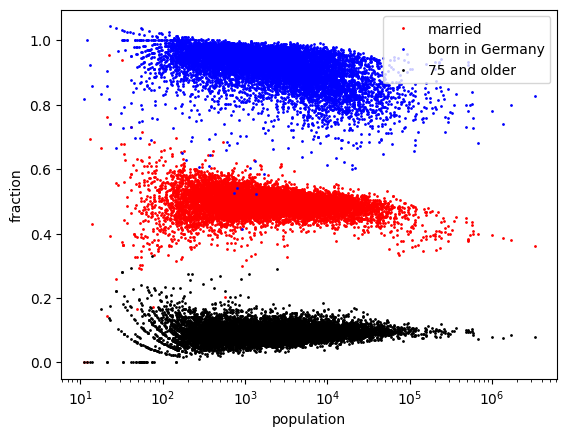

In [20]:
print(cdf2.Name[0:20])
plt.plot(cdf2['population'],cdf2['married_total']/cdf2['population'],'o',ms=1,color='red',label='married') 
plt.plot(cdf2['population'],cdf2['birth_country_germany']/cdf2['population'],'o',ms=1,color='blue',label='born in Germany')
plt.plot(cdf2['population'],cdf2['total_75_and_older']/cdf2['population'],'o',ms=1,color='black',label='75 and older')
plt.legend(loc="best")
plt.xlabel("population")
plt.ylabel("fraction")
#plt.yscale("log")
plt.xscale("log")

In [21]:
print(cdf.RS_RB_NUTS2.describe())
cdf3=cdf.loc[cdf['Reg_Hier']=='Stadtkreis/kreisfreie Stadt/Landkreis'].copy()
print(f"number of Kreis {len(cdf3)}")

#add name 
cdf3.loc[:,'kreis_name']=cdf3.loc[:,'Name']
#create new kreis-id as key because old is only unique within each Land and RB_NUTS2
cdf3.loc[:,'kreis_id']=cdf3.loc[:,'RS_Kreis']+100*cdf3.loc[:,'RS_RB_NUTS2']+1000*cdf3.loc[:,'RS_Land']
print(cdf3.loc[cdf3.index[0:50],['Name','kreis_id']])
print(f"number of unique Kreis Id {cdf3.kreis_id.nunique()}")
cdf2.loc[:,'kreis_id']=cdf2.loc[:,'RS_Kreis']+100*cdf2.loc[:,'RS_RB_NUTS2']+1000*cdf2.loc[:,'RS_Land']
cdf3s=cdf3[['kreis_id','kreis_name']]
print(f"Kreis name data frame {cdf3s}")
print(f"number of missing Kreis id {cdf3s.kreis_id.isnull().sum()}")
print(cdf2.Name[1200:1210])
print(cdf2.loc[1113:1129,['Name','RS_Kreis','land_name','kreis_id','population']])
print(cdf2.shape)
cdf2=cdf2.merge(cdf3s,left_on='kreis_id',right_on='kreis_id') 
print(cdf2.loc[1113:1129,['Name','kreis_name','land_name','kreis_id','population']])
print(cdf2.shape)

count    12527.000000
mean         2.118943
std          2.172226
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max          9.000000
Name: RS_RB_NUTS2, dtype: float64
number of Kreis 412
                               Name  kreis_id
3                  Flensburg, Stadt    1001.0
5            Kiel, Landeshauptstadt    1002.0
7                Lübeck, Hansestadt    1003.0
9                 Neumünster, Stadt    1004.0
10                     Dithmarschen    1051.0
133             Herzogtum Lauenburg    1053.0
274                   Nordfriesland    1054.0
416                     Ostholstein    1055.0
456                       Pinneberg    1056.0
512                            Plön    1057.0
605           Rendsburg-Eckernförde    1058.0
787             Schleswig-Flensburg    1059.0
935                        Segeberg    1060.0
1039                      Steinburg    1061.0
1159                       Stormarn    1062.0
1221  Hamburg, Freie und Hansestad

That gets about the same range of populations. There are some differences, at both ends. Very small villages are missing in the election data. They are likely in lkkarger villages included. Probably, they are not so important, since their overall population is small and also the census data on them not so useful. 

On the other end there are larger cities in the population data than in the election data. The largest two cities Hamburg and Berlin are thus certainly split up in the election data. We are also checking other large cities.

In [22]:
print(wdf2.eligible_voters[(wdf2['eligible_voters']>150000)])  

Gemeinde Name
Aachen, Stadt                                                 176306
Augsburg                                                      187164
Berlin, Stadt, Bezirk Charlottenburg-Wilmersdorf (Teil)       217663
Berlin, Stadt, Bezirk Lichtenberg                             200673
Berlin, Stadt, Bezirk Marzahn-Hellersdorf                     197988
Berlin, Stadt, Bezirk Neukölln                                197037
Berlin, Stadt, Bezirk Pankow (Teil)                           285108
Berlin, Stadt, Bezirk Reinickendorf                           176585
Berlin, Stadt, Bezirk Spandau                                 159388
Berlin, Stadt, Bezirk Steglitz-Zehlendorf                     217814
Berlin, Stadt, Bezirk Tempelhof-Schöneberg                    231500
Berlin, Stadt, Bezirk Treptow-Köpenick                        207127
Bielefeld, Stadt                                              234469
Bochum, Stadt (Teil)                                          267771
Bonn, Stadt         

The problem seems to be that to large cities Teil is added in the name. The number of eligible voters indicated that it is complete in contrast to its name. In addition, Berlin and Hamburg slit up into Bezirke (boroughs)

In [23]:
wdf2.reset_index(inplace=True)

#we get the problematic cases
s=wdf2[wdf2['Gemeinde Name'].str.contains('(Teil)')]
s1=wdf2[wdf2['Gemeinde Name'].str.contains('Hamburg')]
s2=wdf2[wdf2['Gemeinde Name'].str.contains('Berlin')]
print(s['Gemeinde Name'])
print(s1['Gemeinde Name'])
print(s2['Gemeinde Name'])
print(f"colum of Name {s1.columns.get_loc('Gemeinde Name')}")
#we change the names 
#wdf2.iloc[823:837,0]='Berlin, Stadt'  not anymore because double grouing seems not work 
#wdf2.iloc[4126:4132,0]='Hamburg, Freie und Hansestadt'  
wdf2.iloc[1049,0]='Bochum, Stadt'
wdf2.iloc[1230,0]='Bremen, Stadt'
wdf2.iloc[2513,0]='Dortmund, Stadt'
wdf2.iloc[2547,0]='Dresden, Stadt'
wdf2.iloc[2561,0]='Duisburg, Stadt'
wdf2.iloc[2623,0]='Düsseldorf, Stadt'
wdf2.iloc[3012,0]='Essen, Stadt'
wdf2.iloc[3214,0]='Frankfurt am Main, Stadt'
wdf2.iloc[4160,0]='Hannover, Landeshauptstadt'
wdf2.iloc[5485,0]='Krefeld, Stadt'
wdf2.iloc[5607,0]='Köln, Stadt'
wdf2.iloc[5896,0]='Leipzig, Stadt'
wdf2.iloc[6741,0]='München, Landeshauptstadt'
wdf2.iloc[7239,0]='Nürnberg'
wdf2.iloc[9423,0]='Stuttgart, Landeshauptstadt'
wdf2.iloc[10766,0]='Wuppertal, Stadt'
#other cities changed which had no match before  all had more added to stadt
wdf2.iloc[8348,0]='Rostock, Hansestadt'
wdf2.iloc[2206,0]='Cottbus, Stadt'
wdf2.iloc[3720,0]='Greifswald, Hansestadt'
wdf2.iloc[4063,0]='Hagen, Stadt'
wdf2.iloc[4318,0]='Heilbronn, Stadt'
wdf2.iloc[6880,0]='Neubrandenburg, Stadt'
wdf2.iloc[9135,0]='Solingen, Stadt'


#s4=wdf2[wdf2['Gemeinde Name'].str.contains('Solingen')]
#print(s4['Gemeinde Name'])
#print(cdf2.Name[cdf2['Name'].str.contains('Solingen')])
#below all macthed now
#s4=wdf2[wdf2['Gemeinde Name'].str.contains('Rostock')]
#print(s4['Gemeinde Name'])
#print(cdf2.Name[cdf2['Name'].str.contains('Rostock')])
#s4=wdf2[wdf2['Gemeinde Name'].str.contains('Cottbus')]
#print(s4['Gemeinde Name'])
#print(cdf2.Name[cdf2['Name'].str.contains('Cottbus')])
#s4=wdf2[wdf2['Gemeinde Name'].str.contains('Greifswald')]
#print(s4['Gemeinde Name'])
#print(cdf2.Name[cdf2['Name'].str.contains('Greifswald')])
#s4=wdf2[wdf2['Gemeinde Name'].str.contains('Hagen')]
#print(s4['Gemeinde Name'])
#print(cdf2.Name[cdf2['Name'].str.contains('Hagen')])
#s4=wdf2[wdf2['Gemeinde Name'].str.contains('Heilbronn')]
#print(s4['Gemeinde Name'])
#print(cdf2.Name[cdf2['Name'].str.contains('Heilbronn')])
#s4=wdf2[wdf2['Gemeinde Name'].str.contains('Neubrandenburg')]
#print(s4['Gemeinde Name'])
#print(cdf2.Name[cdf2['Name'].str.contains('Neubrandenburg')])


823      Berlin, Stadt, Bezirk Charlottenburg-Wilmersdo...
831                    Berlin, Stadt, Bezirk Pankow (Teil)
1049                                  Bochum, Stadt (Teil)
1230                                  Bremen, Stadt (Teil)
2513                                Dortmund, Stadt (Teil)
2547                                 Dresden, Stadt (Teil)
2561                                Duisburg, Stadt (Teil)
2623                              Düsseldorf, Stadt (Teil)
3012                                   Essen, Stadt (Teil)
3214                       Frankfurt am Main, Stadt (Teil)
4128     Hamburg, Freie und Hansestadt, Bezirk Hamburg-...
4129     Hamburg, Freie und Hansestadt, Bezirk Hamburg-...
4131     Hamburg, Freie und Hansestadt, Bezirk Wandsbek...
4160                     Hannover, Landeshauptstadt (Teil)
5485                                 Krefeld, Stadt (Teil)
5607                                    Köln, Stadt (Teil)
5896                                 Leipzig, Stadt (Tei

/tmp/ipykernel_10467/1743137795.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  s=wdf2[wdf2['Gemeinde Name'].str.contains('(Teil)')]


Now change also name for Berlin and Hamburg. 

In [24]:
##sum/mean up values of berlin values
ber=wdf2.iloc[823:837,:].sum()
c=wdf2.iloc[823:837,0].count()
print(c)
#change name and keys 
ber['Gemeinde Name']='Berlin, Stadt'
ber['Wahlkreis']=ber['Wahlkreis']/c
ber['Land']=ber['Land']/c
ber['Regierungsbezirk']=ber['Regierungsbezirk']/c
ber['Kreis']=ber['Kreis']/c
ber['Verbandsgemeinde']=ber['Verbandsgemeinde']/c
ber['Gemeinde']=ber['Gemeinde']/c
print(ber)
#same for hamburg
ham=wdf2.iloc[4126:4132,:].sum()
c=wdf2.iloc[4126:4132,0].count()
print(c)
#change name and keys 
ham['Gemeinde Name']='Hamburg, Freie und Hansestadt'
ham['Wahlkreis']=ham['Wahlkreis']/c
ham['Land']=ham['Land']/c
ham['Regierungsbezirk']=ham['Regierungsbezirk']/c
ham['Kreis']=ham['Kreis']/c
ham['Verbandsgemeinde']=ham['Verbandsgemeinde']/c
ham['Gemeinde']=ham['Gemeinde']/c
print(ham)
#append the two new values
wdf2 = wdf2.append(ber, ignore_index=True)
wdf2 = wdf2.append(ham, ignore_index=True)
print(wdf2)

14
Gemeinde Name        Berlin, Stadt
Wahlkreis                80.364728
Land                          11.0
Regierungsbezirk          1.571429
Kreis                     5.785714
                         ...      
SSW.1                            0
Team Todenhöfer.1            20168
UNABHÄNGIGE.1                    0
Volt.1                       11645
e_kreis_id                42029665
Length: 104, dtype: object
6
Gemeinde Name        Hamburg, Freie und Hansestadt
Wahlkreis                                20.871511
Land                                           2.0
Regierungsbezirk                               0.0
Kreis                                      4.21673
                                 ...              
SSW.1                                            0
Team Todenhöfer.1                             8952
UNABHÄNGIGE.1                                    0
Volt.1                                        5429
e_kreis_id                                 4123773
Length: 104, dtype: ob

/tmp/ipykernel_10467/404759679.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wdf2 = wdf2.append(ber, ignore_index=True)
/tmp/ipykernel_10467/404759679.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wdf2 = wdf2.append(ham, ignore_index=True)


Now again plotting. 

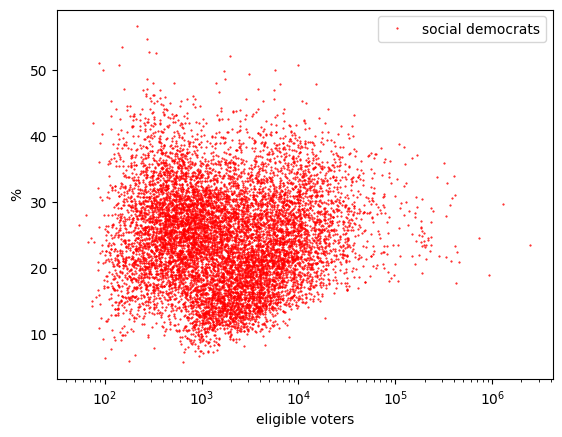

In [25]:
plt.plot(wdf2['eligible_voters'],100*wdf2['social_democrats_party_votes']/wdf2['valid_party_votes'],'o',ms=0.5,color='red',label='social democrats') 
plt.legend(loc="best")
plt.xlabel("eligible voters")
plt.ylabel("%")
#plt.yscale("log")
plt.xscale("log")

Now Berlin and Hamburg are included. 

In [26]:

comb1=cdf2.merge(wdf2,left_on='Name',right_on='Gemeinde Name')  
print(comb1.shape)

(10034, 547)


In [27]:
print((comb1.kreis_id-comb1.e_kreis_id).describe())#most dont match but anyway not really needed, enough when census kreis numbers are fine 
print(comb1.e_kreis_id)

count    1.003400e+04
mean    -6.619331e+04
std      4.799488e+05
min     -4.201866e+07
25%     -6.041475e+04
50%     -1.607200e+04
75%      0.000000e+00
max      1.393900e+04
dtype: float64
0         66066
1        213426
2        222666
3         58232
4         10510
          ...  
10029     16077
10030     16077
10031     48231
10032     16077
10033     16077
Name: e_kreis_id, Length: 10034, dtype: int64


We are first looking on voters properties to check for problems. First, we compare eleigible voters and population which should be similar. 

number of communities 10034
number of communities between factor 0.5 and 2: 9683


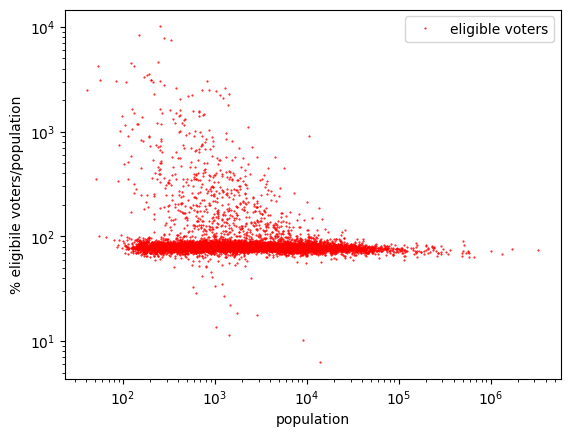

In [28]:
plt.plot(comb1['population'],100*comb1['eligible_voters']/comb1['population'],'o',ms=0.5,color='red',label='eligible voters') 
plt.legend(loc="best")
plt.xlabel("population")
plt.ylabel("% eligibile voters/population")
plt.yscale("log")
plt.xscale("log")
print(f"number of communities {len(comb1.population)}")
print(f"number of communities between factor 0.5 and 2: {comb1.population[(comb1['eligible_voters']/comb1['population']>0.5) & (comb1['eligible_voters']/comb1['population']<2)].count()}")

Most seem have worked. Some not, but they are rather small and are thus more likely affected by something like changes by changes in the border of communities or name missmatches. 
We are defining the borders per eye which we use the select communities with good data. 

median is 79.4046
16% quantile is 75.068
84% quantile is 85.2139
5% quantile is 71.563
95% quantile is 128.9256
We use as borders 110 to 55
That is a factor 1.3854 larger and a factor 1.4436 smaller than the median.


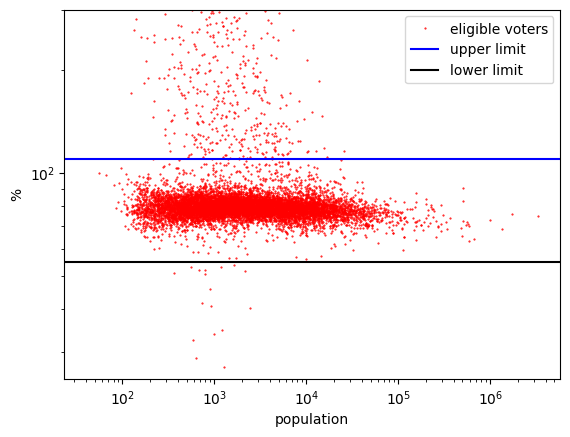

In [29]:
plt.plot(comb1['population'],100*comb1['eligible_voters']/comb1['population'],'o',ms=0.5,color='red',label='eligible voters') 
plt.axhline(y=110, color='b', linestyle='-', label='upper limit')
plt.axhline(y=55, color='k', linestyle='-', label='lower limit')
plt.legend(loc="best")
plt.xlabel("population")
plt.ylabel("%")
plt.yscale("log")
plt.xscale("log")
plt.ylim(25,300)
print(f"median is {round(np.median(100*comb1['eligible_voters']/comb1['population']),4)}")
print(f"16% quantile is {round(np.quantile(100*comb1['eligible_voters']/comb1['population'],0.1585),4)}")
print(f"84% quantile is {round(np.quantile(100*comb1['eligible_voters']/comb1['population'],1-0.1585),4)}")
print(f"5% quantile is {round(np.quantile(100*comb1['eligible_voters']/comb1['population'],0.05),4)}")
print(f"95% quantile is {round(np.quantile(100*comb1['eligible_voters']/comb1['population'],1-0.05),4)}")
print("We use as borders 110 to 55")
print(f"That is a factor {round(110/79.4,4)} larger and a factor {round(79.4/55,4)} smaller than the median.")
#in principlee should be german over 18 but is less complete

We are now looking on the valid votes as function of voters. That checks for communities were votes are mssing because the mail votes were counted elsewhere. Since it is known that the mail votes is diffent from the local vote, those communities are best excluded. We define the border per eye to select the communities with the good data. 

number of communities in census + election data 10034
number of communities in census + election data after excluding population miss matches 9405
number of communities in census + election data after also excluding mssing mail votes 5098
population in census + election data 77204723
population in census + election data after excluding population miss matches 76100656
population in census + election data after also excluding mssing mail votes 71064974


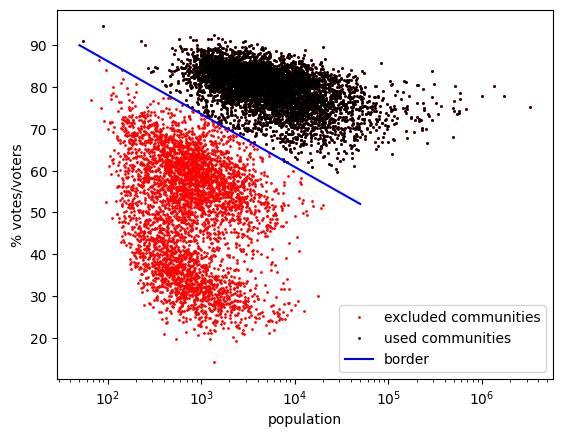

In [30]:
sel=comb1[(abs(100*comb1['eligible_voters']/comb1['population']-82.5)<27.5)].copy()
sel2=comb1[(abs(100*comb1['eligible_voters']/comb1['population']-82.5)<27.5) & (100*comb1['voters']/comb1['eligible_voters']>90-38/3*np.log10(comb1['population']/50))].copy()
li=np.zeros((2,2))
li[0,0]=90
li[0,1]=52
li[1,1]=50000
li[1,0]=50
plt.plot(sel['population'],100*sel['voters']/sel['eligible_voters'],'o',ms=1,color='red',label='excluded communities')
plt.plot(sel2['population'],100*sel2['voters']/sel2['eligible_voters'],'o',ms=1,color='black',label='used communities')
plt.plot(li[1],li[0],'-',ms=1,color='blue',label='border')
plt.legend(loc="best")
plt.xlabel("population")
plt.ylabel("% votes/voters")
#plt.xlim(0,30000)
plt.xscale("log")
print(f"number of communities in census + election data {len(comb1)}")
print(f"number of communities in census + election data after excluding population miss matches {len(sel)}")
print(f"number of communities in census + election data after also excluding mssing mail votes {len(sel2)}")

print(f"population in census + election data {comb1.population.sum()}")
print(f"population in census + election data after excluding population miss matches {sel.population.sum()}")
print(f"population in census + election data after also excluding mssing mail votes {sel2.population.sum()}")

About half the communities are excluded due to the two slection. However, they only consist of about 10% of the population. Oftenk, also the census data is less reliable for the small suuch that the impact on the result below is reduced also due to this aspect. 

The total population is about 8 million less than in should. We now check whather the reason is concentrated in some states (land) or whether it is more a random problem.

completeness per State
land_name
Baden-Württemberg         0.997110
Bayern                    0.994793
Berlin                    1.000000
Brandenburg               0.915416
Bremen                    1.000000
Hamburg                   1.000000
Hessen                    0.931676
Mecklenburg-Vorpommern    0.873715
Niedersachsen             0.963581
Nordrhein-Westfalen       0.956036
Rheinland-Pfalz           0.962308
Saarland                  1.000000
Sachsen                   0.895557
Sachsen-Anhalt            0.981722
Schleswig-Holstein        0.981725
Thüringen                 0.830952
Name: population, dtype: float64
checking for nan
kreis_name
Spree-Neiße                0.164131
Oberspreewald-Lausitz      0.401660
Bautzen                    0.481620
Güstrow                    0.552913
Uelzen                     0.600998
Ilm-Kreis                  0.603773
Groß-Gerau                 0.617514
Wartburgkreis              0.624360
Kyffhäuserkreis            0.626298
Waldeck-Frankenberg   

Text(0, 0.5, 'completenss in election data %')

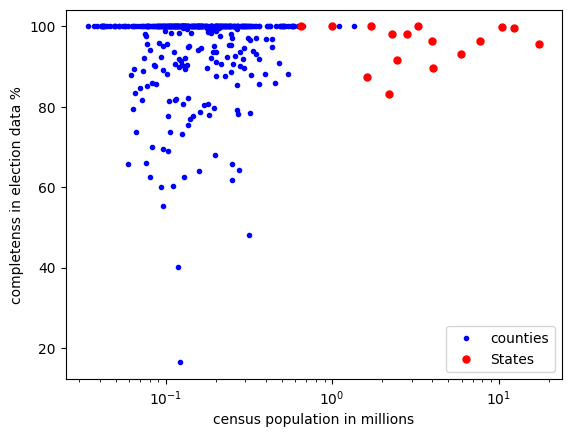

In [31]:
t=cdf2.population.groupby(cdf2['land_name']).sum()
u=comb1.population.groupby(comb1['land_name']).sum()
t2=cdf2.population.groupby(cdf2['kreis_name']).sum()
print("completeness per State")
print(u/t)
u2=comb1.population.groupby(comb1['kreis_name']).sum()
x2=u2/t2
print("checking for nan")
print(x2.sort_values()[0:20])
print("still some low matches")
print(x2.sort_values()[380:422]) #some nan why? and do they matter? robbaly Rostock and co contrinbute to problem 
print("lowest matches are in the region were sorbic names are used also")
plt.plot(t2/10**6,100*u2/t2,'o',ms=3,color='blue',label='counties') 
plt.plot(t/10**6,100*u/t,'o',ms=5,color='red',label='States') 
plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("census population in millions")
plt.ylabel("completenss in election data %")

In [32]:
#checking cities which have nan matches now fine
s4=wdf2[wdf2['Gemeinde Name'].str.contains('Solingen')]
print(s4['Gemeinde Name'])
print(cdf2.Name[cdf2['Name'].str.contains('Solingen')])
s4=wdf2[wdf2['Gemeinde Name'].str.contains('Rostock')]
print(s4['Gemeinde Name'])
print(cdf2.Name[cdf2['Name'].str.contains('Rostock')])
s4=wdf2[wdf2['Gemeinde Name'].str.contains('Cottbus')]
print(s4['Gemeinde Name'])
print(cdf2.Name[cdf2['Name'].str.contains('Cottbus')])
s4=wdf2[wdf2['Gemeinde Name'].str.contains('Greifswald')]
print(s4['Gemeinde Name'])
print(cdf2.Name[cdf2['Name'].str.contains('Greifswald')])
s4=wdf2[wdf2['Gemeinde Name'].str.contains('Hagen')]
print(s4['Gemeinde Name'])
print(cdf2.Name[cdf2['Name'].str.contains('Hagen')])
s4=wdf2[wdf2['Gemeinde Name'].str.contains('Heilbronn')]
print(s4['Gemeinde Name'])
print(cdf2.Name[cdf2['Name'].str.contains('Heilbronn')])
s4=wdf2[wdf2['Gemeinde Name'].str.contains('Neubrandenburg')]
print(s4['Gemeinde Name'])
print(cdf2.Name[cdf2['Name'].str.contains('Neubrandenburg')])

9135    Solingen, Stadt
Name: Gemeinde Name, dtype: object
2151    Solingen, Stadt
Name: Name, dtype: object
8348    Rostock, Hansestadt
Name: Gemeinde Name, dtype: object
8902    Rostock, Hansestadt
Name: Name, dtype: object
2206    Cottbus, Stadt
Name: Gemeinde Name, dtype: object
8482    Cottbus, Stadt
Name: Name, dtype: object
3720    Greifswald, Hansestadt
Name: Gemeinde Name, dtype: object
8900    Greifswald, Hansestadt
Name: Name, dtype: object
1314    Briefwahl Amt Hagenow-Land
4060                         Hagen
4061     Hagen am Teutoburger Wald
4062           Hagen im Bremischen
4063                  Hagen, Stadt
4064              Hagenbach, Stadt
4065            Hagenburg, Flecken
4066                  Hagenbüchach
4067                Hagenow, Stadt
Name: Gemeinde Name, dtype: object
867                         Hagen
1523           Hagenburg, Flecken
1587          Hagen im Bremischen
2079    Hagen am Teutoburger Wald
2458                 Hagen, Stadt
4849             Hagenba

In [33]:

cdf3=cdf.loc[cdf['Reg_Hier']=='Stadtkreis/kreisfreie Stadt/Landkreis'].copy()
print(f"number of Kreis {len(cdf3)}")

#add name 
cdf3.loc[:,'kreis_name']=cdf3.loc[:,'Name']
#create new kreis-id as key because old is only unique within each Land and RB_NUTS2
cdf3.loc[:,'kreis_id']=cdf3.loc[:,'RS_Kreis']+100*cdf3.loc[:,'RS_RB_NUTS2']+1000*cdf3.loc[:,'RS_Land']

number of Kreis 412


In [34]:
#census data fro kreis

u2b=comb1.groupby(comb1['kreis_name']).sum()
#Kreis level census data
print(cdf3.shape)
#should be passed as option to communities where it is not avaialble (o.k. firstsubtract cities)
#length are slightly different 
print(u2b.shape)

cdf3 = cdf3.set_index('kreis_name')
#diff does now work because index is set to key
#but -1 and -2 are used in group by
diff=cdf3-u2b

print(cdf2.PhD_and_MD[cdf2.kreis_name=='Breisgau-Hochschwarzwald'])
print(cdf2.qual_PhD_and_MD[cdf2.kreis_name=='Breisgau-Hochschwarzwald'])
print(cdf3.PhD_and_MD[cdf3.index=='Breisgau-Hochschwarzwald'])
print(u2b.PhD_and_MD[u2b.index=='Breisgau-Hochschwarzwald'])
print(diff.PhD_and_MD[diff.index=='Breisgau-Hochschwarzwald'])
#belows does not get mssing population unsurprsing, need to get seperately for each property also need to ignore -
print(cdf3.population[cdf3.index=='Breisgau-Hochschwarzwald'])
print(u2b.population[u2b.index=='Breisgau-Hochschwarzwald'])
print(diff.population[diff.index=='Breisgau-Hochschwarzwald'])
#seems work to get it right, I just use the existing columns plus what is also in kreis level to get the others? 
#also -1 are counted currently not right
#something wrong is not final 

(412, 441)
(398, 481)
5825     -1
5826     -2
5827     -1
5828    200
5829     -1
5830     -2
5831     -1
5832     -1
5833     -1
5834     -1
5835     -1
5836     -1
5837     -1
5838     -1
5839    370
5840     -1
5841     -1
5842     -1
5843     -1
5844     -1
5845     -1
5846     -1
5847     -1
5848     -1
5849     -1
5850     -1
5851     -1
5852     -1
5853     -1
5854     -1
5855     -1
5856     -1
5857     -1
5858     -1
5859     -1
5860     -1
5861    200
5862     -1
5863     -1
5864     -1
5865     -1
5866     -1
5867     -1
5868     -1
5869     -1
5870     -1
5871     -1
5872     -1
5873     -1
5874     -2
Name: PhD_and_MD, dtype: int64
5825      NaN
5826    False
5827      NaN
5828    False
5829      NaN
5830    False
5831      NaN
5832      NaN
5833      NaN
5834      NaN
5835      NaN
5836      NaN
5837      NaN
5838      NaN
5839    False
5840      NaN
5841      NaN
5842      NaN
5843      NaN
5844      NaN
5845      NaN
5846      NaN
5847      NaN
5848      NaN
5849      N

/tmp/ipykernel_10467/3204309623.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  u2b=comb1.groupby(comb1['kreis_name']).sum()


In [35]:

plt.plot(cdf3['population'],cdf3['PhD_and_MD']/cdf3['population'],'o',ms=0.5,color='black',label='christian union') 
plt.legend(loc="best")
plt.xlabel("population")
plt.ylabel("% Doctors")
#plt.yscale("log")
#plt.xscale("log")

Text(0, 0.5, '% Doctors')

There is variation between the states, but all have at least 65% completeness. The smallest completeness is Mechlenburg-Vorpommern where there was a  administration reform affecting communities and county borders. On the county level the completeness is at least about 20%.

Now we are looking on other census data which is useful for checking the data but more useless of analysis and predictions. We start with a known correlation as test. Catholic against christin union parties. We combined both as usual, because they do not compete with each other and form a parlimentary group together

Text(0, 0.5, '% christian unions')

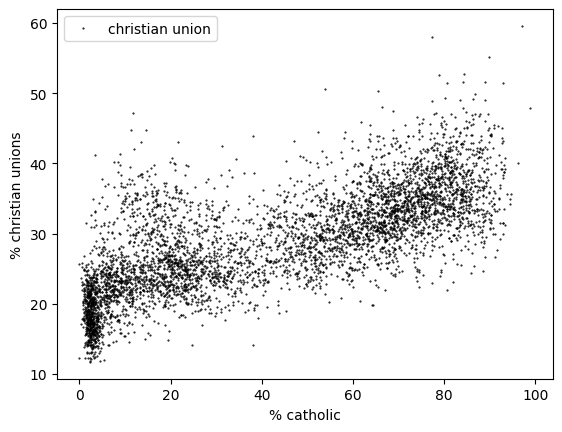

In [36]:

#combining the two christain unions
comb1.loc[:,'christian_unions_party_votes']=comb1.loc[:,'christian_socials_party_votes']+comb1.loc[:,'christian_democrats_party_votes']
comb1.loc[:,'christian_unions_person_votes']=comb1.loc[:,'christian_socials_person_votes']+comb1.loc[:,'christian_democrats_person_votes']

sel2.loc[:,'christian_unions_party_votes']=sel2.loc[:,'christian_socials_party_votes']+sel2.loc[:,'christian_democrats_party_votes']
sel2.loc[:,'christian_unions_person_votes']=sel2.loc[:,'christian_socials_person_votes']+sel2.loc[:,'christian_democrats_person_votes']

plt.plot(100*sel2['religion_catholic']/sel2['population'],100*sel2['christian_unions_party_votes']/sel2['valid_party_votes'],'o',ms=0.5,color='black',label='christian union') 
plt.legend(loc="best")
plt.xlabel("% catholic")
plt.ylabel("% christian unions")
#plt.yscale("log")
#plt.xscale("log")

As expected there are more votes for the christian union where a large part is catholic. 

We are now checking for quality of the census properties, we always exclude already the communities for which the election data is bad. First we look on catholic again. 

In [37]:
print(f" total number of communities {sel2.eligible_voters.count()}")
print(f" total number of communites with reliable catholic data {sel2.eligible_voters[(sel2.religion_catholic>-0.5) & (sel2.qual_religion_catholic!=1)].count()}")

print(f" total number of eligible voters {sel2.eligible_voters.sum()}")
print(f" total number of eligible voters with reliable catholic data {sel2.eligible_voters[(sel2.religion_catholic>-0.5) & (sel2.qual_religion_catholic!=1)].sum()}")


 total number of communities 5098
 total number of communites with reliable catholic data 4996
 total number of eligible voters 54177266
 total number of eligible voters with reliable catholic data 53898796


There is no problem there, now we look on all census properties below. 

In [38]:
print(column_names[8])
xs=8
print(f"census properties start at {xs}")
stat=np.empty((9,len(column_names)))
stat[1,:]=sel2.eligible_voters.sum()
stat[4,:]=sel2.eligible_voters.count()
for i in range (xs, 223):
    stat[0,i]=i
    stat[2,i]=sel2.eligible_voters[(sel2[column_names[i]]>-0.5)].sum()
    stat[3,i]=sel2.eligible_voters[(sel2[column_names[i]]>-0.5) & (sel2['qual_'+column_names[i]]!=1)].sum()  
    stat[5,i]=sel2.eligible_voters[(sel2[column_names[i]]>-0.5)].count()
    stat[6,i]=sel2.eligible_voters[(sel2[column_names[i]]>-0.5) & (sel2['qual_'+column_names[i]]!=1)].count()
    stat[7,i]=sel2[column_names[i]][(sel2[column_names[i]]>-0.5)].sum() 
    stat[8,i]=sel2[column_names[i]][(sel2[column_names[i]]>-0.5) & (sel2['qual_'+column_names[i]]!=1)].sum()     
print(f"smallest reliable voter number is {min(stat[6,xs:len(column_names)])}")
print(f"smallest reliable voter property is {column_names[np.argmin(stat[6,xs:len(column_names)])+8]}")

population
census properties start at 8
smallest reliable voter number is 1.0
smallest reliable voter property is migration_regions_nan


Now we plot them all. 

Text(0, 0.5, '% of eligible voters w information')

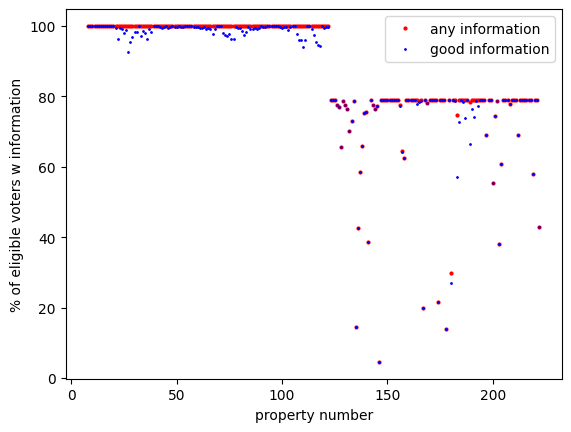

In [39]:
plt.plot(stat[0,xs:len(column_names)],100*stat[2,xs:len(column_names)]/stat[1,xs:len(column_names)],'o',ms=2,color='red',label='any information') 
plt.plot(stat[0,xs:len(column_names)],100*stat[3,xs:len(column_names)]/stat[1,xs:len(column_names)],'o',ms=1,color='blue',label='good information') 
plt.legend(loc="best")
plt.xlabel("property number")
plt.ylabel("% of eligible voters w information")

Before 120 the information is partly available for all. After it not. That is more visisble for communities, see below. 

[5098. 5098. 5098. 1472. 1472. 1468. 1410. 1376.  993. 1457.]
including 122 there is most information there


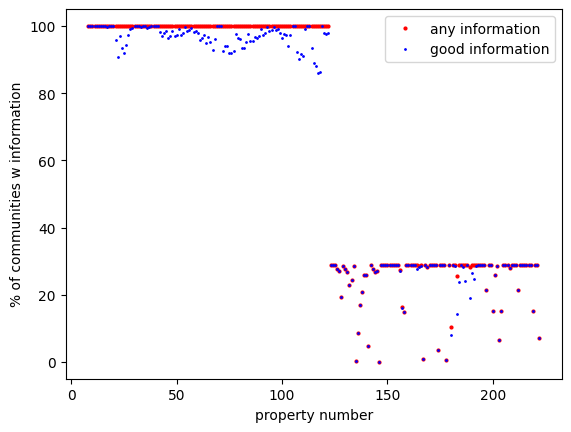

In [40]:
plt.plot(stat[0,xs:len(column_names)],100*stat[5,xs:len(column_names)]/stat[4,xs:len(column_names)],'o',ms=2,color='red',label='any information') 
plt.plot(stat[0,xs:len(column_names)],100*stat[6,xs:len(column_names)]/stat[4,xs:len(column_names)],'o',ms=1,color='blue',label='good information') 
plt.legend(loc="best")
plt.xlabel("property number")
plt.ylabel("% of communities w information")
print(stat[5,120:130])
print("including 122 there is most information there")
#setting until when most information is there 
xb=123

Now we check which properties have especially little information, the ones where less than 10000 communities have data.

In [41]:
#looking at the ince with at least a limit of 10000, at most 1462 units (could add about 300 by using counties minus towns in them )
for i in range (xb,len(column_names)):
    if(stat[6,i]<1000):
        print(column_names[i])
        print(f"available for {round(stat[3,i]/10**6,3)} millions eligibile voters")
        print(f"available for {int(stat[6,i])} communities")        
        print(f"available for {round(100*stat[3,i]/max(stat[3,xb:len(column_names)]),2)} % of eligible voters")
        print(" ")
#some have few     but not many and often not directly important like migrations, and school based and misisng data ones  

migration_background_foreign_german_born
available for 35.615 millions eligibile voters
available for 993 communities
available for 83.24 % of eligible voters
 
migration_56-59
available for 7.883 millions eligibile voters
available for 12 communities
available for 18.43 % of eligible voters
 
migration_60-69
available for 23.087 millions eligibile voters
available for 445 communities
available for 53.96 % of eligible voters
 
migration_70-79
available for 31.673 millions eligibile voters
available for 857 communities
available for 74.03 % of eligible voters
 
migration_year_nan
available for 20.873 millions eligibile voters
available for 248 communities
available for 48.79 % of eligible voters
 
migration_regions_nan
available for 2.469 millions eligibile voters
available for 1 communities
available for 5.77 % of eligible voters
 
unemployed_male
available for 34.772 millions eligibile voters
available for 822 communities
available for 81.27 % of eligible voters
 
unemployed_female
av

We look on some of rare properties which are relative different from others, to see whether there is a signal visisble. 

(0.0, 7.0)

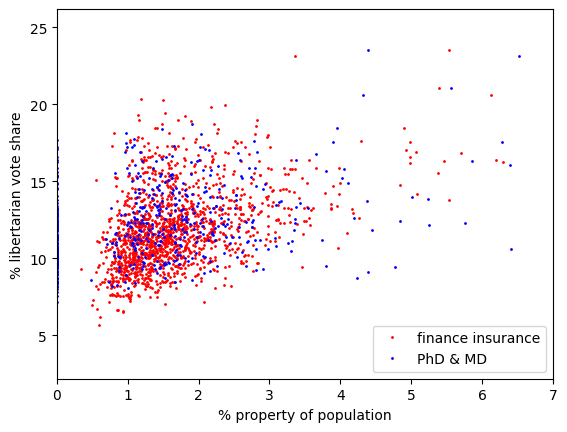

In [42]:

plt.plot(100*sel2['finance_insurance']/sel2['population'],100*sel2['libertarians_party_votes']/sel2['valid_party_votes'],'o',ms=1,color='red',label='finance insurance') 
plt.plot(100*sel2['PhD_and_MD']/sel2['population'],100*sel2['libertarians_party_votes']/sel2['valid_party_votes'],'o',ms=1,color='blue',label='PhD & MD') 
plt.legend(loc="best")
plt.xlabel("% property of population")
plt.ylabel("% libertarian vote share")
plt.xlim(0,7)
#plt.xscale("log")
#plt.yscale("log")
#although insuarnce seem not useless 
#to be removed later
#print(sel2[sel2.Name.str.contains('Garching')])
#print(sel2.libertarians_party_votes[sel2.Name.str.contains('Garching')])
#print(sel2.valid_party_votes[sel2.Name.str.contains('Garching')])
#print(sel2.Name[(sel2['PhD_and_MD']/sel2['population']).idxmax()])

There are still relations visisble, thus it would be good to use a method which can deal with misisng data in a way should does not result into omitting it totally. 

The information is mostly complete until property 123. Therefore, we are now looking on all properties in columns 8 to 123. We will exclude the ones which are on properties which non voters like non citizen and citizens below 18, duplicates and properties which just summarize for how many of one category there is any information. There are also two age grouping in total, we use which has one border below 17 to exclude non voeters. 

In [43]:
for i in range(8,123):
    print(f"{i} {column_names[i]}")
    #list to include
pop=np.zeros((3,57))
pop[2]=np.arange(0,57,1)
listg1=column_names[10:12]
pop[0,0:2]=stat[8,10:12]
for i in range (15, 39):
    listg1.append(column_names[i])
    pop[0,2+(i-15)]=stat[8,i]
for i in range (84, 105):
    listg1.append(column_names[i])
    pop[0,26+(i-84)]=stat[8,i]    
listg1.append(column_names[106])
pop[0,47]=stat[8,106] 
for i in range (113, 119):
    listg1.append(column_names[i])
    pop[0,48+(i-113)]=stat[8,i] 
for i in range (120, 123):
    listg1.append(column_names[i])
    pop[0,54+(i-120)]=stat[8,i]     
print(f"included properties are {listg1}")
print(f"the number of properties is {len(listg1)}")
#get fraction of total population
pop[1]=pop[0]/sel2.population.sum()
print(f"smallest population fraction {min(pop[1])}")
print(f"largest population fraction {max(pop[1])}")

8 population
9 gender_total
10 male
11 female
12 marital_status_total
13 marital_status_male
14 marital_status_female
15 single_total
16 single_male
17 single_female
18 married_total
19 married_male
20 married_female
21 widowed_total
22 widowed_male
23 widowed_female
24 divorced_total
25 divorced_male
26 divorced_female
27 civil_union_total
28 civil_union_male
29 civil_union_female
30 civil_union_widowed_total
31 civil_union_widowed_male
32 civil_union_widowed_female
33 civil_union_divorced_total
34 civil_union_divorced_male
35 civil_union_divorved_female
36 not_specified_total
37 not_specified_male
38 not_specified_female
39 age_groups1_total
40 age_groups1_male
41 age_groups1_female
42 0_9_total
43 0_9_male
44 0_9_female
45 10_19_total
46 10_19_male
47 10_19_female
48 20_29_total
49 20_29_male
50 20_29_female
51 30_39_total
52 30_39_male
53 30_39_female
54 40_49_total
55 40_49_male
56 40_49_female
57 50_59_total
58 50_59_male
59 50_59_female
60 60_69_total
61 60_69_male
62 60_69_fema

That includes marital status data, age data, citizen data and religion data. It does not include more detailed migration data, economic or eduction data

We now add in addition properties above 123, excluding the same types of information. We also exclude categories where the information is avaibale for less than 200 communities.

In [44]:
pop2=np.zeros((3,122))
pop2[2]=np.arange(0,122,1)
listg1b=listg1.copy()
pop2[0,0:57]=pop[0,0:57]
#to exclude properties are 
listex=['branch_nan','migration_background_all','migration_all_years','migration_56-59','migration_year_nan','migration_regions_nan','employment_status_all','employment_status_male','employment_status_female','profession_status_all','helpers_family','profession_all','agriculture_trained','soldier','branches','in_education_level_total','in_education_primary','in_education_secondary1','in_education_secondary2','in_education_school_form_total','in_education_elementary','in_education_secondary_basic','in_education_secondary_middle','in_education_grammar','in_education_secondary_general','in_education_school_other','profession_education_total','not_and_not_yet_educated','educated_school_15_and_older','school_time_not_finished','middle_secondary','in_grammar_school','other_services','sale_car_repaing_dining_traffic_communication','production']
print(len(listex))
c2=0
for i in range (123, len(column_names)):
    print(column_names[i])
    print(stat[6,i])
    c=0
    for j in range(len(listex)):
        if column_names[i]==listex[j]:
            c=1
    if c==0:
        listg1b.append(column_names[i])
        pop2[0,c2+57]=stat[8,i]
        c2+=1
   
print(f"included properties are {listg1b}")
print(f"number of added properties {c2}")
print(f"number of total properties is {len(listg1b)}")
pop2[1]=pop2[0]/sel2.population.sum()
print(pop2.T)

35
migration_background_all
1472.0
migration_background_no
1472.0
migration_background_yes
1468.0
migration_background_foreign_all
1410.0
migration_background_foreign_foreign_born
1376.0
migration_background_foreign_german_born
993.0
migration_background_german_all
1457.0
migration_background_german_foreign_born
1408.0
migration_background_german_german_born
1367.0
migration_background_german_german_born_mig_2parents
1169.0
migration_background_german_german_born_mig_1parents
1240.0
migration_all_years
1452.0
migration_56-59
12.0
migration_60-69
445.0
migration_70-79
857.0
migration_80-89
1063.0
migration_90-99
1317.0
migration_00-11
1313.0
migration_year_nan
248.0
migration_all_regions
1468.0
migration_eu27
1414.0
migration_rest_europes
1362.0
migration_other_continents
1386.0
migration_regions_nan
1.0
employment_status_all
1472.0
employment_status_male
1472.0
employment_status_female
1472.0
employment_prefering_all
1472.0
employment_prefered_male
1472.0
employment_preferred_female
14

We are now calculating the correlation for all of them and the votes of the 6 major parties which made it into parliament. 

We add all other parties together to be able to look also on them. 

In [45]:
#We get other parties total by using valid votes minus main parties, since requires less operation than adding up all others
comb1.loc[:,'others_party_votes']=comb1.loc[:,'valid_party_votes']-comb1.loc[:,'christian_unions_party_votes']-comb1.loc[:,'social_democrats_party_votes']-comb1.loc[:,'alternative_for_germany_party_votes']-comb1.loc[:,'libertarians_party_votes']-comb1.loc[:,'greens_party_votes']-comb1.loc[:,'lefts_party_votes']
comb1.loc[:,'others_person_votes']=comb1.loc[:,'valid_person_votes']-comb1.loc[:,'christian_unions_person_votes']-comb1.loc[:,'social_democrats_person_votes']-comb1.loc[:,'alternative_for_germany_person_votes']-comb1.loc[:,'libertarians_person_votes']-comb1.loc[:,'greens_person_votes']-comb1.loc[:,'lefts_person_votes']

sel2.loc[:,'others_person_votes']=sel2.loc[:,'valid_person_votes']-sel2.loc[:,'christian_unions_person_votes']-sel2.loc[:,'social_democrats_person_votes']-sel2.loc[:,'alternative_for_germany_person_votes']-sel2.loc[:,'libertarians_person_votes']-sel2.loc[:,'greens_person_votes']-sel2.loc[:,'lefts_person_votes']
sel2.loc[:,'others_party_votes']=sel2.loc[:,'valid_party_votes']-sel2.loc[:,'christian_unions_party_votes']-sel2.loc[:,'social_democrats_party_votes']-sel2.loc[:,'alternative_for_germany_party_votes']-sel2.loc[:,'libertarians_party_votes']-sel2.loc[:,'greens_party_votes']-sel2.loc[:,'lefts_party_votes']

We caluclate all correlations of the fractions relative to eligible voters. Thus, our correlation include also variations in turnout. 

In [46]:
#list of the used parties and voters
listp=['voters','not_valid_party_votes','valid_party_votes','christian_unions_party_votes','social_democrats_party_votes','alternative_for_germany_party_votes',
'libertarians_party_votes', 'lefts_party_votes','greens_party_votes','others_party_votes']
print(listp)

['voters', 'not_valid_party_votes', 'valid_party_votes', 'christian_unions_party_votes', 'social_democrats_party_votes', 'alternative_for_germany_party_votes', 'libertarians_party_votes', 'lefts_party_votes', 'greens_party_votes', 'others_party_votes']


In [47]:
corr1=np.zeros((11,len(listg1b),3))

for j in range(len(listg1b)):
    print(j, listg1b[j])
    sel=sel2[(comb1[listg1b[j]]>-0.5) & (comb1['qual_'+listg1b[j]]!=1)].copy()
    selw=sel2[(comb1[listg1b[j]]>-0.5) & (comb1['qual_'+listg1b[j]]!=1) & (comb1['unification']=='West')].copy()
    sele=sel2[(comb1[listg1b[j]]>-0.5) & (comb1['qual_'+listg1b[j]]!=1) & (comb1['unification']=='East')].copy()
    corr1[10,j,0]=len(sel)
    corr1[10,j,1]=len(selw)
    corr1[10,j,2]=len(sele)    
    for i in range(10):
        s1=sel[listp[i]]/sel['eligible_voters']
        s2=sel[listg1b[j]]/sel['population']
        s1w=selw[listp[i]]/selw['eligible_voters']
        s2w=selw[listg1b[j]]/selw['population']
        s1e=sele[listp[i]]/sele['eligible_voters']
        s2e=sele[listg1b[j]]/sele['population']        
        corr1[i,j,0]=s1.corr(s2, method='pearson')
        corr1[i,j,1]=s1w.corr(s2w, method='pearson')        
        corr1[i,j,2]=s1e.corr(s2e, method='pearson')

0 male
1 female
2 single_total
3 single_male
4 single_female


/tmp/ipykernel_10467/3795833765.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sel=sel2[(comb1[listg1b[j]]>-0.5) & (comb1['qual_'+listg1b[j]]!=1)].copy()
/tmp/ipykernel_10467/3795833765.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  selw=sel2[(comb1[listg1b[j]]>-0.5) & (comb1['qual_'+listg1b[j]]!=1) & (comb1['unification']=='West')].copy()
/tmp/ipykernel_10467/3795833765.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sele=sel2[(comb1[listg1b[j]]>-0.5) & (comb1['qual_'+listg1b[j]]!=1) & (comb1['unification']=='East')].copy()


5 married_total
6 married_male
7 married_female
8 widowed_total
9 widowed_male
10 widowed_female
11 divorced_total
12 divorced_male
13 divorced_female
14 civil_union_total
15 civil_union_male
16 civil_union_female
17 civil_union_widowed_total
18 civil_union_widowed_male
19 civil_union_widowed_female
20 civil_union_divorced_total
21 civil_union_divorced_male
22 civil_union_divorved_female
23 not_specified_total
24 not_specified_male
25 not_specified_female
26 total_18_24
27 male_18_24
28 female_18_24
29 total_25_29
30 male_25_29
31 female_25_29
32 total_30_39
33 male_30_39
34 female_30_39
35 total_40_49
36 male_40_49
37 female_40_49
38 total_50_64
39 male_50_64
40 female_50_64
41 total_65_74
42 male_65_74
43 female_65_74
44 total_75_and_older
45 male_75_and_older
46 female_75_and_older
47 citizen_german
48 birth_country_germany
49 birth_country_foreign
50 birth_country_eu27
51 birth_country_other_europe
52 birth_country_other_continents
53 birth_country_other
54 religion_catholic
55 rel

/home/tobias/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/tobias/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


74 migration_rest_europes
75 migration_other_continents
76 employment_prefering_all
77 employment_prefered_male
78 employment_preferred_female
79 employed_all
80 employed_male
81 employed_female
82 unemployed_all
83 unemployed_male
84 unemployed_female
85 not_employable_all
86 not_employable_male
87 not_employable_female
88 worker_employee
89 officier
90 self-employed_single
91 self_employed_company
92 manager
93 academic
94 technical_trained
95 office
96 sale
97 tradesman
98 workers
99 unskilled_laborers
100 agriculture
101 mining_and_industry
102 distribution
103 building
104 sale_car_repair_dining
105 traffic_communication
106 finance_insurance
107 real_estate_science
108 public_administration
109 public_private_services
110 no_school_certificate
111 basic_secondary
112 middle_secondary_finished
113 qualified_for_community_college
114 qualified_for_university
115 no_profession_education
116 apprenticeship
117 professional_school
118 professional_academy
119 community_college
120 uni

For each election property we look onto the largest positive and negative correlations and the ones with the smallest absolute value. The latter implies no correlation. 

In [48]:
#categories of each features 
cat=['sex','sex','mstatus','mstatus-sex','mstatus-sex','mstatus','mstatus-sex','mstatus-sex','mstatus','mstatus-sex','mstatus-sex','mstatus','mstatus-sex','mstatus-sex','mstatus','mstatus-sex','mstatus-sex','mstatus','mstatus-sex','mstatus-sex','mstatus','mstatus-sex','mstatus-sex','mstatus','mstatus-sex','mstatus-sex','age','age-sex','age-sex','age','age-sex','age-sex','age','age-sex','age-sex','age','age-sex','age-sex','age','age-sex','age-sex','age','age-sex','age-sex','age','age-sex','age-sex','citizen','birth_country','birth_country','birth_country','birth_country','birth_country','birth_country','religion','religion','religion','migration','migration','migration-citizen','migration-citizen-birth_country','migration-citizen-birth_country','migration-citizen','migration-citizen-birth_country','migration-citizen-birth_country','migration-citizen-birth_country-parents','migration-citizen-birth_country-parents','migration-time','migration-time','migration-time','migration-time','migration-time','migration-region','migration-region','migration-region','migration-region','employment','employment-sex','employment-sex','employment','employment-sex','employment-sex','employment','employment-sex','employment-sex','employment','employment-sex','employment-sex','work_position','work_position','work_position','work_position','work_type','work_type','work_type','work_type','work_type','work_type','work_type','work_type','branch','branch','branch','branch','branch','branch','branch','branch','branch','branch','school','school','school','school','school','education','education','education','education','education','education','education']

for i in range(len(listg1b)):
    print(f"feature {listg1b[i]} is category {cat[i]}")
    
cat1=[]
for i in range(len(cat)):
    a=cat[i]
    b=a.split("-")[0] 
    print(b)
    cat1.append(b)
print(cat1)    
mycat1=np.sort(list(set(cat1)))
print(mycat1)

feature male is category sex
feature female is category sex
feature single_total is category mstatus
feature single_male is category mstatus-sex
feature single_female is category mstatus-sex
feature married_total is category mstatus
feature married_male is category mstatus-sex
feature married_female is category mstatus-sex
feature widowed_total is category mstatus
feature widowed_male is category mstatus-sex
feature widowed_female is category mstatus-sex
feature divorced_total is category mstatus
feature divorced_male is category mstatus-sex
feature divorced_female is category mstatus-sex
feature civil_union_total is category mstatus
feature civil_union_male is category mstatus-sex
feature civil_union_female is category mstatus-sex
feature civil_union_widowed_total is category mstatus
feature civil_union_widowed_male is category mstatus-sex
feature civil_union_widowed_female is category mstatus-sex
feature civil_union_divorced_total is category mstatus
feature civil_union_divorced_male

In [49]:
#ger mean and co coeffeicent of the categories
#could create data frame for that all  
catcor=np.zeros((5,len(mycat1),3))
for i in range(len(mycat1)):
    car=np.zeros((3),int)

    ar=np.zeros((24,10,3))
    for j in range(len(listg1b)):
        for k in range(3):
            if cat1[j]==mycat1[i] and corr1[10,j,k]>20:  #only when at least 20 with data
                ar[int(car[k]),:,k]=corr1[0:10,j,k]
                car[k]+=1 
    for j in range(3):
        catcor[0,i,j]=np.mean(abs(ar[0:int(car[k]),0:10,j]))
        catcor[1,i,j]=np.std(abs(ar[0:car[k],0:10,j]))
        catcor[2,i,j]=np.median(abs(ar[0:car[k],0:10,j]))
        catcor[3,i,j]=np.quantile(abs(ar[0:car[k],0:10,j]),0.25)       
        catcor[4,i,j]=np.quantile(abs(ar[0:car[k],0:10,j]),0.75)               

Text(0.5, 1.0, '')

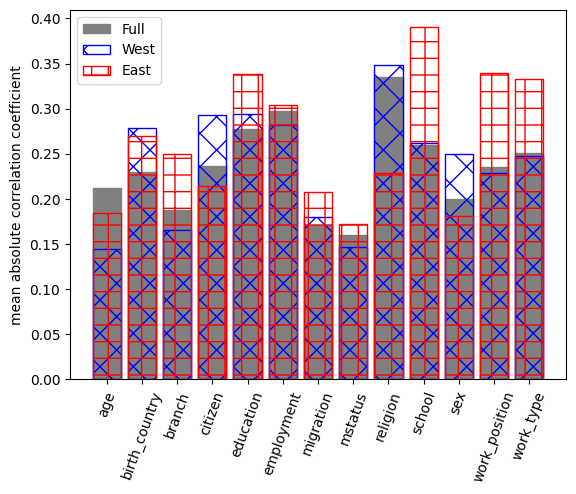

In [50]:
plt.bar(mycat1,catcor[0,:,0],edgecolor='gray',facecolor='gray',label='Full') 
plt.bar(mycat1,catcor[0,:,1],edgecolor='blue',facecolor='None',hatch='\\/',label='West') 
plt.bar(mycat1,catcor[0,:,2],edgecolor='red',facecolor='None',hatch='+',label='East') 
plt.legend(loc="best") #too big improve add also labels and betetr symbols
#plt.xlabel("property number")
plt.ylabel("mean absolute correlation coefficient")
plt.xticks(rotation=70)
#plt.ylim(-0.5, 1)
#plt.xscale("log")
plt.title("")

Text(0.5, 1.0, '')

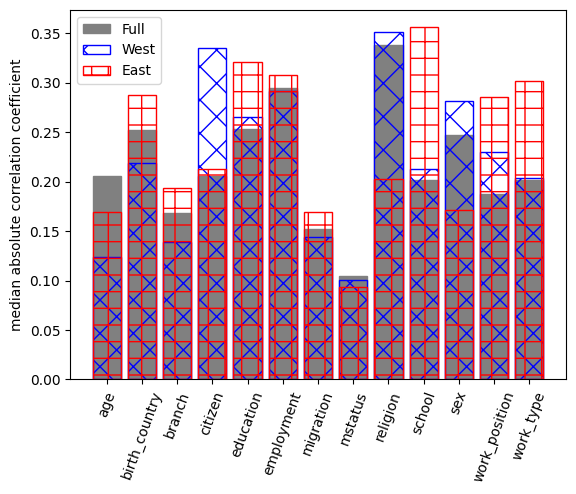

In [51]:
plt.bar(mycat1,catcor[2,:,0],edgecolor='gray',facecolor='gray',label='Full') 
plt.bar(mycat1,catcor[2,:,1],edgecolor='blue',facecolor='None',hatch='\\/',label='West') 
plt.bar(mycat1,catcor[2,:,2],edgecolor='red',facecolor='None',hatch='+',label='East') 
plt.legend(loc="best") #too big improve add also labels and betetr symbols
#plt.xlabel("property number")
plt.ylabel("median absolute correlation coefficient")
plt.xticks(rotation=70)
#plt.ylim(-0.5, 1)
#plt.xscale("log")
plt.title("")

In [52]:
for i in range(10):
    print(listp[i])
    print("Full Germany")
    print(f"max pos correlation of {round(np.max(corr1[i,:,0]),4)} at {listg1b[np.argmax(corr1[i,:,0])]}")
    print(f"max neg correlation of {round(np.min(corr1[i,:,0]),4)} at {listg1b[np.argmin(corr1[i,:,0])]}")
    print(f"no correlation of {round(np.min(abs(corr1[i,:,0])),4)} at {listg1b[np.argmin(abs(corr1[i,:,0]))]}") 
    print("West Germany")
    print(f"max pos correlation of {round(np.nanmax(corr1[i,:,1]),4)} at {listg1b[np.nanargmax(corr1[i,:,1])]}")
    print(f"max neg correlation of {round(np.nanmin(corr1[i,:,1]),4)} at {listg1b[np.nanargmin(corr1[i,:,1])]}")
    print(f"no correlation of {round(np.nanmin(abs(corr1[i,:,1])),4)} at {listg1b[np.nanargmin(abs(corr1[i,:,1]))]}") 
    print("East Germany")
    print(f"max pos correlation of {round(np.nanmax(corr1[i,:,2]),4)} at {listg1b[np.nanargmax(corr1[i,:,2])]}")
    print(f"max neg correlation of {round(np.nanmin(corr1[i,:,2]),4)} at {listg1b[np.nanargmin(corr1[i,:,2])]}")
    print(f"no correlation of {round(np.nanmin(abs(corr1[i,:,2])),4)} at {listg1b[np.nanargmin(abs(corr1[i,:,2]))]}") 
    print(" ")
#east germany sprase likely sporious correlations  

print(f"migration 70 to 79 is available for {int(corr1[10,68,2])} in the East")

voters
Full Germany
max pos correlation of 0.6117 at technical_trained
max neg correlation of -0.6614 at unemployed_all
no correlation of 0.0023 at male_30_39
West Germany
max pos correlation of 0.6044 at technical_trained
max neg correlation of -0.6556 at no_school_certificate
no correlation of 0.0018 at male_18_24
East Germany
max pos correlation of 0.7837 at self_employed_company
max neg correlation of -1.0 at migration_70-79
no correlation of 0.0002 at distribution
 
not_valid_party_votes
Full Germany
max pos correlation of 0.3393 at religion_other
max neg correlation of -0.3709 at professional_academy
no correlation of 0.0 at civil_union_divorved_female
West Germany
max pos correlation of 0.2661 at not_employable_all
max neg correlation of -0.3319 at professional_academy
no correlation of 0.0021 at migration_rest_europes
East Germany
max pos correlation of 1.0 at migration_70-79
max neg correlation of -0.3933 at PhD_and_MD
no correlation of 0.0 at unemployed_female
 
valid_party_v

The correlations for voters and valid votes are very similar because only few votes are invalid. 

The smallest absolute correlation is often usually for properties which are rare like civil union (same sex civil union) related. In the East also very often migration 70 to 79 because the property is only available for two comminties and thus the correlation coefficient cannot be calculated.  It is not clear that these properties do not correlate with voters pattern, because it is possible that the others more common properties just add so much 'noise', that it cannot be measured in single factor analysis. One of the strongest factors (with both signs) are religion. That is not only because of unification ( other religion of none is much more common in the East of Germany). It is also due to that is due one of origin of the christian unions and other parties. 

There is really a correlation between birth country and libertarian vote share and it is not only caused by east and west differences, since the trend is also visible within the west. 

We now look on the impact of a property relative to its share. First for voter properties. We do not plot total voters, because it is very similar to valid votes. 

The biggest correlations are [  nan 1.    0.884] for ['migration_60-69', 'migration_70-79', 'migration_80-89']
corr1[10,67:70,2] communities have that property


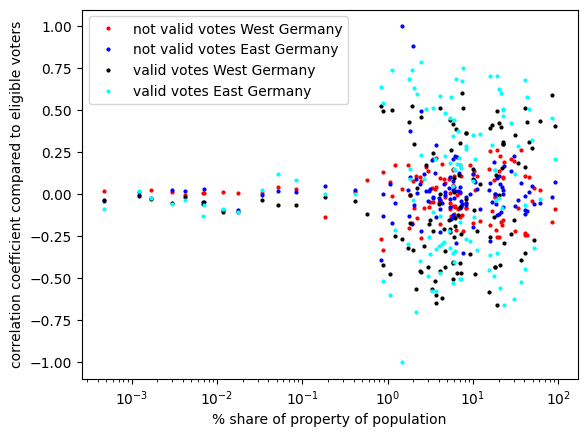

In [53]:
#is full german share not eats/west part share 
plt.plot(100*pop2[1],corr1[1,:,1],'o',ms=2,color='red',label='not valid votes West Germany') 
plt.plot(100*pop2[1],corr1[1,:,2],'o',ms=2,color='blue',label='not valid votes East Germany') 
plt.plot(100*pop2[1],corr1[2,:,1],'o',ms=2,color='black',label='valid votes West Germany') 
plt.plot(100*pop2[1],corr1[2,:,2],'o',ms=2,color='cyan',label='valid votes East Germany') 
plt.legend(loc="best")
plt.xlabel("% share of property of population")
plt.ylabel("correlation coefficient compared to eligible voters")
plt.xscale("log")
#plt.yscale("log")
print(f"The biggest correlations are {np.round(corr1[1,67:70,2],3)} for {listg1b[67:70]}")
print(f"corr1[10,67:70,2] communities have that property")

And now the parties first values seperately in West and East Germany. 

Text(0.5, 1.0, 'West Germany')

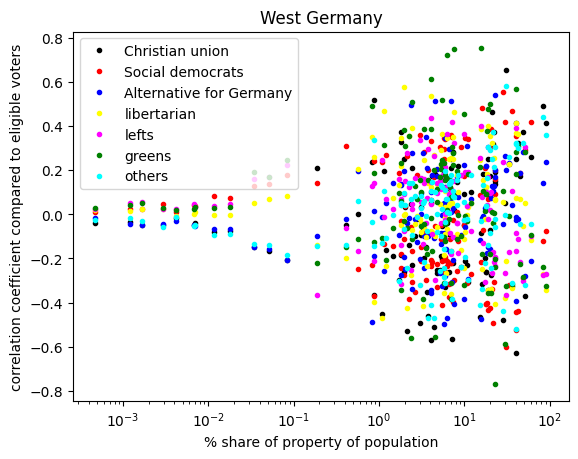

In [54]:
plt.plot(100*pop2[1],(corr1[3,:,1]),'o',ms=3,color='black',label='Christian union') 
plt.plot(100*pop2[1],(corr1[4,:,1]),'o',ms=3,color='red',label='Social democrats') 
plt.plot(100*pop2[1],corr1[5,:,1],'o',ms=3,color='blue',label='Alternative for Germany') 
plt.plot(100*pop2[1],corr1[6,:,1],'o',ms=3,color='yellow',label='libertarian') 
plt.plot(100*pop2[1],corr1[7,:,1],'o',ms=3,color='magenta',label='lefts') 
plt.plot(100*pop2[1],corr1[8,:,1],'o',ms=3,color='green',label='greens') 
plt.plot(100*pop2[1],corr1[9,:,1],'o',ms=3,color='cyan',label='others') 
plt.legend(loc="best")
plt.xlabel("% share of property of population")
plt.ylabel("correlation coefficient compared to eligible voters")
plt.xscale("log")
plt.title("West Germany")

Text(0.5, 1.0, 'East Germany')

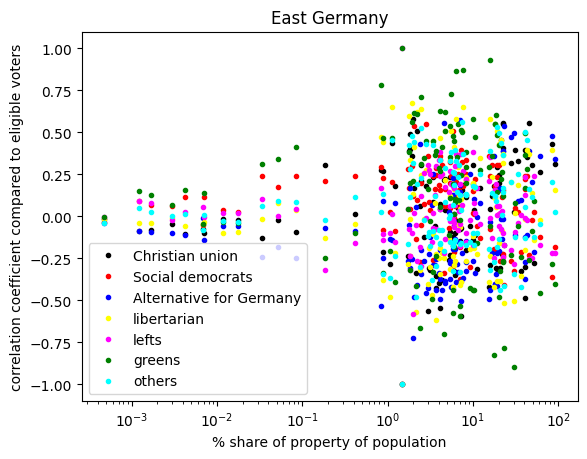

In [55]:
plt.plot(100*pop2[1],(corr1[3,:,2]),'o',ms=3,color='black',label='Christian union') 
plt.plot(100*pop2[1],(corr1[4,:,2]),'o',ms=3,color='red',label='Social democrats') 
plt.plot(100*pop2[1],corr1[5,:,2],'o',ms=3,color='blue',label='Alternative for Germany') 
plt.plot(100*pop2[1],corr1[6,:,2],'o',ms=3,color='yellow',label='libertarian') 
plt.plot(100*pop2[1],corr1[7,:,2],'o',ms=3,color='magenta',label='lefts') 
plt.plot(100*pop2[1],corr1[8,:,2],'o',ms=3,color='green',label='greens') 
plt.plot(100*pop2[1],corr1[9,:,2],'o',ms=3,color='cyan',label='others') 
plt.legend(loc="best")
plt.xlabel("% share of property of population")
plt.ylabel("correlation coefficient compared to eligible voters")
plt.xscale("log")
plt.title("East Germany")

Now the absolute values for full Germany. 

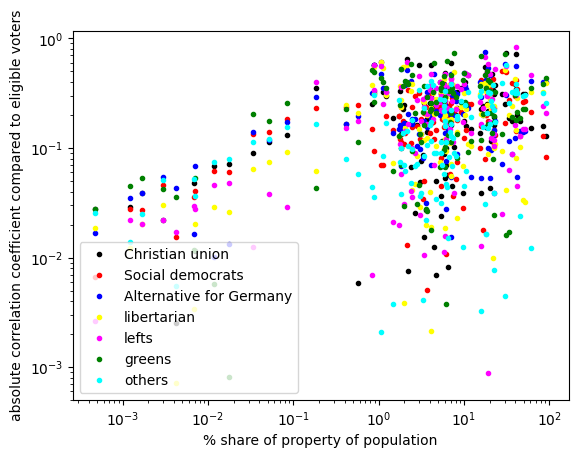

In [56]:
plt.plot(100*pop2[1],abs(corr1[3,:,0]),'o',ms=3,color='black',label='Christian union') 
plt.plot(100*pop2[1],abs(corr1[4,:,0]),'o',ms=3,color='red',label='Social democrats') 
plt.plot(100*pop2[1],abs(corr1[5,:,0]),'o',ms=3,color='blue',label='Alternative for Germany') 
plt.plot(100*pop2[1],abs(corr1[6,:,0]),'o',ms=3,color='yellow',label='libertarian') 
plt.plot(100*pop2[1],abs(corr1[7,:,0]),'o',ms=3,color='magenta',label='lefts') 
plt.plot(100*pop2[1],abs(corr1[8,:,0]),'o',ms=3,color='green',label='greens') 
plt.plot(100*pop2[1],abs(corr1[9,:,0]),'o',ms=3,color='cyan',label='others') 
plt.legend(loc="best")
plt.xlabel("% share of property of population")
plt.ylabel("absolute correlation coefficient compared to eligible voters")
plt.xscale("log")
plt.yscale("log")

In general the properties with really small sahre have a small influence. Possible also the influence of properties above 80 decreases again. We now look on the median influence below. 

In [57]:
for i in range(len(listg1b)):
    print(f"{listg1b[i]} has share of {round(100*pop2[1,i],4)}% and median abs cor coev of {round(np.median(abs(corr1[:,i])),4)}")

male has share of 48.705% and median abs cor coev of 0.2688
female has share of 51.2951% and median abs cor coev of 0.2685
single_total has share of 40.3159% and median abs cor coev of 0.2329
single_male has share of 21.6761% and median abs cor coev of 0.1702
single_female has share of 18.6357% and median abs cor coev of 0.211
married_total has share of 45.3006% and median abs cor coev of 0.2186
married_male has share of 22.649% and median abs cor coev of 0.2242
married_female has share of 22.6499% and median abs cor coev of 0.2018
widowed_total has share of 7.0533% and median abs cor coev of 0.3608
widowed_male has share of 1.2105% and median abs cor coev of 0.2358
widowed_female has share of 5.8093% and median abs cor coev of 0.3441
divorced_total has share of 7.1386% and median abs cor coev of 0.3907
divorced_male has share of 3.0088% and median abs cor coev of 0.3583
divorced_female has share of 4.0952% and median abs cor coev of 0.3878
civil_union_total has share of 0.0833% and me

The smallest percetange are really small. Thus we are excluding ended civil unions. A related question is how different are the male female parts of the total of the same property. It should not be used total, male and feamle at once because that would be double use. For civil union we just use the total because the number is low and it seems that just noise decreases all singal there, since most coeffeicent are larger when combined.

To decided the others we look on plots. Below we look on gender as expected it is just the mirror of each other, which means that we exclude one. We always do that for one property of one category because otherwise there would be perfect (In practice  imperfect data makes it not perfect, but still too good for being useful.) correlation which makes weights not interpretable. 

Text(0, 0.5, 'correlation coefficient compared to eligible voters')

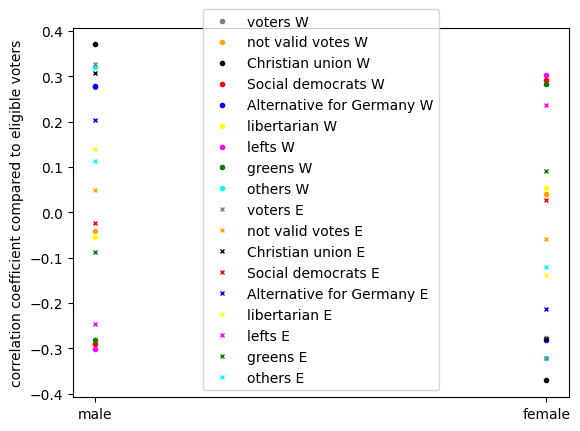

In [58]:
plt.plot(listg1[0:2],corr1[0,0:2,1],'o',ms=3,color='gray',label='voters W') 
plt.plot(listg1[0:2],corr1[1,0:2,1],'o',ms=3,color='orange',label='not valid votes W') 
plt.plot(listg1[0:2],corr1[3,0:2,1],'o',ms=3,color='black',label='Christian union W') 
plt.plot(listg1[0:2],corr1[4,0:2,1],'o',ms=3,color='red',label='Social democrats W') 
plt.plot(listg1[0:2],corr1[5,0:2,1],'o',ms=3,color='blue',label='Alternative for Germany W') 
plt.plot(listg1[0:2],corr1[6,0:2,1],'o',ms=3,color='yellow',label='libertarian W') 
plt.plot(listg1[0:2],corr1[7,0:2,1],'o',ms=3,color='magenta',label='lefts W') 
plt.plot(listg1[0:2],corr1[8,0:2,1],'o',ms=3,color='green',label='greens W') 
plt.plot(listg1[0:2],corr1[9,0:2,1],'o',ms=3,color='cyan',label='others W') 
plt.plot(listg1[0:2],corr1[0,0:2,2],'x',ms=3,color='gray',label='voters E') 
plt.plot(listg1[0:2],corr1[1,0:2,2],'x',ms=3,color='orange',label='not valid votes E') 
plt.plot(listg1[0:2],corr1[3,0:2,2],'x',ms=3,color='black',label='Christian union E') 
plt.plot(listg1[0:2],corr1[4,0:2,2],'x',ms=3,color='red',label='Social democrats E') 
plt.plot(listg1[0:2],corr1[5,0:2,2],'x',ms=3,color='blue',label='Alternative for Germany E') 
plt.plot(listg1[0:2],corr1[6,0:2,2],'x',ms=3,color='yellow',label='libertarian E') 
plt.plot(listg1[0:2],corr1[7,0:2,2],'x',ms=3,color='magenta',label='lefts E') 
plt.plot(listg1[0:2],corr1[8,0:2,2],'x',ms=3,color='green',label='greens E') 
plt.plot(listg1[0:2],corr1[9,0:2,2],'x',ms=3,color='cyan',label='others E') 
plt.legend(loc="best") 
#plt.xlabel("property number")
plt.ylabel("correlation coefficient compared to eligible voters")
#plt.xscale("log")
#plt.xlim(-0.5,16.5)

Now we plot to the coefficent for all marital status categories with enough data. 

(-1.8, 0.55)

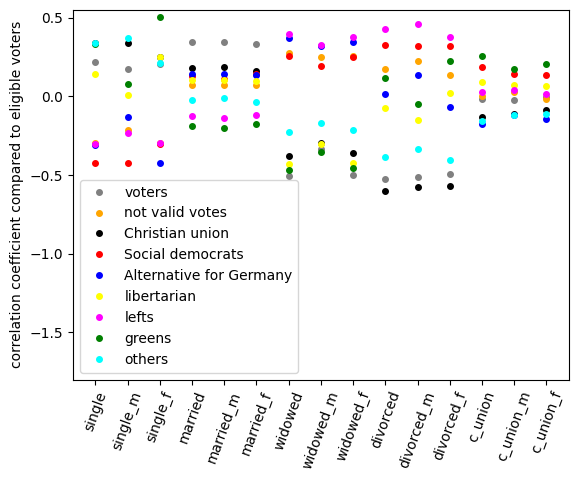

In [59]:
listpl1=['single', 'single_m', 'single_f', 'married', 'married_m', 'married_f', 'widowed', 'widowed_m', 'widowed_f', 'divorced', 'divorced_m', 'divorced_f', 'c_union', 'c_union_m', 'c_union_f']
plt.plot(listpl1,corr1[0,2:17,0],'o',ms=4,color='gray',label='voters') 
plt.plot(listpl1,corr1[1,2:17,0],'o',ms=4,color='orange',label='not valid votes') 
plt.plot(listpl1,(corr1[3,2:17,0]),'o',ms=4,color='black',label='Christian union') 
plt.plot(listpl1,corr1[4,2:17,0],'o',ms=4,color='red',label='Social democrats') 
plt.plot(listpl1,corr1[5,2:17,0],'o',ms=4,color='blue',label='Alternative for Germany') 
plt.plot(listpl1,corr1[6,2:17,0],'o',ms=4,color='yellow',label='libertarian') 
plt.plot(listpl1,corr1[7,2:17,0],'o',ms=4,color='magenta',label='lefts') 
plt.plot(listpl1,corr1[8,2:17,0],'o',ms=4,color='green',label='greens') 
plt.plot(listpl1,corr1[9,2:17,0],'o',ms=4,color='cyan',label='others') 
plt.legend(loc="best") 
#plt.xlabel("property number")
plt.xticks(rotation=70)
plt.ylabel("correlation coefficient compared to eligible voters")
plt.ylim(-1.8,0.55)

Since for single there are clear difference we separate by gender. In contrast it seems rather similar for married, therefore we use married total there. This does not necessary means it is the same but because married couples live usually together, census based analysis cannot separate them well. For widowed the coefficents are nearly always larger absolutely together than separated, thsu we use them together. That could be just caused by low numbers. In contrast there are some parties which have with clearly different trends for divorced, thus we separate them.  At the we omit civil union from the categories because since all together sum up to 100% it is already included.


We now look on the age groups. 

['total_18_24', 'male_18_24', 'female_18_24', 'total_25_29', 'male_25_29', 'female_25_29', 'total_30_39', 'male_30_39', 'female_30_39', 'total_40_49', 'male_40_49', 'female_40_49', 'total_50_64', 'male_50_64', 'female_50_64', 'total_65_74', 'male_65_74', 'female_65_74', 'total_75_and_older', 'male_75_and_older', 'female_75_and_older']


Text(0.5, 1.0, 'Full Germany')

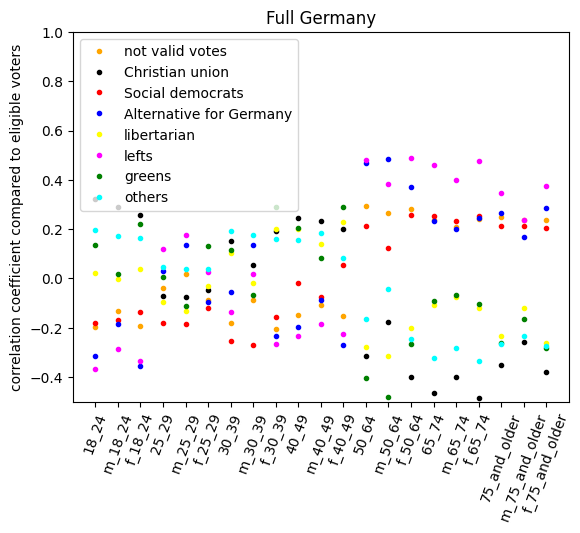

In [60]:
print(listg1b[26:47])
lista=['18_24', 'm_18_24', 'f_18_24', '25_29', 'm_25_29', 'f_25_29', '30_39', 'm_30_39', 'f_30_39', '40_49', 'm_40_49', 'f_40_49', '50_64', 'm_50_64', 'f_50_64', '65_74', 'm_65_74', 'f_65_74', '75_and_older', 'm_75_and_older', 'f_75_and_older']
plt.plot(lista,corr1[1,26:47,0],'o',ms=3,color='orange',label='not valid votes') 
plt.plot(lista,(corr1[3,26:47,0]),'o',ms=3,color='black',label='Christian union') 
plt.plot(lista,corr1[4,26:47,0],'o',ms=3,color='red',label='Social democrats') 
plt.plot(lista,corr1[5,26:47,0],'o',ms=3,color='blue',label='Alternative for Germany') 
plt.plot(lista,corr1[6,26:47,0],'o',ms=3,color='yellow',label='libertarian') 
plt.plot(lista,corr1[7,26:47,0],'o',ms=3,color='magenta',label='lefts') 
plt.plot(lista,corr1[8,26:47,0],'o',ms=3,color='green',label='greens') 
plt.plot(lista,corr1[9,26:47,0],'o',ms=3,color='cyan',label='others') 
plt.legend(loc="best") #too big improve add also labels and betetr symbols
#plt.xlabel("property number")
plt.ylabel("correlation coefficient compared to eligible voters")
plt.xticks(rotation=70)
plt.ylim(-0.5, 1)
#plt.xscale("log")
plt.title('Full Germany')



There are clear differences, but lets check whether they are also there when Germany is separated in East and West. 

Text(0.5, 1.0, 'West Germany')

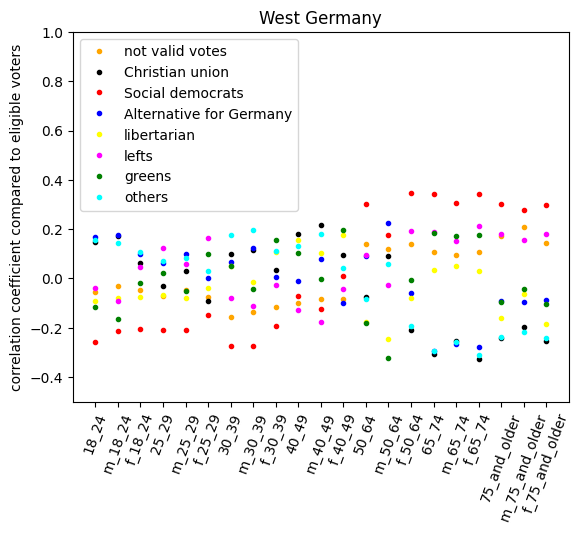

In [61]:
plt.plot(lista,corr1[1,26:47,1],'o',ms=3,color='orange',label='not valid votes') 
plt.plot(lista,(corr1[3,26:47,1]),'o',ms=3,color='black',label='Christian union') 
plt.plot(lista,corr1[4,26:47,1],'o',ms=3,color='red',label='Social democrats') 
plt.plot(lista,corr1[5,26:47,1],'o',ms=3,color='blue',label='Alternative for Germany') 
plt.plot(lista,corr1[6,26:47,1],'o',ms=3,color='yellow',label='libertarian') 
plt.plot(lista,corr1[7,26:47,1],'o',ms=3,color='magenta',label='lefts') 
plt.plot(lista,corr1[8,26:47,1],'o',ms=3,color='green',label='greens') 
plt.plot(lista,corr1[9,26:47,1],'o',ms=3,color='cyan',label='others') 
plt.legend(loc="best") #too big improve add also labels and betetr symbols
#plt.xlabel("property number")
plt.ylabel("correlation coefficient compared to eligible voters")
plt.xticks(rotation=70)
plt.ylim(-0.5, 1)
#plt.xscale("log")
plt.title('West Germany')
#still there although weaker, still different than what is usually found 

Since there are always some differences (least between 65 and 74) we use always the genders separately and discard the totals for the age groups.

Finally, we look on the citizen and religion properties

['citizen_german', 'birth_country_germany', 'birth_country_foreign', 'birth_country_eu27', 'birth_country_other_europe', 'birth_country_other_continents', 'birth_country_other', 'religion_catholic', 'religion_protestant', 'religion_other']


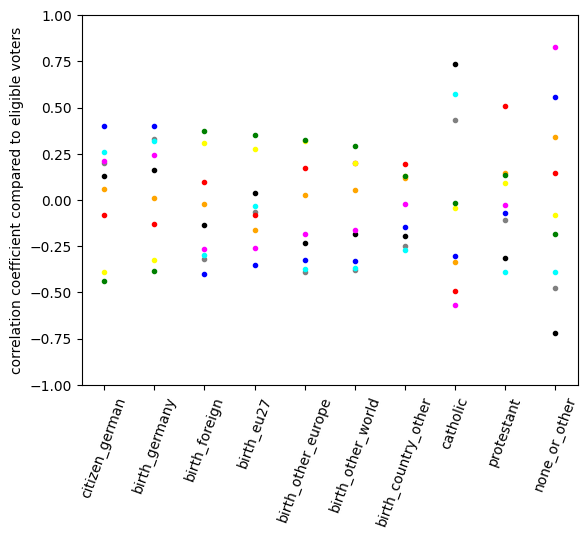

In [62]:
listb=['citizen_german', 'birth_germany', 'birth_foreign', 'birth_eu27', 'birth_other_europe', 'birth_other_world', 'birth_country_other', 'catholic', 'protestant', 'none_or_other']
plt.plot(listb,corr1[0,47:57,0],'o',ms=3,color='gray',label='voters') 
plt.plot(listb,corr1[1,47:57,0],'o',ms=3,color='orange',label='not valid votes') 
plt.plot(listb,(corr1[3,47:57,0]),'o',ms=3,color='black',label='Christian union') 
plt.plot(listb,corr1[4,47:57,0],'o',ms=3,color='red',label='Social democrats') 
plt.plot(listb,corr1[5,47:57,0],'o',ms=3,color='blue',label='Alternative for Germany') 
plt.plot(listb,corr1[6,47:57,0],'o',ms=3,color='yellow',label='libertarian') 
plt.plot(listb,corr1[7,47:57,0],'o',ms=3,color='magenta',label='lefts') 
plt.plot(listb,corr1[8,47:57,0],'o',ms=3,color='green',label='greens') 
plt.plot(listb,corr1[9,47:57,0],'o',ms=3,color='cyan',label='others') 
#plt.legend(loc="best") too big improve add also labels and betetr symbols
plt.ylabel("correlation coefficient compared to eligible voters")
plt.xticks(rotation=70)
#plt.xscale("log")
plt.ylim(-1,1)

print(listg1[47:57])

We discard citizen German since it is smaller than the birth country Germany and all voters should be citizens. We
exclude foreigen borth coiuntry since it is the negative of the former and use the eu27, other europe and other continents. We exclude other since it is unclear what is in it and the signal is small. All religions are kept since the have one of the largest signal. 

['migration_background_no', 'migration_background_yes', 'migration_background_foreign_all', 'migration_background_foreign_foreign_born', 'migration_background_foreign_german_born', 'migration_background_german_all', 'migration_background_german_foreign_born', 'migration_background_german_german_born', 'migration_background_german_german_born_mig_2parents', 'migration_background_german_german_born_mig_1parents']


(-0.5, 0.5)

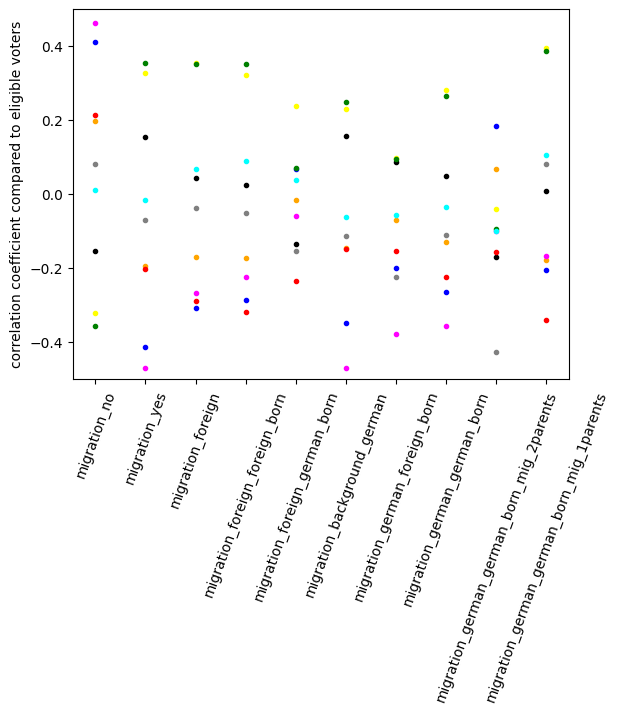

In [63]:
print(listg1b[57:67])
listm=['migration_no', 'migration_yes', 'migration_foreign', 'migration_foreign_foreign_born', 'migration_foreign_german_born', 'migration_background_german', 'migration_german_foreign_born', 'migration_german_german_born', 'migration_german_german_born_mig_2parents', 'migration_german_german_born_mig_1parents']

plt.plot(listm,corr1[0,57:67,0],'o',ms=3,color='gray',label='voters') 
plt.plot(listm,corr1[1,57:67,0],'o',ms=3,color='orange',label='not valid votes') 
plt.plot(listm,(corr1[3,57:67,0]),'o',ms=3,color='black',label='Christian union') 
plt.plot(listm,corr1[4,57:67,0],'o',ms=3,color='red',label='Social democrats') 
plt.plot(listm,corr1[5,57:67,0],'o',ms=3,color='blue',label='Alternative for Germany') 
plt.plot(listm,corr1[6,57:67,0],'o',ms=3,color='yellow',label='libertarian') 
plt.plot(listm,corr1[7,57:67,0],'o',ms=3,color='magenta',label='lefts') 
plt.plot(listm,corr1[8,57:67,0],'o',ms=3,color='green',label='greens') 
plt.plot(listm,corr1[9,57:67,0],'o',ms=3,color='cyan',label='others') 
#plt.legend(loc="best") too big improve add also labels and betetr symbols
plt.ylabel("correlation coefficient compared to eligible voters")
plt.xticks(rotation=70)
#plt.xscale("log")
plt.ylim(-0.5,0.5)
#AFP ger ger 2 parenets migration interesting russia germans? 

Further we discard some whose inclusion would lead too strong correlations between different features. Firstly, this is religion(other) which follows automatically when the other two are excluded. 
We also exclude divorced_female, because while in principlr we already exclude some features in the marital status category, they add up to so such a small number, that is practice there is still a very strong correlation without it. We choose divorced_female because its correlatio coefficients are most similar too civil union which domiantes the rests. 

In [64]:
print(listg1)
listg2=['male','single_male', 'single_female', 'married_total', 'widowed_total','divorced_male','male_18_24', 'female_18_24',  'male_25_29', 'female_25_29',  'male_30_39', 'female_30_39',  'male_40_49', 'female_40_49',  'male_50_64', 'female_50_64',  'male_65_74', 'female_65_74', 'male_75_and_older', 'female_75_and_older',  'birth_country_germany', 'birth_country_eu27', 'birth_country_other_europe', 'birth_country_other_continents',  'religion_catholic', 'religion_protestant']
print(len(listg2))
print(listg2)

['male', 'female', 'single_total', 'single_male', 'single_female', 'married_total', 'married_male', 'married_female', 'widowed_total', 'widowed_male', 'widowed_female', 'divorced_total', 'divorced_male', 'divorced_female', 'civil_union_total', 'civil_union_male', 'civil_union_female', 'civil_union_widowed_total', 'civil_union_widowed_male', 'civil_union_widowed_female', 'civil_union_divorced_total', 'civil_union_divorced_male', 'civil_union_divorved_female', 'not_specified_total', 'not_specified_male', 'not_specified_female', 'total_18_24', 'male_18_24', 'female_18_24', 'total_25_29', 'male_25_29', 'female_25_29', 'total_30_39', 'male_30_39', 'female_30_39', 'total_40_49', 'male_40_49', 'female_40_49', 'total_50_64', 'male_50_64', 'female_50_64', 'total_65_74', 'male_65_74', 'female_65_74', 'total_75_and_older', 'male_75_and_older', 'female_75_and_older', 'citizen_german', 'birth_country_germany', 'birth_country_foreign', 'birth_country_eu27', 'birth_country_other_europe', 'birth_count

Now we are selecting the units whoch have good data for all the selected properties. 

In [65]:
sel3=sel2.copy()
#get clean section and the use linear regression
for i in range(len(listg2)):
    print(i)
    sel3=sel3[(sel3[listg2[i]]>-0.5) & (sel3['qual_'+listg2[i]]!=1)]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [66]:
print(len(sel2))
print(len(sel3))
print(sel2.population.sum())
print(sel3.population.sum())
#are now clearly less to checked whether that causes a problem
print(sel2.population.min())
print(sel3.population.min())
print(sel2.population.median())
print(sel3.population.median())

5098
2535
71064974
61549224
55
55
5122.0
10798.0


In [67]:
#next is doing linear regression
#select properties of party, votes and valid votes are very similar thus only one and is now refernce, since usually the share is given to votes
listp2=['eligible_voters','not_valid_party_votes','christian_unions_party_votes','social_democrats_party_votes','alternative_for_germany_party_votes',
'libertarians_party_votes', 'lefts_party_votes','greens_party_votes','others_party_votes']
print(listp2)
#new reference is'valid_votes_party_votes'
#select features 
print(len(listg2))
feat=sel3.loc[:,[listg2[0],listg2[1]]]
print(sel3.loc[:,'population'])
feat.iloc[:,0]=feat.iloc[:,0]/sel3.loc[:,'population']*100
feat.iloc[:,1]=feat.iloc[:,1]/sel3.loc[:,'population']*100
for i in range(2,len(listg2)):
    feat[listg2[i]]=sel3.loc[:,[listg2[i]]]
    feat.iloc[:,i]=feat.iloc[:,i]/sel3.loc[:,'population']*100
print(feat)
#now the targets which are all of listp2
tar=sel3.loc[:,[listp2[0],listp2[1]]]
print(sel3.loc[:,'population'])
tar.iloc[:,0]=tar.iloc[:,0]/sel3.loc[:,'valid_party_votes']*100
tar.iloc[:,1]=tar.iloc[:,1]/sel3.loc[:,'valid_party_votes']*100
for i in range(2,len(listp2)):
    tar[listp2[i]]=sel3.loc[:,[listp2[i]]]
    tar.iloc[:,i]=tar.iloc[:,i]/sel3.loc[:,'valid_party_votes']*100
print(tar)

['eligible_voters', 'not_valid_party_votes', 'christian_unions_party_votes', 'social_democrats_party_votes', 'alternative_for_germany_party_votes', 'libertarians_party_votes', 'lefts_party_votes', 'greens_party_votes', 'others_party_votes']
26
0         82258
1        235782
2        210305
3         77249
4         12834
          ...  
9928       2290
9934       3800
9972       5024
10006     34090
10008     10964
Name: population, Length: 2535, dtype: int64
            male  single_male  single_female  married_total  widowed_total  \
0      49.276666    25.266843      20.542683      37.775049       7.162829   
1      48.139807    25.517639      23.426725      35.537064       6.149324   
2      47.470103    22.003281      20.085114      40.743206       7.579468   
3      48.816166    21.844943      18.198294      42.988259       7.908193   
4      49.579243    20.531401      15.412186      48.675393       8.563192   
...          ...          ...            ...            ...        

Now we split into train and test set with the usual share of 80 to 20. 

In [68]:

feat_train,feat_test,tar_train, tar_test= train_test_split(feat,tar,train_size=0.80, shuffle=True, random_state=1)
print(f"shape of features in train {feat_train.shape}")
print(f"shape of features in test {feat_test.shape}")
#normalize the features  should use standard scaler
print(feat_train.iloc[:,0])
norm_feat_train=feat_train.copy()
norm_feat_test=feat_test.copy()
print(feat_train)
statg2=np.zeros((2,len(listg2)))
m=feat_train.iloc[:,0].mean()
s=feat_train.iloc[:,0].std()
statg2[0,0]=m
statg2[1,0]=s
norm_feat_train.iloc[:,0]=(feat_train.iloc[:,0]-m)/s
norm_feat_test.iloc[:,0]=(feat_test.iloc[:,0]-m)/s
for i in range(1,len(listg2)):
    m=feat_train.iloc[:,i].mean()
    s=feat_train.iloc[:,i].std()
    norm_feat_train.iloc[:,i]=(feat_train.iloc[:,i]-m)/s
    norm_feat_test.iloc[:,i]=(feat_test.iloc[:,i]-m)/s
    statg2[0,i]=m
    statg2[1,i]=s
print(norm_feat_test.mean())
print(norm_feat_test.std())
print(np.round(statg2.T,3))
print(feat_train)
print(statg2.T)

shape of features in train (2028, 26)
shape of features in test (507, 26)
6602    49.257922
6194    47.434991
6861    49.123805
2240    48.804033
7185    50.596002
          ...    
4410    48.884043
3268    48.090975
4968    48.700565
1808    50.065269
4910    49.768672
Name: male, Length: 2028, dtype: float64
           male  single_male  single_female  married_total  widowed_total  \
6602  49.257922    21.660650      19.574809      50.020056       4.813478   
6194  47.434991    20.292246      18.634614      47.639249       6.386990   
6861  49.123805    20.584888      16.306327      49.681384       6.804734   
2240  48.804033    20.324314      17.547197      48.599553       6.961815   
7185  50.596002    20.905923      15.936182      51.494590       6.088392   
...         ...          ...            ...            ...            ...   
4410  48.884043    20.023089      16.534120      48.447922       8.004105   
3268  48.090975    19.923845      17.045727      46.934925       8.0546

In [69]:
coefs=np.zeros((feat_test.shape[1]+1,len(listp2)+1))
coefs[:,9]=np.arange(0,feat_test.shape[1]+1,1)
predte=np.zeros((feat_test.shape[0],len(listp2)))
predtr=np.zeros((feat_train.shape[0],len(listp2)))
statlin=np.zeros((7,len(listp2)))
statlin[6,:]=np.arange(0,9,1)
for i in range(len(listp2)):
    print(i)
    reg = LinearRegression().fit(norm_feat_train, tar_train.iloc[:,i]) #fit results seem to be bad
    coefs[0:feat_test.shape[1],i]=reg.coef_
    print(reg.coef_)
    coefs[feat_test.shape[1],i]=reg.intercept_
    predtr[:,i]=reg.predict(norm_feat_train)    
    predte[:,i]=reg.predict(norm_feat_test)
    statlin[0,i]=tar_train.iloc[:,i].mean()
    statlin[1,i]=tar_train.iloc[:,i].std()  
    statlin[2,i]=np.std(tar_train.iloc[:,i]-predtr[:,i])   
    statlin[3,i]=tar_test.iloc[:,i].mean()
    statlin[4,i]=tar_test.iloc[:,i].std()  
    statlin[5,i]=np.std(tar_test.iloc[:,i]-predte[:,i])     
print(np.round(statlin.T,3))    

0
[-1.97784872  1.13922629 -2.3270987  -1.22600736  4.47812765  1.92093717
  0.11949717 -0.03911587 -0.06219367 -0.76189952  0.26860777 -2.36954543
  0.47021611 -2.34567707  0.89015451 -1.85716323 -0.05437276 -1.7243911
 -1.09284638 -2.47797232 -1.55202972 -0.68675956  1.58356345  1.37220428
 -4.39052823 -3.30968574]
1
[-0.07280023  0.07153944 -0.02965829  0.08441921  0.11611455  0.06644071
 -0.02480088  0.02594945  0.02333321 -0.00821071  0.02393371 -0.05435198
  0.06110948 -0.03232709  0.08592527 -0.01482712 -0.03933131 -0.02149847
  0.08345676 -0.09907581 -0.17505391 -0.12694293 -0.02995782  0.01242343
 -0.16103334 -0.09062492]
2
[ 0.53495447  0.60802301  1.08321606  1.50230729  1.16724081 -0.54906539
  0.05183843 -0.39058628 -0.32691222 -0.46259074  0.01013688 -0.21841504
 -0.21469909 -0.23886393 -0.12471065 -0.69009643  0.4998164  -0.04999227
 -0.95504463  0.1410248   0.59655207  1.05473766 -0.63905458  0.58961008
  5.18452301  1.46449047]
3
[-1.46899989 -1.84619849 -3.1057034  -2

We now plot the standard deviation over the full data set and the one after subtracting the predictions. 

['eligible_voters', 'not_valid_party_votes', 'christian_unions_party_votes', 'social_democrats_party_votes', 'alternative_for_germany_party_votes', 'libertarians_party_votes', 'lefts_party_votes', 'greens_party_votes', 'others_party_votes']


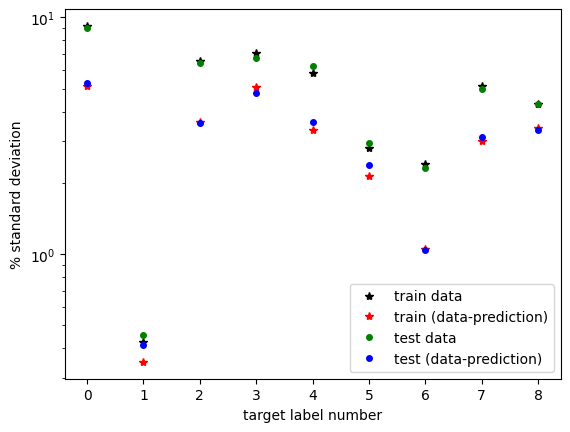

In [70]:
print(listp2)
plt.plot(statlin[6],statlin[1],'*',ms=6,color='black',label='train data') 
plt.plot(statlin[6],statlin[2],'*',ms=6,color='red',label='train (data-prediction)') 
plt.plot(statlin[6],statlin[4],'o',ms=4,color='green',label='test data') 
plt.plot(statlin[6],statlin[5],'o',ms=4,color='blue',label='test (data-prediction)') 
plt.legend(loc="best")
plt.ylabel("% standard deviation")
plt.xlabel("target label number")
plt.yscale("log")
#does not change after normnalization

['male', 'single_male', 'single_female', 'married_total', 'widowed_total', 'divorced_male', 'male_18_24', 'female_18_24', 'male_25_29', 'female_25_29', 'male_30_39', 'female_30_39', 'male_40_49', 'female_40_49', 'male_50_64', 'female_50_64', 'male_65_74', 'female_65_74', 'male_75_and_older', 'female_75_and_older', 'birth_country_germany', 'birth_country_eu27', 'birth_country_other_europe', 'birth_country_other_continents', 'religion_catholic', 'religion_protestant']
[ 1.09059856 -2.14247328  0.03913335 -3.99150226 -3.71152633 -1.55381866
 -0.22439529  0.36011715 -0.51401698  0.50934753 -0.68339533  0.98316695
 -0.31776934  1.40759231 -0.80257702  1.00458699  0.43921122  0.59053092
  0.62575073  1.07911969 -0.9400112   0.13979605 -0.03864712 -0.18202773
  0.19328362  1.38645447 11.91005623]


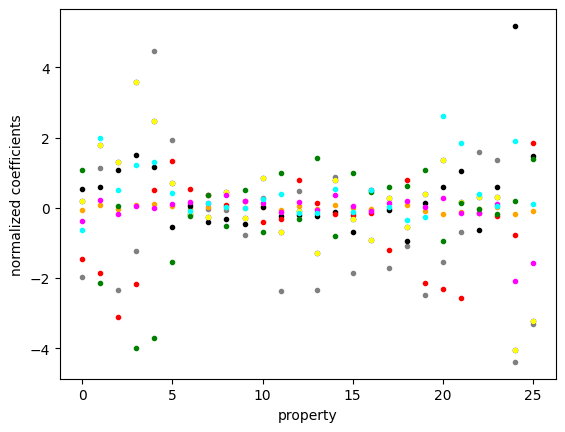

In [71]:
print(listg2)
plt.plot(coefs[0:26,9],coefs[0:26,0],'o',ms=3,color='gray',label=f'{listp2[0]}') 
plt.plot(coefs[0:26,9],coefs[0:26,1],'o',ms=3,color='orange',label=f'{listp2[1]}')
plt.plot(coefs[0:26,9],coefs[0:26,2],'o',ms=3,color='black',label=f'{listp2[2]}') 
plt.plot(coefs[0:26,9],coefs[0:26,3],'o',ms=3,color='red',label=f'{listp2[3]}')
plt.plot(coefs[0:26,9],coefs[0:26,4],'o',ms=3,color='blue',label=f'{listp2[4]}') 
plt.plot(coefs[0:26,9],coefs[0:26,4],'o',ms=3,color='yellow',label=f'{listp2[5]}')
plt.plot(coefs[0:26,9],coefs[0:26,6],'o',ms=3,color='magenta',label=f'{listp2[6]}') 
plt.plot(coefs[0:26,9],coefs[0:26,7],'o',ms=3,color='green',label=f'{listp2[7]}')
plt.plot(coefs[0:26,9],coefs[0:26,8],'o',ms=3,color='cyan',label=f'{listp2[8]}')
#plt.legend(loc="best")
plt.ylabel("normalized coefficients")
plt.xlabel("property")
#plt.xscale("log")
#plt.yscale("log")
#something wrong all religion positive for chrsiatin is wrong 
#now somewhat more differences and more seem irrelevant (all the ince which have small shares)
#values cahnge a lot here, prediction goodness less
print(coefs[0:29,7])
#still big signal in first part  civil union is too small part for omitting for stable fits 

(2028, 9)


Text(0.5, 0, 'prediction')

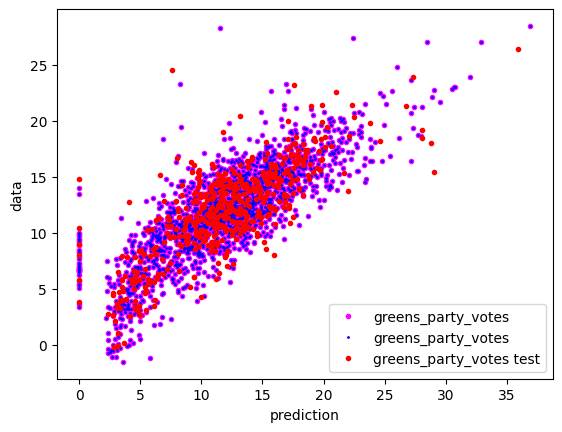

In [72]:
print(np.shape(predtr))
pg=coefs[26,7]+np.matmul(norm_feat_train,coefs[0:26,7]) #prediction works and does what it should but still strange numnbers
plt.plot(tar_train.iloc[:,7],predtr[:,7],'o',ms=3,color='magenta',label=f'{listp2[7]}') 
plt.plot(tar_train.iloc[:,7],pg,'o',ms=1,color='blue',label=f'{listp2[7]}') 
plt.plot(tar_test.iloc[:,7],predte[:,7],'o',ms=3,color='red',label=f'{listp2[7]} test') 
plt.legend(loc="best")
plt.ylabel("data")
plt.xlabel("prediction")
#prediction o.k. but seem that minors are not well done 
#seems like only get 

We try now to use Lasso L1 regularization to reduce the number of features. We do this for each label (party) separately, since it is not expected that the same are important for all. As criterain we use that the score in the test set is thhe same as in the origal sample. It is expected when excluding a few the scores first improves. However, that should be caused by random overfitting on training, the true perfamnace should be reached when the score is again the same as at the beginning. 

In [73]:
#first just doing for one at a time without a function

pars=np.zeros((8,40,len(listp2)))
for i in range(40):
    pars[0,i,0]=0.0001*1.35**i

    
for j in range(len(listp2)):
    print(listp2[j])
    for i in range(np.shape(pars)[1]):
        print(pars[0,i,0])
        reg = Lasso(alpha=pars[0,i,0],max_iter=1000).fit(norm_feat_train, tar_train.iloc[:,j]) 
        #print(reg.coef_)
        pars[1,i,j]=np.count_nonzero(reg.coef_!=0)
        print(np.where(reg.coef_==0,listg2, 0))
        predtrl=reg.predict(norm_feat_train)    
        predtel=reg.predict(norm_feat_test)
        pars[2,i,j]=tar_train.iloc[:,j].mean()
        pars[3,i,j]=tar_train.iloc[:,j].std()  
        pars[4,i,j]=np.std(tar_train.iloc[:,j]-predtrl)   
        pars[5,i,j]=tar_test.iloc[:,j].mean()
        pars[6,i,j]=tar_test.iloc[:,j].std()  
        pars[7,i,j]=np.std(tar_test.iloc[:,j]-predtel)
#somehow not converged     and increase does not help, likely correlation problem 
print(pars[1,:,:])
#too often of first part, need to exclude one there 

eligible_voters
0.0001
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00013500000000000003
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00018225000000000004
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00024603750000000006
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00033215062500000013
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0004484033437500002
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0006053445140625002
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0008172150939843753
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '

['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00018225000000000004
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00024603750000000006
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00033215062500000013
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0004484033437500002
['0' 'single_male' '0' '0' '0' '0' '0' '0' '0' 'female_25_29' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
0.0006053445140625002
['0' 'single_male' '0' '0' '0' '0' '0' '0' '0' 'female_25_29' '0' '0' '0'
 '0' '0' 'female_50_64' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
0.0008172150939843753
['0' 'single_male' '0' '0' '0' '0' '0' '0' '0' 'female_25_29' '0' '0' '0'
 '0' '0' 'female_50_64' '0' 'female_65_74' '0' '0' '0' '0' '0' '0' '0' '0']
0.001103240376878907

['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00013500000000000003
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00018225000000000004
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00024603750000000006
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00033215062500000013
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0004484033437500002
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0006053445140625002
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0008172150939843753
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0'

['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00033215062500000013
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0004484033437500002
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0006053445140625002
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0008172150939843753
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.001103240376878907
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0014893745087865243
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0020106555868618084
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0'

0.00018225000000000004
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00024603750000000006
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00033215062500000013
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0004484033437500002
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0006053445140625002
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0008172150939843753
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.001103240376878907
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0014893745087865243
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'


['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00013500000000000003
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00018225000000000004
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00024603750000000006
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00033215062500000013
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0004484033437500002
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0006053445140625002
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0008172150939843753
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0'

lefts_party_votes
0.0001
['0' '0' '0' '0' 'widowed_total' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
0.00013500000000000003
['0' '0' '0' '0' 'widowed_total' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
0.00018225000000000004
['0' '0' '0' '0' 'widowed_total' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
0.00024603750000000006
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00033215062500000013
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0004484033437500002
['0' '0' '0' 'married_total' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
0.0006053445140625002
['0' '0' '0' 'married_total' 'widowed_total' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
0.0008172150939843

6.642773344728182
['male' 'single_male' 'single_female' 'married_total' 'widowed_total'
 'divorced_male' 'male_18_24' 'female_18_24' 'male_25_29' 'female_25_29'
 'male_30_39' 'female_30_39' 'male_40_49' 'female_40_49' 'male_50_64'
 'female_50_64' 'male_65_74' 'female_65_74' 'male_75_and_older'
 'female_75_and_older' 'birth_country_germany' 'birth_country_eu27'
 'birth_country_other_europe' 'birth_country_other_continents'
 'religion_catholic' 'religion_protestant']
8.967744015383046
['male' 'single_male' 'single_female' 'married_total' 'widowed_total'
 'divorced_male' 'male_18_24' 'female_18_24' 'male_25_29' 'female_25_29'
 'male_30_39' 'female_30_39' 'male_40_49' 'female_40_49' 'male_50_64'
 'female_50_64' 'male_65_74' 'female_65_74' 'male_75_and_older'
 'female_75_and_older' 'birth_country_germany' 'birth_country_eu27'
 'birth_country_other_europe' 'birth_country_other_continents'
 'religion_catholic' 'religion_protestant']
12.106454420767113
['male' 'single_male' 'single_female' 'ma

2.6999027972273253
['male' 'single_male' '0' 'married_total' 'widowed_total' 'divorced_male'
 'male_18_24' 'female_18_24' 'male_25_29' 'female_25_29' 'male_30_39'
 'female_30_39' 'male_40_49' 'female_40_49' '0' 'female_50_64'
 'male_65_74' 'female_65_74' 'male_75_and_older' 'female_75_and_older'
 'birth_country_germany' 'birth_country_eu27' 'birth_country_other_europe'
 'birth_country_other_continents' 'religion_catholic'
 'religion_protestant']
3.6448687762568897
['male' 'single_male' 'single_female' 'married_total' 'widowed_total'
 'divorced_male' 'male_18_24' 'female_18_24' 'male_25_29' 'female_25_29'
 'male_30_39' 'female_30_39' 'male_40_49' 'female_40_49' 'male_50_64'
 'female_50_64' 'male_65_74' 'female_65_74' 'male_75_and_older'
 'female_75_and_older' 'birth_country_germany' 'birth_country_eu27'
 'birth_country_other_europe' 'birth_country_other_continents'
 'religion_catholic' 'religion_protestant']
4.920572847946801
['male' 'single_male' 'single_female' 'married_total' 'widowe

1.48142814662679
['male' 'single_male' 'single_female' 'married_total' 'widowed_total'
 'divorced_male' 'male_18_24' 'female_18_24' 'male_25_29' 'female_25_29'
 'male_30_39' 'female_30_39' 'male_40_49' 'female_40_49' 'male_50_64'
 'female_50_64' 'male_65_74' 'female_65_74' 'male_75_and_older'
 'female_75_and_older' 'birth_country_germany' 'birth_country_eu27'
 'birth_country_other_europe' 'birth_country_other_continents' '0'
 'religion_protestant']
1.9999279979461666
['male' 'single_male' 'single_female' 'married_total' 'widowed_total'
 'divorced_male' 'male_18_24' 'female_18_24' 'male_25_29' 'female_25_29'
 'male_30_39' 'female_30_39' 'male_40_49' 'female_40_49' 'male_50_64'
 'female_50_64' 'male_65_74' 'female_65_74' 'male_75_and_older'
 'female_75_and_older' 'birth_country_germany' 'birth_country_eu27'
 'birth_country_other_europe' 'birth_country_other_continents'
 'religion_catholic' 'religion_protestant']
2.6999027972273253
['male' 'single_male' 'single_female' 'married_total' 'wi

['eligible_voters', 'not_valid_party_votes', 'christian_unions_party_votes', 'social_democrats_party_votes', 'alternative_for_germany_party_votes', 'libertarians_party_votes', 'lefts_party_votes', 'greens_party_votes', 'others_party_votes']


(-0.01, 0.005)

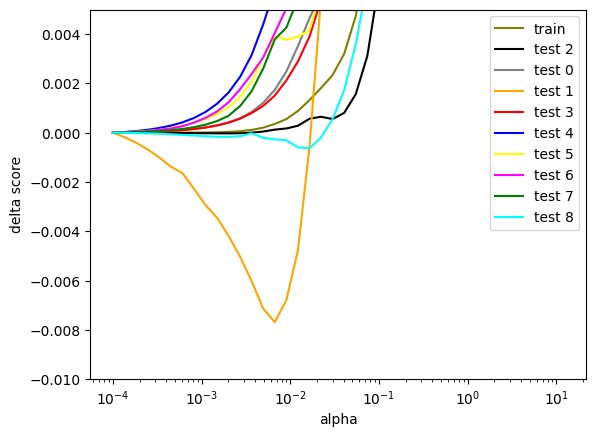

In [74]:
print(listp2)
plt.plot(pars[0,:,0],pars[4,:,2]/pars[3,:,2]-pars[4,0,2]/pars[3,0,2],'-',ms=1,color='olive',label='train')
plt.plot(pars[0,:,0],pars[7,:,2]/pars[6,:,2]-pars[7,0,2]/pars[6,0,2],'-',ms=1,color='black',label='test 2')
plt.plot(pars[0,:,0],pars[7,:,0]/pars[6,:,0]-pars[7,0,0]/pars[6,0,0],'-',ms=1,color='gray',label='test 0')
plt.plot(pars[0,:,0],pars[7,:,1]/pars[6,:,1]-pars[7,0,1]/pars[6,0,1],'-',ms=1,color='orange',label='test 1')
plt.plot(pars[0,:,0],pars[7,:,3]/pars[6,:,3]-pars[7,0,3]/pars[6,0,3],'-',ms=1,color='red',label='test 3')
plt.plot(pars[0,:,0],pars[7,:,4]/pars[6,:,4]-pars[7,0,4]/pars[6,0,4],'-',ms=1,color='blue',label='test 4')
plt.plot(pars[0,:,0],pars[7,:,5]/pars[6,:,5]-pars[7,0,5]/pars[6,0,5],'-',ms=1,color='yellow',label='test 5')
plt.plot(pars[0,:,0],pars[7,:,6]/pars[6,:,6]-pars[7,0,6]/pars[6,0,6],'-',ms=1,color='magenta',label='test 6')
plt.plot(pars[0,:,0],pars[7,:,7]/pars[6,:,7]-pars[7,0,7]/pars[6,0,7],'-',ms=1,color='green',label='test 7')
plt.plot(pars[0,:,0],pars[7,:,8]/pars[6,:,8]-pars[7,0,8]/pars[6,0,8],'-',ms=1,color='cyan',label='test 8')
plt.legend(loc="best")
plt.xlabel("alpha")
plt.ylabel("delta score")
plt.xscale("log")
plt.ylim(-0.01,0.005)
#some limit above to exclude maybe more subsets automatic ofr just repat

(-0.01, 0.005)

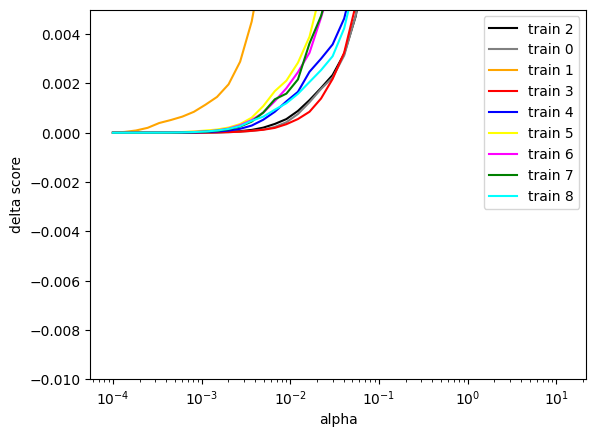

In [75]:
plt.plot(pars[0,:,0],pars[4,:,2]/pars[3,:,2]-pars[4,0,2]/pars[3,0,2],'-',ms=1,color='black',label='train 2')
plt.plot(pars[0,:,0],pars[4,:,0]/pars[3,:,0]-pars[4,0,0]/pars[3,0,0],'-',ms=1,color='gray',label='train 0')
plt.plot(pars[0,:,0],pars[4,:,1]/pars[3,:,1]-pars[4,0,1]/pars[3,0,1],'-',ms=1,color='orange',label='train 1')
plt.plot(pars[0,:,0],pars[4,:,3]/pars[3,:,3]-pars[4,0,3]/pars[3,0,3],'-',ms=1,color='red',label='train 3')
plt.plot(pars[0,:,0],pars[4,:,4]/pars[3,:,4]-pars[4,0,4]/pars[3,0,4],'-',ms=1,color='blue',label='train 4')
plt.plot(pars[0,:,0],pars[4,:,5]/pars[3,:,5]-pars[4,0,5]/pars[3,0,5],'-',ms=1,color='yellow',label='train 5')
plt.plot(pars[0,:,0],pars[4,:,6]/pars[3,:,6]-pars[4,0,6]/pars[3,0,6],'-',ms=1,color='magenta',label='train 6')
plt.plot(pars[0,:,0],pars[4,:,7]/pars[3,:,7]-pars[4,0,7]/pars[3,0,7],'-',ms=1,color='green',label='train 7')
plt.plot(pars[0,:,0],pars[4,:,8]/pars[3,:,8]-pars[4,0,8]/pars[3,0,8],'-',ms=1,color='cyan',label='train 8')
plt.legend(loc="best")
plt.xlabel("alpha")
plt.ylabel("delta score")
plt.xscale("log")
plt.ylim(-0.01,0.005)

In [76]:
for i in range(len(listp2)):
    print(listp2[i])
    delt=abs(pars[7,:,i]/pars[6,:,i]-pars[7,0,i]/pars[6,0,i]-0.002)
    s=np.argsort(delt)
    print(f"it are {int(pars[1,s[0],i])} features")
    reg = Lasso(alpha=pars[0,s[0],0],max_iter=1000).fit(norm_feat_train, tar_train.iloc[:,i]) 
    print(f"needed features are {np.where(reg.coef_!=0,listg2, 0)}")
#number of features varies a lot, without not ideal probably    

eligible_voters
it are 26 features
needed features are ['male' 'single_male' 'single_female' 'married_total' 'widowed_total'
 'divorced_male' 'male_18_24' 'female_18_24' 'male_25_29' 'female_25_29'
 'male_30_39' 'female_30_39' 'male_40_49' 'female_40_49' 'male_50_64'
 'female_50_64' 'male_65_74' 'female_65_74' 'male_75_and_older'
 'female_75_and_older' 'birth_country_germany' 'birth_country_eu27'
 'birth_country_other_europe' 'birth_country_other_continents'
 'religion_catholic' 'religion_protestant']
not_valid_party_votes
it are 26 features
needed features are ['male' 'single_male' 'single_female' 'married_total' 'widowed_total'
 'divorced_male' 'male_18_24' 'female_18_24' 'male_25_29' 'female_25_29'
 'male_30_39' 'female_30_39' 'male_40_49' 'female_40_49' 'male_50_64'
 'female_50_64' 'male_65_74' 'female_65_74' 'male_75_and_older'
 'female_75_and_older' 'birth_country_germany' 'birth_country_eu27'
 'birth_country_other_europe' 'birth_country_other_continents'
 'religion_catholic' 're

In [77]:
#now really feature omitting define function which does it for one label 
#gets features_train, labels_train, features_test, labels_train
def omit1(feat_train,tar_train,feat_test,tar_test,listg):
    statlind4=np.zeros((11,feat_train.shape[1]))
    statlind4[0,:]=np.arange(0,feat_train.shape[1],1)
    for i in range(feat_train.shape[1]):
        norm_feat_train_d4=feat_train.drop(labels=listg[i],axis=1).copy()
        norm_feat_test_d4=feat_test.drop(labels=listg[i],axis=1).copy()
        reg = LinearRegression().fit(norm_feat_train_d4, tar_train) 
        predtr=reg.predict(norm_feat_train_d4)    
        predte=reg.predict(norm_feat_test_d4)
        statlind4[1,i]=tar_train.mean()
        statlind4[2,i]=tar_train.std()  
        statlind4[3,i]=np.std(tar_train-predtr)   
        statlind4[4,i]=tar_test.mean()
        statlind4[5,i]=tar_test.std()  
        statlind4[6,i]=np.std(tar_test-predte)   
        statlind4[7,i]=statlind4[3,i]/statlind4[2,i]
        statlind4[8,i]=statlind4[6,i]/statlind4[5,i]
        statlind4[9,i]=0.5*statlind4[7,i]+0.5*statlind4[8,i]
        statlind4[10,i]=0.8*statlind4[7,i]+0.2*statlind4[8,i]        
    return statlind4

In [78]:
res=omit1(norm_feat_train,tar_train.iloc[:,0],norm_feat_test,tar_test.iloc[:,0],listg2)
print(res[7:11])

[[0.5591548  0.55823916 0.56006248 0.55821002 0.56666508 0.56039381
  0.55806857 0.55802519 0.55803256 0.55957173 0.55819196 0.57010687
  0.55846961 0.56844966 0.55913332 0.56284463 0.55802551 0.56114228
  0.56036131 0.5624136  0.55872117 0.55867684 0.56082792 0.56071359
  0.59812769 0.58801316]
 [0.58898457 0.58586913 0.58074888 0.5834804  0.60812365 0.59102082
  0.58507075 0.58451336 0.58533053 0.58513403 0.58564179 0.59283185
  0.58341485 0.5904295  0.59056362 0.59159261 0.58466073 0.58743127
  0.58335232 0.59907127 0.58638314 0.58579189 0.58640464 0.58889277
  0.64075633 0.62657438]
 [0.57406968 0.57205415 0.57040568 0.57084521 0.58739437 0.57570731
  0.57156966 0.57126928 0.57168155 0.57235288 0.57191688 0.58146936
  0.57094223 0.57943958 0.57484847 0.57721862 0.57134312 0.57428678
  0.57185681 0.58074243 0.57255216 0.57223436 0.57361628 0.57480318
  0.61944201 0.60729377]
 [0.56512075 0.56376516 0.56419976 0.5632641  0.5749568  0.56651921
  0.563469   0.56332282 0.56349215 0.5646

In [79]:
#as before but add iterations to it and which is minimized 
def itomit(feat_train,tar_train,feat_test,tar_test,listg,x,y):
    its=np.zeros((11,x))
    print("iteration 0")
    res=omit1(feat_train,tar_train,feat_test,tar_test,listg)
    s=np.argmin(res[y,:])
    print(f"omitted is {listg[s]}")
    its[:,0]=res[:,s]
    listd2=[listg[s]]
    listg2=listg.copy()
    listg2.remove(listg[s])
    feat_train2=feat_train.drop(labels=listg[s],axis=1).copy()
    feat_test2=feat_test.drop(labels=listg[s],axis=1).copy()  
    feat_train=feat_train2.copy()
    feat_test=feat_test2.copy() 
    for j in range (1,x):
        print(f"iteration {j}")
        res=omit1(feat_train,tar_train,feat_test,tar_test,listg2)
        s=np.argmin(res[y,:])
        print(f"omitted is {listg2[s]}")
        its[:,j]=res[:,s]
        listd2.append(listg2[s])
        listg2=listg2.copy()
        listg2.remove(listg2[s])
        feat_train2=feat_train.drop(labels=listd2[j],axis=1).copy()
        feat_test2=feat_test.drop(labels=listd2[j],axis=1).copy() 
        feat_train=feat_train2.copy()
        feat_test=feat_test2.copy() 
    return listd2, its


In [80]:
#now all targets at once
#input features_train, targets_train, features_test, targets_test, how many features to omitted, 
#what fraction test  used 
def itomita(feat_train3,tar_train2,feat_test3,tar_test2,listg,x,y):
    its=np.zeros((11,int(x+1),tar_train2.shape[1]))
    lista=[]
    for i in range(tar_train2.shape[1]):
        #copy because they will be changed by removing features
        feat_test=feat_test3.copy()        
        feat_train=feat_train3.copy()
        tar_train=tar_train2.iloc[:,i]
        tar_test=tar_test2.iloc[:,i]
        print(f"target {i}")
        #nothing omit case
        reg = LinearRegression().fit(feat_train, tar_train) 
        predtr=reg.predict(feat_train)    
        predte=reg.predict(feat_test)
        its[1,0,i]=tar_train.mean()
        its[2,0,i]=tar_train.std()  
        its[3,0,i]=np.std(tar_train-predtr)   
        its[4,0,i]=tar_test.mean()
        its[5,0,i]=tar_test.std()  
        its[6,0,i]=np.std(tar_test-predte)   
        its[7,0,i]=its[3,0,i]/its[2,0,i]
        its[8,0,i]=its[6,0,i]/its[5,0,i]
        its[9,0,i]=0.5*its[7,0,i]+0.5*its[8,0,i]
        its[10,0,i]=0.8*its[7,0,i]+0.2*its[8,0,i]
        print("iteration 0")
        res=omit1(feat_train,tar_train,feat_test,tar_test,listg)
        s=np.argmin(res[7,:]*y+res[8,:]*(1-y))
        print(f"omitted is {listg[s]}")
        its[:,1,i]=res[:,s]
        listd2=[listg[s]]
        listg2=listg.copy()
        listg2.remove(listg[s])
        feat_train2=feat_train.drop(labels=listg[s],axis=1).copy()
        feat_test2=feat_test.drop(labels=listg[s],axis=1).copy()  
        feat_train=feat_train2.copy()
        feat_test=feat_test2.copy() 
        for j in range (1,x):
            print(f"iteration {j}")
            res=omit1(feat_train,tar_train,feat_test,tar_test,listg2)
            s=np.argmin(res[7,:]*y+res[8,:]*(1-y))
            print(f"omitted is {listg2[s]}")
            its[:,j+1,i]=res[:,s]
            listd2.append(listg2[s])
            listg2=listg2.copy()
            listg2.remove(listg2[s])
            feat_train2=feat_train.drop(labels=listd2[j],axis=1).copy()
            feat_test2=feat_test.drop(labels=listd2[j],axis=1).copy() 
            feat_train=feat_train2.copy()
            feat_test=feat_test2.copy() 
        lista.append(listd2)
    return lista, its


In [81]:
#apply on all the targets
listd0,its0=itomit(norm_feat_train,tar_train.iloc[:,0],norm_feat_test,tar_test.iloc[:,0],listg2,25,9)
print(listd0)
print(its0)
listd1,its1=itomit(norm_feat_train,tar_train.iloc[:,1],norm_feat_test,tar_test.iloc[:,1],listg2,25,9)
print(listd0)
print(its1)
listd2,its2=itomit(norm_feat_train,tar_train.iloc[:,2],norm_feat_test,tar_test.iloc[:,2],listg2,25,9)
print(listd0)
print(its2)
listd3,its3=itomit(norm_feat_train,tar_train.iloc[:,3],norm_feat_test,tar_test.iloc[:,3],listg2,25,9)
print(listd3)
print(its3)
listd4,its4=itomit(norm_feat_train,tar_train.iloc[:,4],norm_feat_test,tar_test.iloc[:,4],listg2,25,9)
print(listd4)
print(its4)
listd5,its5=itomit(norm_feat_train,tar_train.iloc[:,5],norm_feat_test,tar_test.iloc[:,5],listg2,25,9)
print(listd5)
print(its5)
listd6,its6=itomit(norm_feat_train,tar_train.iloc[:,6],norm_feat_test,tar_test.iloc[:,6],listg2,25,9)
print(listd6)
print(its6)
listd7,its7=itomit(norm_feat_train,tar_train.iloc[:,7],norm_feat_test,tar_test.iloc[:,7],listg2,25,9)
print(listd7)
print(its7)
listd8,its8=itomit(norm_feat_train,tar_train.iloc[:,8],norm_feat_test,tar_test.iloc[:,8],listg2,25,9)
print(listd8)
print(its8)

iteration 0
omitted is single_female
iteration 1
omitted is male_40_49
iteration 2
omitted is female_18_24
iteration 3
omitted is male_30_39
iteration 4
omitted is male_18_24
iteration 5
omitted is male_65_74
iteration 6
omitted is married_total
iteration 7
omitted is female_25_29
iteration 8
omitted is male
iteration 9
omitted is single_male
iteration 10
omitted is male_25_29
iteration 11
omitted is birth_country_germany
iteration 12
omitted is birth_country_eu27
iteration 13
omitted is male_50_64
iteration 14
omitted is female_50_64
iteration 15
omitted is male_75_and_older
iteration 16
omitted is female_40_49
iteration 17
omitted is female_30_39
iteration 18
omitted is female_75_and_older
iteration 19
omitted is birth_country_other_europe
iteration 20
omitted is divorced_male
iteration 21
omitted is female_65_74
iteration 22
omitted is religion_protestant
iteration 23
omitted is religion_catholic
iteration 24
omitted is birth_country_other_continents
['single_female', 'male_40_49', 

omitted is birth_country_other_continents
iteration 1
omitted is divorced_male
iteration 2
omitted is male_25_29
iteration 3
omitted is birth_country_germany
iteration 4
omitted is female_65_74
iteration 5
omitted is male_18_24
iteration 6
omitted is female_75_and_older
iteration 7
omitted is male
iteration 8
omitted is male_30_39
iteration 9
omitted is male_50_64
iteration 10
omitted is female_40_49
iteration 11
omitted is female_30_39
iteration 12
omitted is female_18_24
iteration 13
omitted is male_40_49
iteration 14
omitted is male_65_74
iteration 15
omitted is single_male
iteration 16
omitted is single_female
iteration 17
omitted is widowed_total
iteration 18
omitted is married_total
iteration 19
omitted is birth_country_eu27
iteration 20
omitted is male_75_and_older
iteration 21
omitted is birth_country_other_europe
iteration 22
omitted is female_50_64
iteration 23
omitted is female_25_29
iteration 24
omitted is religion_protestant
['single_female', 'male_40_49', 'female_18_24', 

omitted is male_25_29
iteration 1
omitted is male
iteration 2
omitted is female_25_29
iteration 3
omitted is female_18_24
iteration 4
omitted is female_50_64
iteration 5
omitted is female_30_39
iteration 6
omitted is male_40_49
iteration 7
omitted is male_18_24
iteration 8
omitted is birth_country_eu27
iteration 9
omitted is birth_country_other_europe
iteration 10
omitted is birth_country_other_continents
iteration 11
omitted is female_65_74
iteration 12
omitted is male_75_and_older
iteration 13
omitted is female_75_and_older
iteration 14
omitted is male_65_74
iteration 15
omitted is birth_country_germany
iteration 16
omitted is divorced_male
iteration 17
omitted is single_female
iteration 18
omitted is female_40_49
iteration 19
omitted is male_30_39
iteration 20
omitted is male_50_64
iteration 21
omitted is single_male
iteration 22
omitted is married_total
iteration 23
omitted is widowed_total
iteration 24
omitted is religion_protestant
['male_25_29', 'male', 'female_25_29', 'female_1

omitted is birth_country_other_europe
iteration 1
omitted is male_65_74
iteration 2
omitted is single_female
iteration 3
omitted is female_75_and_older
iteration 4
omitted is female_30_39
iteration 5
omitted is female_40_49
iteration 6
omitted is married_total
iteration 7
omitted is divorced_male
iteration 8
omitted is birth_country_eu27
iteration 9
omitted is female_50_64
iteration 10
omitted is female_25_29
iteration 11
omitted is male_40_49
iteration 12
omitted is male_18_24
iteration 13
omitted is male_75_and_older
iteration 14
omitted is male_30_39
iteration 15
omitted is female_65_74
iteration 16
omitted is single_male
iteration 17
omitted is male
iteration 18
omitted is birth_country_other_continents
iteration 19
omitted is female_18_24
iteration 20
omitted is male_50_64
iteration 21
omitted is birth_country_germany
iteration 22
omitted is male_25_29
iteration 23
omitted is widowed_total
iteration 24
omitted is religion_protestant
['birth_country_other_europe', 'male_65_74', 'si

omitted is male_75_and_older
iteration 1
omitted is birth_country_other_europe
iteration 2
omitted is male_25_29
iteration 3
omitted is male_40_49
iteration 4
omitted is birth_country_other_continents
iteration 5
omitted is female_25_29
iteration 6
omitted is female_18_24
iteration 7
omitted is married_total
iteration 8
omitted is divorced_male
iteration 9
omitted is single_female
iteration 10
omitted is religion_protestant
iteration 11
omitted is male_30_39
iteration 12
omitted is female_50_64
iteration 13
omitted is male_18_24
iteration 14
omitted is female_65_74
iteration 15
omitted is male
iteration 16
omitted is female_40_49
iteration 17
omitted is female_75_and_older
iteration 18
omitted is male_65_74
iteration 19
omitted is male_50_64
iteration 20
omitted is female_30_39
iteration 21
omitted is widowed_total
iteration 22
omitted is single_male
iteration 23
omitted is birth_country_eu27
iteration 24
omitted is birth_country_germany
['male_75_and_older', 'birth_country_other_europ

In [82]:
#now all at once # seems to work 
listda,itsa=itomita(norm_feat_train,tar_train,norm_feat_test,tar_test,listg2,25,0.5)
print(listda)
print(itsa)

target 0
iteration 0
omitted is single_female
iteration 1
omitted is male_40_49
iteration 2
omitted is female_18_24
iteration 3
omitted is male_30_39
iteration 4
omitted is male_18_24
iteration 5
omitted is male_65_74
iteration 6
omitted is married_total
iteration 7
omitted is female_25_29
iteration 8
omitted is male
iteration 9
omitted is single_male
iteration 10
omitted is male_25_29
iteration 11
omitted is birth_country_germany
iteration 12
omitted is birth_country_eu27
iteration 13
omitted is male_50_64
iteration 14
omitted is female_50_64
iteration 15
omitted is male_75_and_older
iteration 16
omitted is female_40_49
iteration 17
omitted is female_30_39
iteration 18
omitted is female_75_and_older
iteration 19
omitted is birth_country_other_europe
iteration 20
omitted is divorced_male
iteration 21
omitted is female_65_74
iteration 22
omitted is religion_protestant
iteration 23
omitted is religion_catholic
iteration 24
omitted is birth_country_other_continents
target 1
iteration 0
om

omitted is male_30_39
iteration 12
omitted is female_50_64
iteration 13
omitted is male_18_24
iteration 14
omitted is female_65_74
iteration 15
omitted is male
iteration 16
omitted is female_40_49
iteration 17
omitted is female_75_and_older
iteration 18
omitted is male_65_74
iteration 19
omitted is male_50_64
iteration 20
omitted is female_30_39
iteration 21
omitted is widowed_total
iteration 22
omitted is single_male
iteration 23
omitted is birth_country_eu27
iteration 24
omitted is birth_country_germany
[['single_female', 'male_40_49', 'female_18_24', 'male_30_39', 'male_18_24', 'male_65_74', 'married_total', 'female_25_29', 'male', 'single_male', 'male_25_29', 'birth_country_germany', 'birth_country_eu27', 'male_50_64', 'female_50_64', 'male_75_and_older', 'female_40_49', 'female_30_39', 'female_75_and_older', 'birth_country_other_europe', 'divorced_male', 'female_65_74', 'religion_protestant', 'religion_catholic', 'birth_country_other_continents'], ['male_65_74', 'male_30_39', 'bir

In [83]:
#order and number =rs the sane 
print(listd0)
print(listda[0])
print(np.mean(abs(itsa[:,1:26,0]-its0)))
print(np.mean(abs(itsa[:,1:26,1]-its1)))
print(np.mean(abs(itsa[:,1:26,2]-its2)))
print(np.mean(abs(itsa[:,1:26,3]-its3)))
print(np.mean(abs(itsa[:,1:26,4]-its4)))
print(np.mean(abs(itsa[:,1:26,5]-its5)))
print(np.mean(abs(itsa[:,1:26,6]-its6)))
print(np.mean(abs(itsa[:,1:26,7]-its7)))
print(np.mean(abs(itsa[:,1:26,8]-its8)))
#print(its0)
#next add more random  9easiest just seveal indpendent random numbers) 
#needs to through each and majority is final to omit? (cannot mkx more because different is omitted already)
#or is that too complicated for purpose (could also just add one other case and compare it)

['single_female', 'male_40_49', 'female_18_24', 'male_30_39', 'male_18_24', 'male_65_74', 'married_total', 'female_25_29', 'male', 'single_male', 'male_25_29', 'birth_country_germany', 'birth_country_eu27', 'male_50_64', 'female_50_64', 'male_75_and_older', 'female_40_49', 'female_30_39', 'female_75_and_older', 'birth_country_other_europe', 'divorced_male', 'female_65_74', 'religion_protestant', 'religion_catholic', 'birth_country_other_continents']
['single_female', 'male_40_49', 'female_18_24', 'male_30_39', 'male_18_24', 'male_65_74', 'married_total', 'female_25_29', 'male', 'single_male', 'male_25_29', 'birth_country_germany', 'birth_country_eu27', 'male_50_64', 'female_50_64', 'male_75_and_older', 'female_40_49', 'female_30_39', 'female_75_and_older', 'birth_country_other_europe', 'divorced_male', 'female_65_74', 'religion_protestant', 'religion_catholic', 'birth_country_other_continents']
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [84]:
feat_trainb,feat_testb,tar_trainb, tar_testb= train_test_split(feat,tar,train_size=0.80, shuffle=True, random_state=4)
#normalize the features  should use standard scaler or not
norm_feat_trainb=feat_trainb.copy()
norm_feat_testb=feat_testb.copy()
statg2b=np.zeros((2,len(listg2)))
for i in range(len(listg2)):
    m=feat_trainb.iloc[:,i].mean()
    s=feat_trainb.iloc[:,i].std()
    norm_feat_trainb.iloc[:,i]=(feat_trainb.iloc[:,i]-m)/s
    norm_feat_testb.iloc[:,i]=(feat_testb.iloc[:,i]-m)/s
    statg2b[0,i]=m
    statg2b[1,i]=s   

In [85]:
listdab,itsab=itomita(norm_feat_trainb,tar_trainb,norm_feat_testb,tar_testb,listg2,25,0.5)
print(listdab)

target 0
iteration 0
omitted is male_30_39
iteration 1
omitted is married_total
iteration 2
omitted is male_65_74
iteration 3
omitted is female_18_24
iteration 4
omitted is male_18_24
iteration 5
omitted is male_40_49
iteration 6
omitted is male_25_29
iteration 7
omitted is birth_country_germany
iteration 8
omitted is birth_country_eu27
iteration 9
omitted is male_75_and_older
iteration 10
omitted is male_50_64
iteration 11
omitted is single_female
iteration 12
omitted is male
iteration 13
omitted is female_25_29
iteration 14
omitted is female_50_64
iteration 15
omitted is female_40_49
iteration 16
omitted is female_65_74
iteration 17
omitted is female_30_39
iteration 18
omitted is female_75_and_older
iteration 19
omitted is birth_country_other_continents
iteration 20
omitted is divorced_male
iteration 21
omitted is single_male
iteration 22
omitted is religion_protestant
iteration 23
omitted is religion_catholic
iteration 24
omitted is birth_country_other_europe
target 1
iteration 0
om

omitted is birth_country_other_europe
iteration 12
omitted is male_30_39
iteration 13
omitted is male_18_24
iteration 14
omitted is female_25_29
iteration 15
omitted is married_total
iteration 16
omitted is female_18_24
iteration 17
omitted is male_65_74
iteration 18
omitted is male_75_and_older
iteration 19
omitted is female_50_64
iteration 20
omitted is female_30_39
iteration 21
omitted is widowed_total
iteration 22
omitted is single_male
iteration 23
omitted is birth_country_eu27
iteration 24
omitted is birth_country_germany
[['male_30_39', 'married_total', 'male_65_74', 'female_18_24', 'male_18_24', 'male_40_49', 'male_25_29', 'birth_country_germany', 'birth_country_eu27', 'male_75_and_older', 'male_50_64', 'single_female', 'male', 'female_25_29', 'female_50_64', 'female_40_49', 'female_65_74', 'female_30_39', 'female_75_and_older', 'birth_country_other_continents', 'divorced_male', 'single_male', 'religion_protestant', 'religion_catholic', 'birth_country_other_europe'], ['female_6

Text(0, 0.5, 'test score')

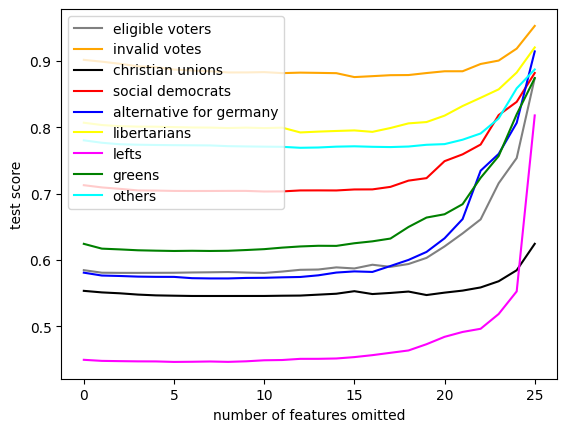

In [86]:
omit=np.arange(1,26,1)
omitb=np.arange(0,26,1)
listp4=['eligible voters','invalid votes','christian unions', 'social democrats', 'alternative for germany', 'libertarians', 'lefts', 'greens', 'others']
plt.plot(omitb,itsa[8,:,0],'-',ms=1,color='gray',label=listp4[0])
plt.plot(omitb,itsa[8,:,1],'-',ms=1,color='orange',label=listp4[1])
plt.plot(omitb,itsa[8,:,2],'-',ms=1,color='black',label=listp4[2])
plt.plot(omitb,itsa[8,:,3],'-',ms=1,color='red',label=listp4[3])
plt.plot(omitb,itsa[8,:,4],'-',ms=1,color='blue',label=listp4[4])
plt.plot(omitb,itsa[8,:,5],'-',ms=1,color='yellow',label=listp4[5])
plt.plot(omitb,itsa[8,:,6],'-',ms=1,color='magenta',label=listp4[6])
plt.plot(omitb,itsa[8,:,7],'-',ms=1,color='green',label=listp4[7])
plt.plot(omitb,itsa[8,:,8],'-',ms=1,color='cyan',label=listp4[8])
plt.legend(loc="best")
plt.xlabel("number of features omitted")
plt.ylabel("test score")
#plt.xscale("log")
#plt.ylim(-0.01,0.005)
#o.k. maybe more partitation of data? 

(-0.027, 0.05)

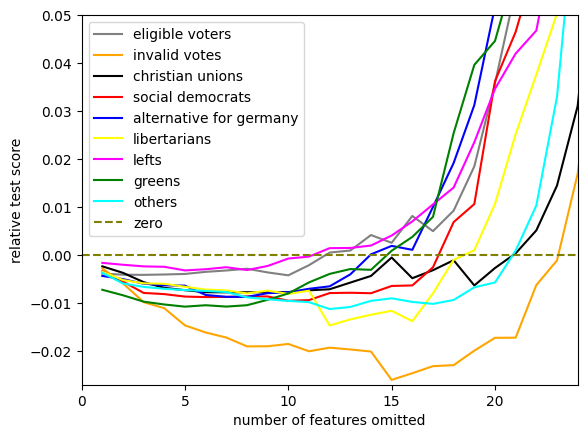

In [87]:

plt.plot(omit,itsa[8,1:26,0]-itsa[8,0,0],'-',ms=1,color='gray',label=listp4[0])
plt.plot(omit,itsa[8,1:26,1]-itsa[8,0,1],'-',ms=1,color='orange',label=listp4[1])
plt.plot(omit,itsa[8,1:,2]-itsa[8,0,2],'-',ms=1,color='black',label=listp4[2])
plt.plot(omit,itsa[8,1:,3]-itsa[8,0,3],'-',ms=1,color='red',label=listp4[3])
plt.plot(omit,itsa[8,1:,4]-itsa[8,0,4],'-',ms=1,color='blue',label=listp4[4])
plt.plot(omit,itsa[8,1:,5]-itsa[8,0,5],'-',ms=1,color='yellow',label=listp4[5])
plt.plot(omit,itsa[8,1:,6]-itsa[8,0,6],'-',ms=1,color='magenta',label=listp4[6])
plt.plot(omit,itsa[8,1:,7]-itsa[8,0,7],'-',ms=1,color='green',label=listp4[7])
plt.plot(omit,itsa[8,1:,8]-itsa[8,0,8],'-',ms=1,color='cyan',label=listp4[8])
plt.axhline(y=0, color='olive', linestyle='--', label='zero')
plt.legend(loc="best")
plt.xlabel("number of features omitted")
plt.ylabel("relative test score")
plt.xlim(0,24)
plt.ylim(-0.027, 0.05)



(-0.027, 0.05)

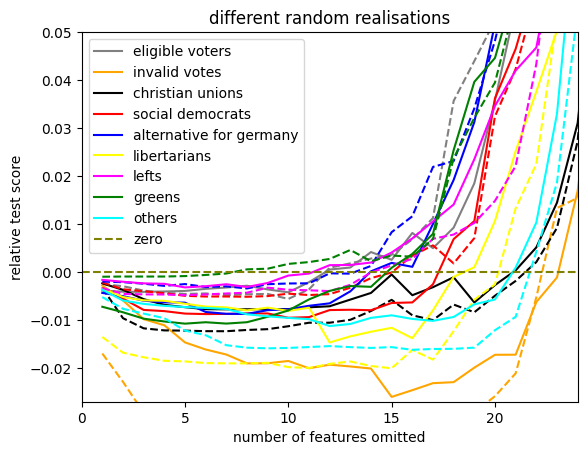

In [88]:
plt.plot(omit,itsa[8,1:26,0]-itsa[8,0,0],'-',ms=1,color='gray',label=listp4[0])
plt.plot(omit,itsab[8,1:26,0]-itsab[8,0,0],'--',ms=1,color='gray')
plt.plot(omit,itsa[8,1:26,1]-itsa[8,0,1],'-',ms=1,color='orange',label=listp4[1])
plt.plot(omit,itsab[8,1:,1]-itsab[8,0,1],'--',ms=1,color='orange')
plt.plot(omit,itsa[8,1:,2]-itsa[8,0,2],'-',ms=1,color='black',label=listp4[2])
plt.plot(omit,itsab[8,1:,2]-itsab[8,0,2],'--',ms=1,color='black')
plt.plot(omit,itsa[8,1:,3]-itsa[8,0,3],'-',ms=1,color='red',label=listp4[3])
plt.plot(omit,itsab[8,1:,3]-itsab[8,0,3],'--',ms=1,color='red')
plt.plot(omit,itsa[8,1:,4]-itsa[8,0,4],'-',ms=1,color='blue',label=listp4[4])
plt.plot(omit,itsab[8,1:,4]-itsab[8,0,4],'--',ms=1,color='blue')
plt.plot(omit,itsa[8,1:,5]-itsa[8,0,5],'-',ms=1,color='yellow',label=listp4[5])
plt.plot(omit,itsab[8,1:,5]-itsab[8,0,5],'--',ms=1,color='yellow')
plt.plot(omit,itsa[8,1:,6]-itsa[8,0,6],'-',ms=1,color='magenta',label=listp4[6])
plt.plot(omit,itsab[8,1:,6]-itsab[8,0,6],'--',ms=1,color='magenta')
plt.plot(omit,itsa[8,1:,7]-itsa[8,0,7],'-',ms=1,color='green',label=listp4[7])
plt.plot(omit,itsab[8,1:,7]-itsab[8,0,7],'--',ms=1,color='green')
plt.plot(omit,itsa[8,1:,8]-itsa[8,0,8],'-',ms=1,color='cyan',label=listp4[8])
plt.plot(omit,itsab[8,1:,8]-itsab[8,0,8],'--',ms=1,color='cyan')
plt.axhline(y=0, color='olive', linestyle='--', label='zero')
plt.legend(loc="best")
plt.xlabel("number of features omitted")
plt.ylabel("relative test score")
plt.title("different random realisations")
plt.xlim(0,24)
plt.ylim(-0.027, 0.05)



In our fit we omit always the feature without which the combined score (average of test and train) improves most. In all cases the score improves first indicating that there was overfitting. The amount varies a lot. For eligle voters after only 7 features the score is again as large as before. For all others at least 11 features can be omitted without decreasing the performcance on test, 21 in case of others. 

In [89]:
#function to run a number of random realisations
#for now no summarizing results yet
def random_rel(feat,tar,listg,x,y,z):
    its=np.zeros((11,int(x+1),tar.shape[1],int(z)))
    lista=[]
    for j in range(z):
        print(f"random realisation {j}")
        feat_train2,feat_test2,tar_train2, tar_test2= train_test_split(feat,tar,train_size=0.80, shuffle=True, random_state=(int(j)))
        norm_feat_trainb=feat_train2.copy()
        norm_feat_testb=feat_test2.copy()

        for i in range(feat_trainb.shape[1]):
            m=feat_train2.iloc[:,i].mean()
            s=feat_train2.iloc[:,i].std()
            norm_feat_trainb.iloc[:,i]=(feat_train2.iloc[:,i]-m)/s
            norm_feat_testb.iloc[:,i]=(feat_test2.iloc[:,i]-m)/s
        listdab,itsab=itomita(norm_feat_trainb,tar_trainb,norm_feat_testb,tar_testb,listg2,x,y)    
        its[:,:,:,j]=itsab
        lista.append(listdab)
    return its, lista        

Now we run several random realisations. We use only test as metric, the averaging of several will cause that also train is considered.

In [90]:
#was done before with 20 ransom realisation now here in with just two important results are loaded as pickled
randomscore,randomlist=random_rel(feat,tar,listg2,25,0,2)
with open('randomscore2.pickle', 'wb') as f:
    # Pickle 
    pickle.dump(randomscore, f, pickle.HIGHEST_PROTOCOL)
with open('randomlist2.pickle', 'wb') as f:
    # Pickle 
    pickle.dump(randomlist, f, pickle.HIGHEST_PROTOCOL)    

random realisation 0
target 0
iteration 0
omitted is female_40_49
iteration 1
omitted is male_30_39
iteration 2
omitted is male_75_and_older
iteration 3
omitted is birth_country_germany
iteration 4
omitted is birth_country_eu27
iteration 5
omitted is female_25_29
iteration 6
omitted is male_40_49
iteration 7
omitted is birth_country_other_continents
iteration 8
omitted is female_65_74
iteration 9
omitted is single_female
iteration 10
omitted is male_65_74
iteration 11
omitted is male_50_64
iteration 12
omitted is religion_catholic
iteration 13
omitted is religion_protestant
iteration 14
omitted is birth_country_other_europe
iteration 15
omitted is male_25_29
iteration 16
omitted is female_50_64
iteration 17
omitted is divorced_male
iteration 18
omitted is female_75_and_older
iteration 19
omitted is female_18_24
iteration 20
omitted is male_18_24
iteration 21
omitted is male
iteration 22
omitted is single_male
iteration 23
omitted is widowed_total
iteration 24
omitted is married_total
t

omitted is single_female
iteration 11
omitted is religion_protestant
iteration 12
omitted is religion_catholic
iteration 13
omitted is birth_country_other_europe
iteration 14
omitted is birth_country_other_continents
iteration 15
omitted is male_40_49
iteration 16
omitted is female_30_39
iteration 17
omitted is divorced_male
iteration 18
omitted is married_total
iteration 19
omitted is male_30_39
iteration 20
omitted is birth_country_eu27
iteration 21
omitted is female_25_29
iteration 22
omitted is birth_country_germany
iteration 23
omitted is male
iteration 24
omitted is female_18_24
random realisation 1
target 0
iteration 0
omitted is female_65_74
iteration 1
omitted is male_50_64
iteration 2
omitted is female_75_and_older
iteration 3
omitted is female_25_29
iteration 4
omitted is birth_country_other_europe
iteration 5
omitted is birth_country_eu27
iteration 6
omitted is female_40_49
iteration 7
omitted is religion_catholic
iteration 8
omitted is single_male
iteration 9
omitted is wi

omitted is single_female
iteration 22
omitted is widowed_total
iteration 23
omitted is female_30_39
iteration 24
omitted is married_total
target 8
iteration 0
omitted is female_40_49
iteration 1
omitted is male_75_and_older
iteration 2
omitted is single_female
iteration 3
omitted is widowed_total
iteration 4
omitted is female_25_29
iteration 5
omitted is birth_country_other_europe
iteration 6
omitted is birth_country_germany
iteration 7
omitted is religion_catholic
iteration 8
omitted is religion_protestant
iteration 9
omitted is male_25_29
iteration 10
omitted is divorced_male
iteration 11
omitted is single_male
iteration 12
omitted is married_total
iteration 13
omitted is birth_country_eu27
iteration 14
omitted is male_30_39
iteration 15
omitted is female_75_and_older
iteration 16
omitted is birth_country_other_continents
iteration 17
omitted is female_65_74
iteration 18
omitted is female_18_24
iteration 19
omitted is female_50_64
iteration 20
omitted is female_30_39
iteration 21
omi

In [91]:
#loading the 20 realisations results
with open('randomlist1.pickle', 'rb') as f:
    # unpickle
    randomlist = pickle.load(f)
with open('randomscore1.pickle', 'rb') as f:
    # unpickle
    randomscore = pickle.load(f)    
print(randomlist)

[[['female_40_49', 'male_30_39', 'male_75_and_older', 'birth_country_germany', 'birth_country_eu27', 'female_25_29', 'male_40_49', 'birth_country_other_continents', 'female_65_74', 'single_female', 'male_65_74', 'male_50_64', 'religion_catholic', 'religion_protestant', 'birth_country_other_europe', 'male_25_29', 'female_50_64', 'divorced_male', 'female_75_and_older', 'female_18_24', 'male_18_24', 'male', 'single_male', 'widowed_total', 'married_total'], ['birth_country_other_europe', 'female_40_49', 'male_18_24', 'male_50_64', 'religion_catholic', 'female_65_74', 'female_25_29', 'birth_country_germany', 'birth_country_eu27', 'birth_country_other_continents', 'single_female', 'married_total', 'female_50_64', 'female_30_39', 'divorced_male', 'male_40_49', 'female_75_and_older', 'single_male', 'male', 'widowed_total', 'male_30_39', 'male_25_29', 'religion_protestant', 'male_75_and_older', 'male_65_74'], ['female_40_49', 'birth_country_other_europe', 'female_25_29', 'female_30_39', 'male_2

In [92]:
#Figure where it goes above 0 again
a=its0[8,:]-statlin[5,0]/statlin[4,0]
count=np.zeros((len(listp2)+1,len(listg2)))
print(f"for {listp4[0]}")
for i in range(len(a)-1):
    if a[i]<0 and a[i+1]>0:
        print(f"excluded are {i} properties")
        print(f"delta score with them/with 1 more are {a[i:i+2]}")
        print(f"excluded are {listd0[0:i+1]}")
        for j in range(i+1):
            for k in range(len(listg2)):
                if listg2[k]==listd0[j]:
                    count[0,k]=1
        print(count[0])       
 
  
a=its1[8,:]-statlin[5,1]/statlin[4,1]
print(f"for {listp4[1]}")
for i in range(len(a)-1):
    if a[i]<0 and a[i+1]>0:
        print(f"excluded are {i} properties")
        print(f"delta score with them/with 1 more are {a[i:i+2]}")
        print(f"excluded are {listd1[0:i+1]}")
        for j in range(i+1):
            for k in range(len(listg2)):
                if listg2[k]==listd1[j]:
                    count[1,k]=1
        print(count[1])       
         
        
a=its2[8,:]-statlin[5,2]/statlin[4,2]
print(f"for {listp4[2]}")
for i in range(len(a)-1):
    if a[i]<0 and a[i+1]>0:
        print(f"excluded are {i} properties")
        print(f"delta score with them/with 1 more are {a[i:i+2]}")
        print(f"excluded are {listd2[0:i+1]}")     
        for j in range(i+1):
            for k in range(len(listg2)):
                if listg2[k]==listd2[j]:
                    count[2,k]=1
        print(count[2])       
x=3
a=its3[8,:]-statlin[5,x]/statlin[4,x]
print(f"for {listp4[x]}")
for i in range(len(a)-1):
    if a[i]<0 and a[i+1]>0:
        print(f"excluded are {i} properties")
        print(f"delta score with them/with 1 more are {a[i:i+2]}")
        print(f"excluded are {listd3[0:i+1]}")  
        for j in range(i+1):
            for k in range(len(listg2)):
                if listg2[k]==listd3[j]:
                    count[4,k]=1
        print(count[3])       
      
x=4
a=its4[8,:]-statlin[5,x]/statlin[4,x]
print(f"for {listp4[x]}")
for i in range(len(a)-1):
    if a[i]<0 and a[i+1]>0:
        print(f"excluded are {i} properties")
        print(f"delta score with them/with 1 more are {a[i:i+2]}")
        print(f"excluded are {listd4[0:i+1]}")   
        for j in range(i+1):
            for k in range(len(listg2)):
                if listg2[k]==listd4[j]:
                    count[4,k]=1
        print(count[4])       
        
x=5
a=its5[8,:]-statlin[5,x]/statlin[4,x]
print(f"for {listp4[x]}")
for i in range(len(a)-1):
    if a[i]<0 and a[i+1]>0:
        print(f"excluded are {i} properties")
        print(f"delta score with them/with 1 more are {a[i:i+2]}")
        print(f"excluded are {listd5[0:i+1]}")  
        for j in range(i+1):
            for k in range(len(listg2)):
                if listg2[k]==listd5[j]:
                    count[5,k]=1
        print(count[5])       
         
x=6
a=its6[8,:]-statlin[5,x]/statlin[4,x]
print(f"for {listp4[x]}")
for i in range(len(a)-1):
    if a[i]<0 and a[i+1]>0:
        print(f"excluded are {i} properties")
        print(f"delta score with them/with 1 more are {a[i:i+2]}")
        print(f"excluded are {listd6[0:i+1]}")  
        for j in range(i+1):
            for k in range(len(listg2)):
                if listg2[k]==listd6[j]:
                    count[x,k]=1
        print(count[x])       
       
x=7
a=its7[8,:]-statlin[5,x]/statlin[4,x]
print(f"for {listp4[x]}")
for i in range(len(a)-1):
    if a[i]<0 and a[i+1]>0:
        print(f"excluded are {i} properties")
        print(f"delta score with them/with 1 more are {a[i:i+2]}")
        print(f"excluded are {listd7[0:i+1]}")  
        for j in range(i+1):
            for k in range(len(listg2)):
                if listg2[k]==listd7[j]:
                    count[x,k]=1
        print(count[x])       
      
x=8
a=its8[8,:]-statlin[5,x]/statlin[4,x]
print(f"for {listp4[x]}")
for i in range(len(a)-1):
    if a[i]<0 and a[i+1]>0:
        print(f"excluded are {i} properties")
        print(f"delta score with them/with 1 more are {a[i:i+2]}")
        print(f"excluded are {listd8[0:i+1]}")  
        for j in range(i+1):
            for k in range(len(listg2)):
                if listg2[k]==listd7[j]:
                    count[x,k]=1
        print(count[x])             

for eligible voters
excluded are 10 properties
delta score with them/with 1 more are [-0.00209779  0.0005326 ]
excluded are ['single_female', 'male_40_49', 'female_18_24', 'male_30_39', 'male_18_24', 'male_65_74', 'married_total', 'female_25_29', 'male', 'single_male', 'male_25_29']
[1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
for invalid votes
excluded are 22 properties
delta score with them/with 1 more are [-0.00110929  0.01693874]
excluded are ['male_65_74', 'male_30_39', 'birth_country_germany', 'female_50_64', 'widowed_total', 'married_total', 'single_male', 'female_18_24', 'female_25_29', 'male_18_24', 'divorced_male', 'female_75_and_older', 'male', 'female_65_74', 'male_75_and_older', 'male_25_29', 'birth_country_other_europe', 'single_female', 'male_40_49', 'female_30_39', 'religion_protestant', 'birth_country_eu27', 'birth_country_other_continents']
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1.]
for christia

Text(0, 0.5, 'number of times omitted')

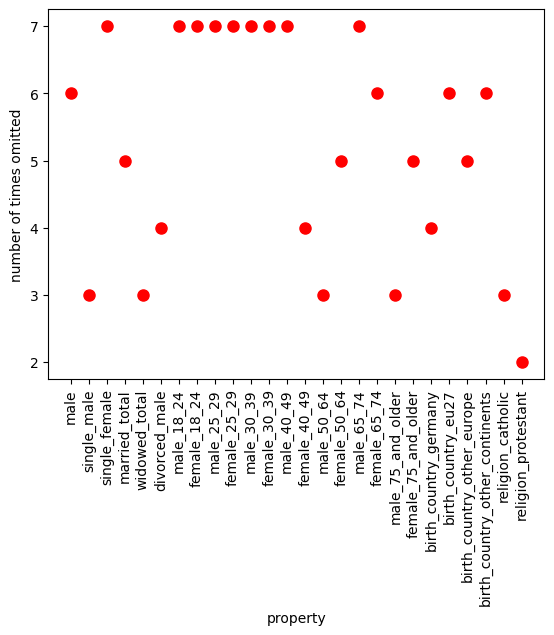

In [93]:
for i in range(len(listg2)):
    count[9,i]=sum(count[0:9,i])
    
plt.plot(listg2,count[9],'o',ms=8,color='red',label='all')
#plt.legend(loc="best")
plt.xlabel("property")
plt.xticks(rotation='vertical')
plt.ylabel("number of times omitted")

['male', 'single_male', 'single_female', 'married_total', 'widowed_total', 'divorced_male', 'male_18_24', 'female_18_24', 'male_25_29', 'female_25_29', 'male_30_39', 'female_30_39', 'male_40_49', 'female_40_49', 'male_50_64', 'female_50_64', 'male_65_74', 'female_65_74', 'male_75_and_older', 'female_75_and_older', 'birth_country_germany', 'birth_country_eu27', 'birth_country_other_europe', 'birth_country_other_continents', 'religion_catholic', 'religion_protestant']
['eligible_voters', 'not_valid_party_votes', 'christian_unions_party_votes', 'social_democrats_party_votes', 'alternative_for_germany_party_votes', 'libertarians_party_votes', 'lefts_party_votes', 'greens_party_votes', 'others_party_votes']
['male', 'single_male', 'single_female', 'married_total', 'widowed_total', 'divorced_male', 'male_18_24', 'female_18_24', 'male_25_29', 'female_25_29', 'male_30_39', 'female_30_39', 'male_40_49', 'female_40_49', 'male_50_64', 'female_50_64', 'male_65_74', 'female_65_74', 'male_75_and_old

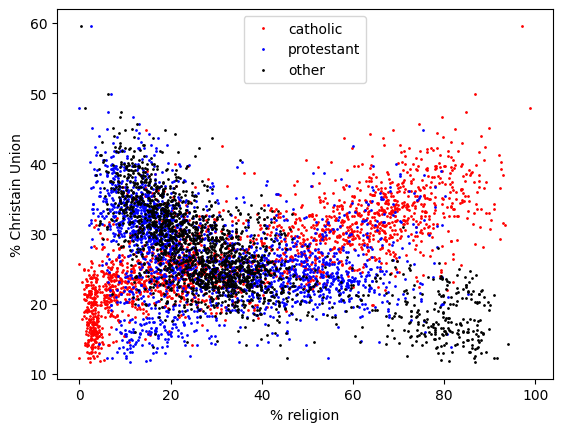

In [94]:
print(listg2)
print(listp2)
plt.plot(feat_train['religion_catholic'],tar_train['christian_unions_party_votes'],'o',ms=1,color='red',label='catholic')
plt.plot(feat_train['religion_protestant'],tar_train['christian_unions_party_votes'],'o',ms=1,color='blue',label='protestant') 
plt.plot(100-feat_train['religion_catholic']-feat_train['religion_protestant'],tar_train['christian_unions_party_votes'],'o',ms=1,color='black',label='other')
plt.legend(loc="best")
plt.xlabel("% religion")
plt.ylabel("% Christain Union")
#plt.xscale("log")
#plt.yscale("log")
print(listg2)
#plot seems right why tehn coeeficient wrong? 

For most properties until now only few rather small countries are missing. This is no different for extreme poverty. We check how that relates with GDP per capita. 

In [95]:
reg = RandomForestRegressor(random_state=1,max_samples=0.5)
statfor=np.zeros((5,len(listp2)))
for i in range(0, len(listp2)):  
    statfor[0,i]=i
    print(listp2[i])

    reg.fit(feat_train,tar_train.iloc[:,i])
    predtr= reg.predict(feat_train)
    predte= reg.predict(feat_test)  
    statfor[1,i]=np.std(tar_train.iloc[:,i])    
    statfor[2,i]=np.std(predtr-tar_train.iloc[:,i])
    statfor[3,i]=np.std(tar_test.iloc[:,i])    
    statfor[4,i]=np.std(predte-tar_test.iloc[:,i])   

eligible_voters
not_valid_party_votes
christian_unions_party_votes
social_democrats_party_votes
alternative_for_germany_party_votes
libertarians_party_votes
lefts_party_votes
greens_party_votes
others_party_votes


In [96]:
    
print(np.round(statfor.T,3))
plt.plot(statlin[6],100*statlin[2]/statlin[1],'*',ms=6,color='black',label='linear regression train') 
plt.plot(statlin[6],100*statlin[5]/statlin[4],'*',ms=5,color='red',label='linear regression test') 
plt.plot(statfor[0],100*statfor[2]/statfor[1],'o',ms=6,color='blue',label='random regressor train') 
plt.plot(statfor[0],100*statfor[4]/statfor[3],'o',ms=5,color='green',label='random regressor test') 
plt.legend(loc="best")
plt.ylabel("% standard deviation fitted/standard deviation data")
plt.xlabel("target label number")
#plt.yscale("log")
#random rgessor better bit not much still unclear why coefficent are as they are

[[0.    9.211 3.135 9.04  5.059]
 [1.    0.426 0.203 0.457 0.388]
 [2.    6.524 2.075 6.44  3.219]
 [3.    7.064 2.648 6.751 4.168]
 [4.    5.823 1.786 6.203 2.984]
 [5.    2.807 1.197 2.941 2.169]
 [6.    2.402 0.63  2.314 0.966]
 [7.    5.131 1.557 4.982 2.543]
 [8.    4.29  1.611 4.286 2.621]]


Text(0.5, 0, 'target label number')

The coefficients of the fit can be used to obtain tyhe fraction of one category for the data. The calculation assume that categories are independent of each other. That assumption is not correct, since thwere are correlations. 

In [97]:

#normalized means that mean values are already the base
rel=np.zeros((3,9))
for i in range(9):
    rel[0,i]=coefs[26,i]+coefs[24,i]*(100-statg2[0,24])/statg2[1,24]+coefs[25,i]*(0-statg2[0,25])/statg2[1,25]
    rel[1,i]=coefs[26,i]+coefs[24,i]*(0-statg2[0,24])/statg2[1,24]+coefs[25,i]*(100-statg2[0,25])/statg2[1,25]
    rel[2,i]=coefs[26,i]+coefs[24,i]*(0-statg2[0,24])/statg2[1,24]+coefs[25,i]*(0-statg2[0,25])/statg2[1,25]    
print(rel)
print(statg2[0,25])

[[125.4323925    0.6533269   37.04028577  19.79043429   6.84686562
   10.84648522   1.2733106   10.15310741  14.04951109]
 [124.5395991    0.78244126  25.23805012  32.51231736   5.14064094
   12.06938496   0.83405796  16.72002718   7.48552148]
 [141.95190067   1.2592202   17.53334589  22.72544381  22.05030953
   12.28416347   9.11713686   9.42587138   6.86372907]]
30.324389005244896


In [98]:
print(listp2[2:9])
listp3=['christian unions', 'social democrats', 'alternative for germany', 'libertarians', 'lefts', 'greens', 'others']

['christian_unions_party_votes', 'social_democrats_party_votes', 'alternative_for_germany_party_votes', 'libertarians_party_votes', 'lefts_party_votes', 'greens_party_votes', 'others_party_votes']


Text(0.5, 1.0, 'religion')

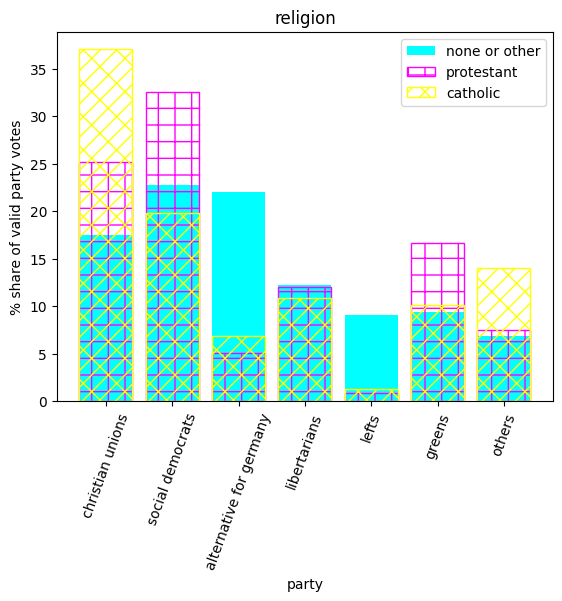

In [99]:
plt.bar(listp3,rel[2,2:9],facecolor='cyan',label='none or other') 
plt.bar(listp3,rel[1,2:9],facecolor='none',edgecolor='magenta',hatch='+',label='protestant') 
plt.bar(listp3,rel[0,2:9],facecolor='none',edgecolor='yellow',hatch='\//',label='catholic') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% share of valid party votes")
plt.xlabel("party")
plt.title("religion")

The fact that the predictions in test are usually worse than in train shows that there are strong correlation between difefrent parameters. Besides making slightly predictions worse it also makes it very difficult to find which paramters matter most. Therefore we now omitt one parameter after the other starting with the full data sets.

Smallest is single female

We now analyse the religion voting pattern which seems to be one of the most important indicators. For the analysis we just use catholic and protestant, since the rest is fully determined by it. The rest is a combination of several, most important of non believers, but also of anthing else besides roman catholic and the main protestant church.  Besides the full Germany analysis we also split the sample into West and East to see how much of the variatian is caused by that. 

In [178]:
#function to fit one category to determine voting pattern per group 
#input full data, features(last is ignored), list of targets
def catfitting(data,listf,listt):
    for i in range(len(listf)-1):
        #exclude rows with bad data
         data=data[(data[listf[i]]>-0.5) & (data['qual_'+listf[i]]!=1)]
    #select features         
    feat=data.loc[:,listf[0:len(listf)-1]]
    for i in range(len(listf)-1):
       #get % of population
       feat.iloc[:,i]=feat.iloc[:,i]/data.loc[:,'population']*100
    #normalize now with mean and standard deviation
    stat=np.zeros((2,len(listf)-1))
    for i in range(len(listf)-1):
        m=feat.iloc[:,i].mean()
        s=feat.iloc[:,i].std()
        feat.iloc[:,i]=(feat.iloc[:,i]-m)/s
        stat[0,i]=m
        stat[1,i]=s    
    #get targets (are several which are fit after each other)    
    tar=data.loc[:,listt]
    for i in range(len(listt)):
        tar.iloc[:,i]=tar.iloc[:,i]/data.loc[:,'eligible_voters']*100    
    #coefficients and intercpt of fit    
    coefs=np.zeros((feat.shape[1]+1,len(listt)))
    #statistic like score of fits
    statlin=np.zeros((3,len(listt)))
    for i in range(len(listt)):
        reg = LinearRegression().fit(feat,tar.iloc[:,i]) 
        coefs[0:feat.shape[1],i]=reg.coef_
        coefs[feat.shape[1],i]=reg.intercept_
        predr=reg.predict(feat)    
        statlin[0,i]=tar.iloc[:,i].mean()
        statlin[1,i]=tar.iloc[:,i].std()  
        #fit score
        statlin[2,i]=np.std(tar.iloc[:,i]-predr)
    # get percentage of the groups of the category
    per=np.zeros((feat.shape[1]+1,len(listt)))
    for i in range(len(listt)):
        per[:,i]=coefs[len(listf)-1,i]
        #loop over which property to get %
        for j in range(len(listf)):
            #loop over contributions
            for k in range(len(listf)-1):
                #the contribution of the target for fitted features
                if j==k and j<int(len(listf)-1):
                    per[j,i]+=coefs[k,i]*(100-stat[0,k])/stat[1,k]
                #of the others  for fitted features
                if j!=k and j<int(len(listf)-1):   
                    per[j,i]+=coefs[k,i]*(0-stat[0,k])/stat[1,k]                                                              
                #of not fitted features
                if j>=int(len(listf)-1):   
                    per[j,i]+=coefs[k,i]*(0-stat[0,k])/stat[1,k]                                                                     
    #returns (mean, scatter, fitted scater), coefficients and percentage per property
    return statlin, coefs, per               

In [179]:
#list of parties and co
listp4=['valid_party_votes','not_valid_party_votes', 'christian_unions_party_votes', 'social_democrats_party_votes', 'alternative_for_germany_party_votes', 'libertarians_party_votes', 'lefts_party_votes', 'greens_party_votes', 'others_party_votes']
#select religion
listrel=listg2[24:27]
#add other
listrel.append('religion_other')
print(listrel)
#divide germany in east and west 
sel2e=sel2[sel2['unification']=='East']
sel2w=sel2[sel2['unification']=='West']
#fit full, west east
statrel_f,coefrel_f,perrel_f =catfitting(sel2,listrel,listp4)
statrel_w,coefrel_w,perrel_w =catfitting(sel2w,listrel,listp4)
statrel_e,coefrel_e,perrel_e =catfitting(sel2e,listrel,listp4)

['religion_catholic', 'religion_protestant', 'religion_other']


First we look at turnout. We use here as elsewhere valid votes. While that is not the usual definition it is similar due to the small number of invalid votes. More importantly, it makes the calculations for parties below easier, because we displayed the fraction of valid votes, by using the turnout of valid votes in each category. 

In [215]:
listf=['Germany','West','East']
#comboine part for plotting by east west 
perrel=np.zeros((3,9,3))
perrel[:,:,0]=perrel_f
perrel[:,:,1]=perrel_w
perrel[:,:,2]=perrel_e

plt.bar(listf,perrel[2,0,:],facecolor='none',edgecolor='gray',hatch='\\/',label='none or other') 
plt.bar(listf,perrel[0,0,:],facecolor='none',edgecolor='yellow',hatch='*',label='catholic') 
plt.bar(listf,perrel[1,0,:],facecolor='none',edgecolor='purple',hatch='-',label='protestant') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% turnout of valid party votes")
plt.xlabel("Section")
#plt.title("East Germany")

Text(0.5, 0, 'Section')

Now we look at the party shares of valid votes. 

Text(0.5, 1.0, 'Full Germany')

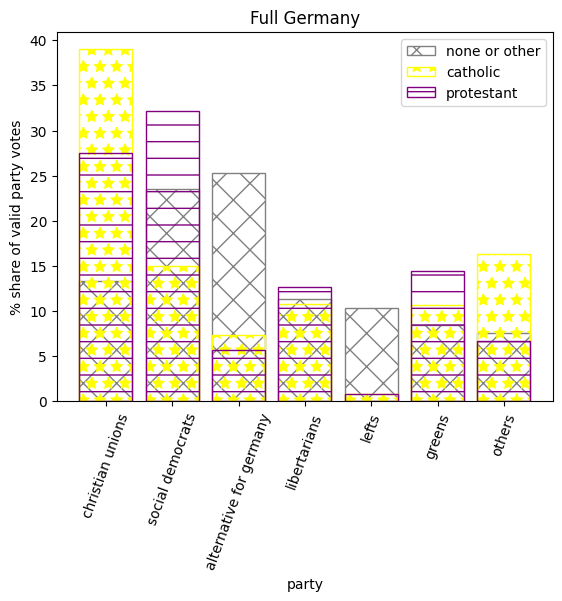

In [216]:
plt.bar(listp3,100*perrel_f[2,2:9]/perrel_f[2,0],facecolor='none',edgecolor='gray',hatch='\\/',label='none or other') 
plt.bar(listp3,100*perrel_f[0,2:9]/perrel_f[0,0],facecolor='none',edgecolor='yellow',hatch='*',label='catholic') 
plt.bar(listp3,100*perrel_f[1,2:9]/perrel_f[1,0],facecolor='none',edgecolor='purple',hatch='-',label='protestant') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% share of valid party votes")
plt.xlabel("party")
plt.title("Full Germany")

Text(0.5, 1.0, 'West Germany')

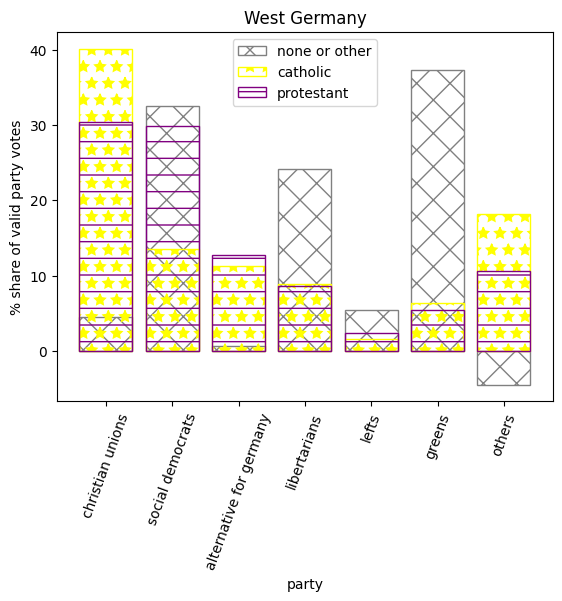

In [204]:
plt.bar(listp3,100*perrel_w[2,2:9]/perrel_w[2,0],facecolor='none',edgecolor='gray',hatch='\\/',label='none or other') 
plt.bar(listp3,100*perrel_w[0,2:9]/perrel_w[0,0],facecolor='none',edgecolor='yellow',hatch='*',label='catholic') 
plt.bar(listp3,100*perrel_w[1,2:9]/perrel_w[1,0],facecolor='none',edgecolor='purple',hatch='-',label='protestant') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% share of valid party votes")
plt.xlabel("party")
plt.title("West Germany")

Text(0.5, 1.0, 'East Germany')

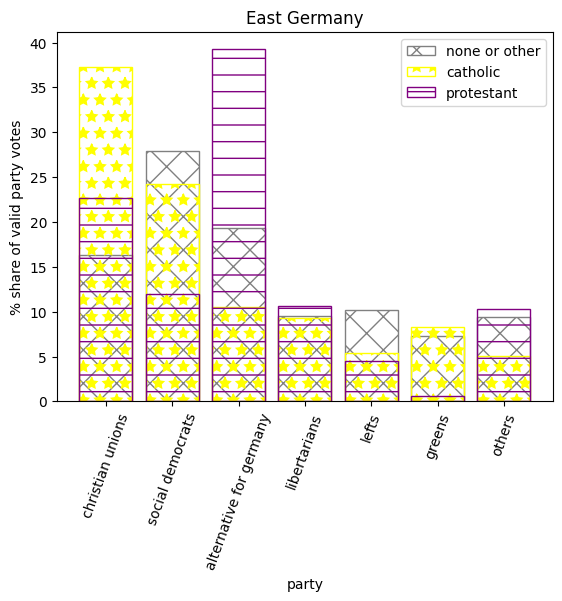

In [205]:
plt.bar(listp3,100*perrel_e[2,2:9]/perrel_e[2,0],facecolor='none',edgecolor='gray',hatch='\\/',label='none or other') 
plt.bar(listp3,100*perrel_e[0,2:9]/perrel_e[0,0],facecolor='none',edgecolor='yellow',hatch='*',label='catholic') 
plt.bar(listp3,100*perrel_e[1,2:9]/perrel_e[1,0],facecolor='none',edgecolor='purple',hatch='-',label='protestant') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% share of valid party votes")
plt.xlabel("party")
plt.title("East Germany")

While the results are mostly plausible there seem to be some problems, most obvious for other parties of other reliigion in Western Germany, where there is a negative fraction is obtained, which is not possible. There are several possible reasons like too much outdated census data, differences between the census population and eligible voters and correlation with other properties. 

We plot the data for other parties in Western Germany below. 

Text(0.5, 1.0, 'West Germany')

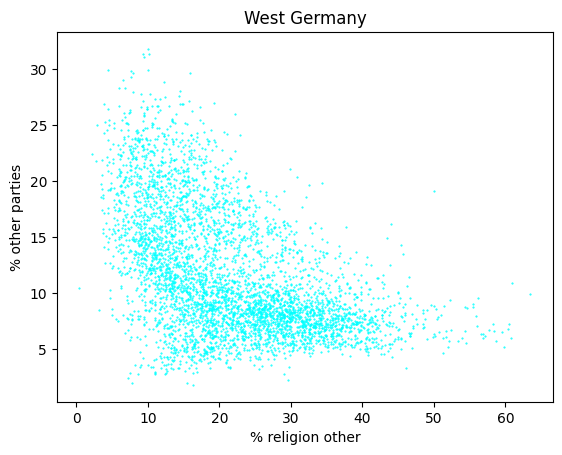

In [212]:

plt.plot(100*(sel2w['population']-sel2w['religion_catholic']-sel2w['religion_protestant'])/sel2w['population'],100*(sel2w['others_party_votes'])/sel2w['valid_party_votes'],'o',ms=0.5,color='cyan') 
#plt.legend(loc="best")
plt.xlabel("% religion other")
plt.ylabel("% other parties")
plt.title("West Germany")

It is visisble that the result for 100% requires extrapolation and is such less reliable. Further it is visible the data follows not a simple linear relation. Both of those applies the previously mentioned problems. 

Text(0.5, 0, 'Section')

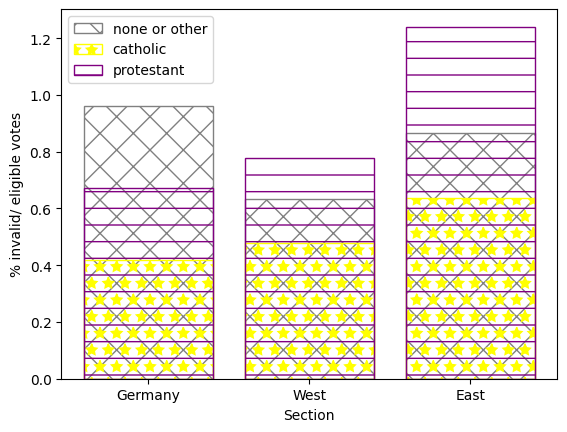

In [214]:
#invalid votes, not important for problem in the way it is set up and numbers are small, thus likely omitted at the end
plt.bar(listf,perrel[2,1,:],facecolor='none',edgecolor='gray',hatch='\\/',label='none or other') 
plt.bar(listf,perrel[0,1,:],facecolor='none',edgecolor='yellow',hatch='*',label='catholic') 
plt.bar(listf,perrel[1,1,:],facecolor='none',edgecolor='purple',hatch='-',label='protestant') 
plt.legend(loc="best")
plt.ylabel("% invalid/ eligible votes")
plt.xlabel("Section")
#plt.title("East Germany")
#alos bad often east and west both on one siide of full

In [179]:
#excluding bad quality at low numbers means some bias towards positive number for small units, some size limit would be good maybe 

Now we look on sex.

In [222]:
listsex=[listg2[0]]
listsex.append('female')
print(listsex)
#fit full, west east
statsex_f,coefsex_f,persex_f =catfitting(sel2,listsex,listp4)
statsex_w,coefsex_w,persex_w =catfitting(sel2w,listsex,listp4)
statsex_e,coefsex_e,persex_e =catfitting(sel2e,listsex,listp4)

['male', 'female']


Text(0.5, 0, 'Section')

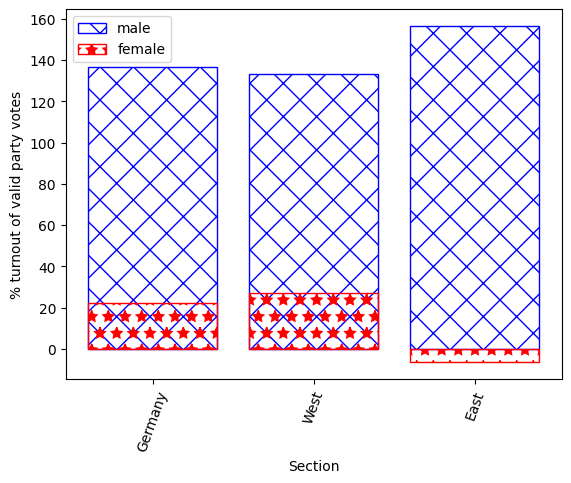

In [228]:
persex=np.zeros((2,9,3))
persex[:,:,0]=persex_f
persex[:,:,1]=persex_w
persex[:,:,2]=persex_e

plt.bar(listf,persex[0,0,:],facecolor='none',edgecolor='blue',hatch='\\/',label='male') 
plt.bar(listf,persex[1,0,:],facecolor='none',edgecolor='red',hatch='*',label='female') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% turnout of valid party votes")
plt.xlabel("Section")

Text(0.5, 1.0, 'Full Germany')

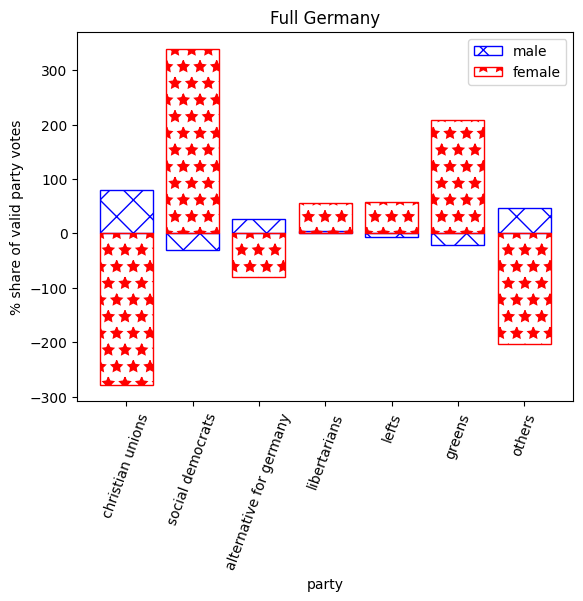

In [225]:
plt.bar(listp3,100*persex_f[0,2:9]/persex_f[0,0],facecolor='none',edgecolor='blue',hatch='\\/',label='male') 
plt.bar(listp3,100*persex_f[1,2:9]/persex_f[1,0],facecolor='none',edgecolor='red',hatch='*',label='female') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% share of valid party votes")
plt.xlabel("party")
plt.title("Full Germany")

In [226]:
plt.bar(listp3,100*persex_w[0,2:9]/persex_w[0,0],facecolor='none',edgecolor='blue',hatch='\\/',label='male') 
plt.bar(listp3,100*persex_w[1,2:9]/persex_w[1,0],facecolor='none',edgecolor='red',hatch='*',label='female') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% share of valid party votes")
plt.xlabel("party")
plt.title("West Germany")

Text(0.5, 1.0, 'West Germany')

Text(0.5, 1.0, 'East Germany')

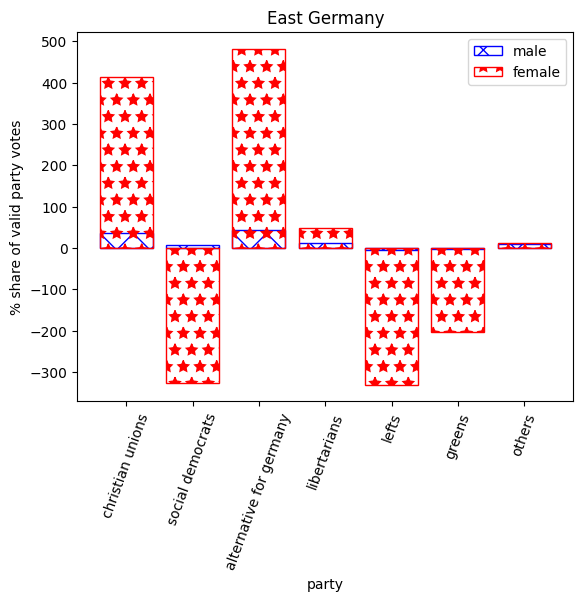

In [227]:
plt.bar(listp3,100*persex_e[0,2:9]/persex_e[0,0],facecolor='none',edgecolor='blue',hatch='\\/',label='male') 
plt.bar(listp3,100*persex_e[1,2:9]/persex_e[1,0],facecolor='none',edgecolor='red',hatch='*',label='female') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% share of valid party votes")
plt.xlabel("party")
plt.title("East Germany")

Clearly does not look good for gender. Many have fractions above 100 and below 0. One problem is that it is usually in a small range around 50%. Secondly, the feature seems also minor compared to others. Thus, it is best ignored. 

In [231]:
#(not adults/german exclusion complication)
print(mycat1)
print(cat)

['age' 'birth_country' 'branch' 'citizen' 'education' 'employment'
 'migration' 'mstatus' 'religion' 'school' 'sex' 'work_position'
 'work_type']
['sex', 'sex', 'mstatus', 'mstatus-sex', 'mstatus-sex', 'mstatus', 'mstatus-sex', 'mstatus-sex', 'mstatus', 'mstatus-sex', 'mstatus-sex', 'mstatus', 'mstatus-sex', 'mstatus-sex', 'mstatus', 'mstatus-sex', 'mstatus-sex', 'mstatus', 'mstatus-sex', 'mstatus-sex', 'mstatus', 'mstatus-sex', 'mstatus-sex', 'mstatus', 'mstatus-sex', 'mstatus-sex', 'age', 'age-sex', 'age-sex', 'age', 'age-sex', 'age-sex', 'age', 'age-sex', 'age-sex', 'age', 'age-sex', 'age-sex', 'age', 'age-sex', 'age-sex', 'age', 'age-sex', 'age-sex', 'age', 'age-sex', 'age-sex', 'citizen', 'birth_country', 'birth_country', 'birth_country', 'birth_country', 'birth_country', 'birth_country', 'religion', 'religion', 'religion', 'migration', 'migration', 'migration-citizen', 'migration-citizen-birth_country', 'migration-citizen-birth_country', 'migration-citizen', 'migration-citizen-bi

In [258]:
#for now ignore below 18 problem
listmstatus=[]

for i in range(len(listg1b)):
    if cat[i]=="mstatus":
        listmstatus.append(listg1b[i])
print(listmstatus)
#droop very rare ones (is effect other is civil union)
listmstatus=listmstatus[0:5]
print(listmstatus)
#more readable names
listmstatus2=['single', 'married', 'widowed', 'divorced', 'civil union']

['single_total', 'married_total', 'widowed_total', 'divorced_total', 'civil_union_total', 'civil_union_widowed_total', 'civil_union_divorced_total', 'not_specified_total']
['single_total', 'married_total', 'widowed_total', 'divorced_total', 'civil_union_total']


In [239]:
#fit full, west east
statmstatus_f,coefmstatus_f,permstatus_f =catfitting(sel2,listmstatus,listp4)
statmstatus_w,coefmstatus,permstatus_w =catfitting(sel2w,listmstatus,listp4)
statmstatus_e,coefmstatus_e,permstatus_e =catfitting(sel2e,listmstatus,listp4)

In [245]:
permstatus=np.zeros((5,9,3))
permstatus[:,:,0]=permstatus_f
permstatus[:,:,1]=permstatus_w
permstatus[:,:,2]=permstatus_e

plt.bar(listf,permstatus[0,0,:],facecolor='lightgray',edgecolor='lightgrey',label='single') 
plt.bar(listf,permstatus[1,0,:],facecolor='none',edgecolor='black',hatch='+',label='married') 
plt.bar(listf,permstatus[2,0,:],facecolor='none',edgecolor='blue',hatch='\\/',label='widowed') 
plt.bar(listf,permstatus[3,0,:],facecolor='none',edgecolor='yellow',hatch='||',label='divorced') 
plt.bar(listf,permstatus[4,0,:],facecolor='none',edgecolor='red',hatch='*',label='civil union') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% turnout of valid party votes")
plt.xlabel("Section")
#very bad means that fractions is ven worse because that depends on that 

Text(0.5, 0, 'Section')

Below nwe slect the number of below 18 in the data. These should be excluded from all the fraction analysis, where thos are nearly all in one category like single. 

In [283]:
#trying both options total-older 
#and younger added together
selage1=sel2.copy()
selage2=sel2.copy()
#older ages
lista1=['total_18_24','total_25_29','total_30_39','total_40_49','total_50_64','total_65_74','total_75_and_older']
#younger ages
lista2=['total_0_2','total_3_5','total_6_14','total_15_17']
for i in range(len(lista1)):

    selage1=selage1[(selage1[lista1[i]]>-0.5) & (selage1['qual_'+lista1[i]]!=1)]

for i in range(len(lista2)):
    selage2=selage2[(selage2[lista2[i]]>-0.5) & (selage2['qual_'+lista2[i]]!=1)]

print(f"number of communities in full data set {len(sel2)}")     
print(f"number of good communities age selection 1 {len(selage1)}")    
print(f"number of good communities age selection 2 {len(selage2)}")  
selage1['total_17_and_younger']=selage1['population']-(selage1['total_18_24']+selage1['total_25_29']+selage1['total_30_39']+selage1['total_40_49']+selage1['total_50_64']+selage1['total_65_74']+selage1['total_75_and_older'])
#also per sex
selage1['male_17_and_younger']=selage1['male']-(selage1['male_18_24']+selage1['male_25_29']+selage1['male_30_39']+selage1['male_40_49']+selage1['male_50_64']+selage1['male_65_74']+selage1['male_75_and_older'])

selage1['female_17_and_younger']=selage1['female']-(selage1['female_18_24']+selage1['female_25_29']+selage1['female_30_39']+selage1['female_40_49']+selage1['female_50_64']+selage1['female_65_74']+selage1['female_75_and_older'])

number of communities in full data set 5098
number of good communities age selection 1 4612
number of good communities age selection 2 4077


Excluding older is the better options as expected, since there more small subdivisions below 18. 

In [284]:
#probbaly subtract that from all relevant groups +total, that is easier way than create new categories
print(selage1.total_17_and_younger.describe())
print(selage1.population.describe())

count      4612.000000
mean       2491.362533
std       10567.932985
min          16.000000
25%         526.000000
50%        1016.000000
75%        2108.000000
max      494383.000000
Name: total_17_and_younger, dtype: float64
count    4.612000e+03
mean     1.524474e+04
std      6.957008e+04
min      8.900000e+01
25%      3.021750e+03
50%      5.870500e+03
75%      1.222900e+04
max      3.292365e+06
Name: population, dtype: float64


In [285]:
print(mycat1)
#subtract from population, single, not_employable
#for sex use total to derive fractions to reduce problems with less reported 
print(listg1b)
fracm=selage1.male_17_and_younger.sum()/selage1.total_17_and_younger.sum()
fracf=selage1.female_17_and_younger.sum()/selage1.total_17_and_younger.sum()
print(fracm)
print(fracf)
selage1.population=selage1.population-selage1.total_17_and_younger
selage1.male=selage1.male-selage1.total_17_and_younger*fracm
selage1.female=selage1.female-selage1.total_17_and_younger*fracf

selage1.single_total=selage1.single_total-selage1.total_17_and_younger
selage1.single_male=selage1.single_male-selage1.total_17_and_younger*fracm
selage1.single_female=selage1.single_female-selage1.total_17_and_younger*fracf

selage1.not_employable_all=selage1.not_employable_all-selage1.total_17_and_younger
selage1.not_employable_male=selage1.not_employable_male-selage1.total_17_and_younger*fracm
selage1.not_employable_female=selage1.not_employable_female-selage1.total_17_and_younger*fracf

#later to do the same for citizen subtract from non german born, migration data 



['age' 'birth_country' 'branch' 'citizen' 'education' 'employment'
 'migration' 'mstatus' 'religion' 'school' 'sex' 'work_position'
 'work_type']
['male', 'female', 'single_total', 'single_male', 'single_female', 'married_total', 'married_male', 'married_female', 'widowed_total', 'widowed_male', 'widowed_female', 'divorced_total', 'divorced_male', 'divorced_female', 'civil_union_total', 'civil_union_male', 'civil_union_female', 'civil_union_widowed_total', 'civil_union_widowed_male', 'civil_union_widowed_female', 'civil_union_divorced_total', 'civil_union_divorced_male', 'civil_union_divorved_female', 'not_specified_total', 'not_specified_male', 'not_specified_female', 'total_18_24', 'male_18_24', 'female_18_24', 'total_25_29', 'male_25_29', 'female_25_29', 'total_30_39', 'male_30_39', 'female_30_39', 'total_40_49', 'male_40_49', 'female_40_49', 'total_50_64', 'male_50_64', 'female_50_64', 'total_65_74', 'male_65_74', 'female_65_74', 'total_75_and_older', 'male_75_and_older', 'female_7

Now fitting the data set for marital status with popel younger than 18 subtracted.


In [287]:
#divide germany in east and west 
selage1e=selage1[selage1['unification']=='East']
selage1w=selage1[selage1['unification']=='West']

statmstatus_fb,coefmstatus_fb,permstatus_fb =catfitting(selage1,listmstatus,listp4)
statmstatus_wb,coefmstatus_wb,permstatus_wb =catfitting(selage1w,listmstatus,listp4)
statmstatus_eb,coefmstatus_eb,permstatus_eb =catfitting(selage1e,listmstatus,listp4)

Text(0.5, 0, 'Section')

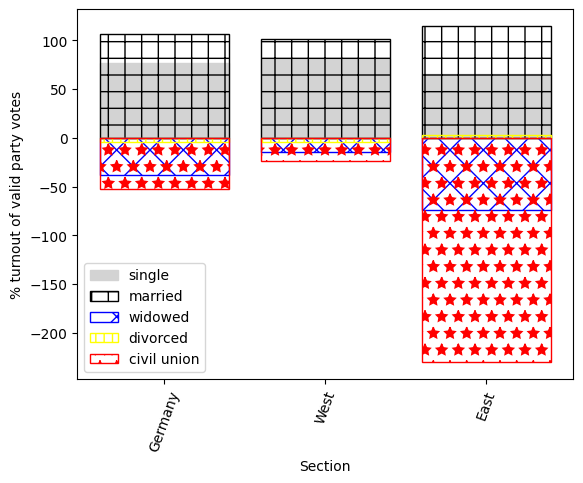

In [289]:
permstatusb=np.zeros((5,9,3))
permstatusb[:,:,0]=permstatus_fb
permstatusb[:,:,1]=permstatus_wb
permstatusb[:,:,2]=permstatus_eb
#nou much better than before

plt.bar(listf,permstatusb[0,0,:],facecolor='lightgray',edgecolor='lightgrey',label='single') 
plt.bar(listf,permstatusb[1,0,:],facecolor='none',edgecolor='black',hatch='+',label='married') 
plt.bar(listf,permstatusb[2,0,:],facecolor='none',edgecolor='blue',hatch='\\/',label='widowed') 
plt.bar(listf,permstatusb[3,0,:],facecolor='none',edgecolor='yellow',hatch='||',label='divorced') 
plt.bar(listf,permstatusb[4,0,:],facecolor='none',edgecolor='red',hatch='*',label='civil union') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% turnout of valid party votes")
plt.xlabel("Section")

In [299]:
listmstatusc=['single_total', 'married_total', 'widowed_total', 'divorced_total']
statmstatus_fc,coefmstatus_fc,permstatus_fc =catfitting(selage1,listmstatusc,listp4)
statmstatus_wc,coefmstatus_wc,permstatus_wc =catfitting(selage1w,listmstatusc,listp4)
statmstatus_ec,coefmstatus_ec,permstatus_ec =catfitting(selage1e,listmstatusc,listp4)

In [300]:
#now w/o civil union
permstatusc=np.zeros((4,9,3))
permstatusc[:,:,0]=permstatus_fc
permstatusc[:,:,1]=permstatus_wc
permstatusc[:,:,2]=permstatus_ec


plt.bar(listf,permstatusc[0,0,:],facecolor='lightgray',edgecolor='lightgrey',label='single') 
plt.bar(listf,permstatusc[1,0,:],facecolor='none',edgecolor='black',hatch='+',label='married') 
plt.bar(listf,permstatusc[2,0,:],facecolor='none',edgecolor='blue',hatch='\\/',label='widowed') 
plt.bar(listf,permstatusc[3,0,:],facecolor='none',edgecolor='yellow',hatch='||',label='divorced') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% turnout of valid party votes")
plt.xlabel("Section")
#does not improve means category does not work 

Text(0.5, 0, 'Section')

In [302]:
#now unemployment
listu=['employed_all', 'unemployed_all',  'not_employable_all']
print(listu)
stat_un_f,coef_un_f,per_un_f =catfitting(selage1,listu,listp4)
stat_un_w,coef_un_w,per_un_w =catfitting(selage1w,listu,listp4)
stat_un_e,coef_un_e,per_un_e =catfitting(selage1e,listu,listp4)

['employed_all', 'unemployed_all', 'not_employable_all']


Text(0.5, 0, 'Section')

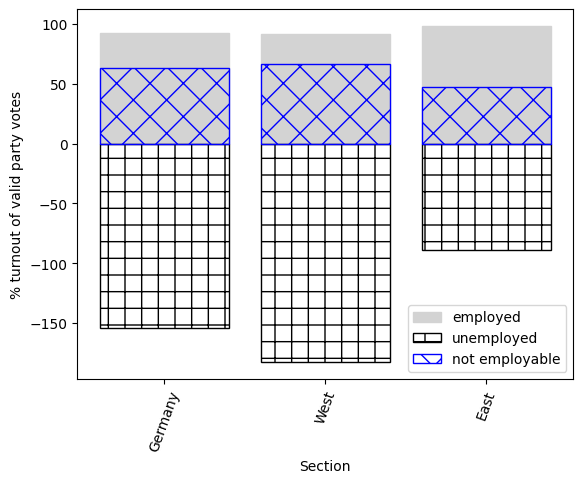

In [307]:
per_un=np.zeros((3,9,3))
per_un[:,:,0]=per_un_f
per_un[:,:,1]=per_un_w
per_un[:,:,2]=per_un_e


plt.bar(listf,per_un[0,0,:],facecolor='lightgray',edgecolor='lightgrey',label='employed') 
plt.bar(listf,per_un[1,0,:],facecolor='none',edgecolor='black',hatch='+',label='unemployed') 
plt.bar(listf,per_un[2,0,:],facecolor='none',edgecolor='blue',hatch='\\/',label='not employable') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% turnout of valid party votes")
plt.xlabel("Section")

(58.0, 90.0)

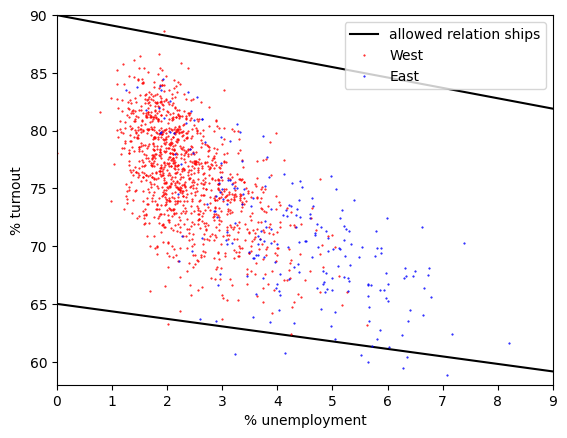

In [336]:
lin=np.zeros((2,2))
lin[0,0]=100
lin[0,1]=0
lin[1,0]=0
lin[1,1]=100
plt.plot(lin[1],lin[0]*0.9,'-',color='black',label='allowed relation ships')
plt.plot(lin[1],lin[0]*0.65,'-',color='black')
plt.plot(100*selage1w['unemployed_all']/selage1w['population'],100*1/(selage1w['eligible_voters'])*selage1w['valid_party_votes'],'o',ms=0.5,color='red',label='West') 
plt.plot(100*selage1e['unemployed_all']/selage1e['population'],100*1/(selage1e['eligible_voters'])*selage1e['valid_party_votes'],'o',ms=0.5,color='blue',label='East') 

plt.legend(loc="best")
plt.xlabel("% unemployment")
plt.ylabel("% turnout")
plt.xlim(0,9)
plt.ylim(58,90)
#plt.title("Germany")

There is a clear relation and as found by the linear regression, the relation ship is strong, so strong that extrapolation leads to negative turnout for 100% unemployed. 

Besides other confusing parameters, another reason could be that also people in contact with unemplyed people change their voting behaviour. 
